In [1]:
import myData
import numpy as np

#for pytorch docker image
#!pip install matplotlib

randomSeed = 12345
myData.rng = np.random.default_rng(randomSeed)

#dataPath = 'D:\\MyWorks\\data'  # dataPeak and dataBase
dataPath  = './data/' # for the school server
onlyRead = True

# 0.025 <= peakMinHeight< 0.15
if not onlyRead:
    dataPeak, dataBase = myData.genData(dataPath, 350000, lenSignal=512, baseOrder=7,
                                        peakCount=(5, 15), peakMinHeight=0.05, peakWidth=(5,21))

# X: Paek Y: Baseline Z: X+Y

gNoiseMax = 0.01
gBaseMin = 0.1
gBaseMax = 0.8

# X: Paek Y: Baseline Z: X + Y*rand([baseRatioMin, baseRatioMax])
trainX, trainY, dataZZ, dataXX, dataYY = myData.prepareData(dataPath,readValidData=onlyRead, noiseMax=gNoiseMax, 
                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.6)
#trainX, trainY, testZZ, testXX, testYY = myData.prepareData(dataPath,readValidData=False, noiseMax=gNoiseMax, 
#                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.8)

validZZ = dataZZ[:70000]
validXX = dataXX[:70000]
validYY = dataYY[:70000]

testZZ = dataZZ[70000:]
testXX = dataXX[70000:]
testYY = dataYY[70000:]

dataWidth = len(trainX.T)
trainSize = len(trainX)
validSize = len(validXX)
testSize = len(testXX)
print(f'trainSize : {trainSize}, validSize: {validSize}, testSize: {testSize}, dataWidth : {dataWidth}')


reading data from files..
reading done..
(210000, 512) (210000, 512)
(140000, 512) (140000, 512) (140000, 512)
reading validation data from files..
All data are prepared.. (140000, 512), (140000, 512), (140000, 512)
trainSize : 210000, validSize: 70000, testSize: 70000, dataWidth : 512


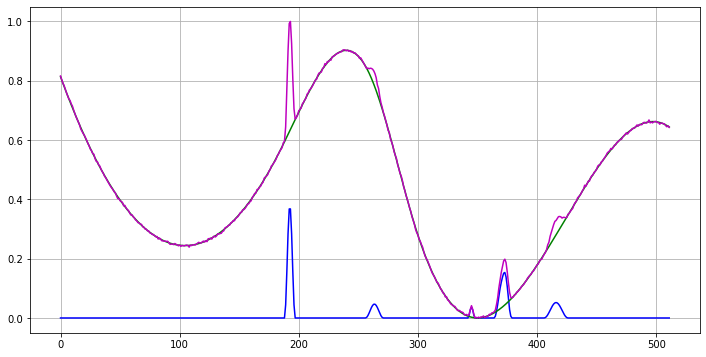

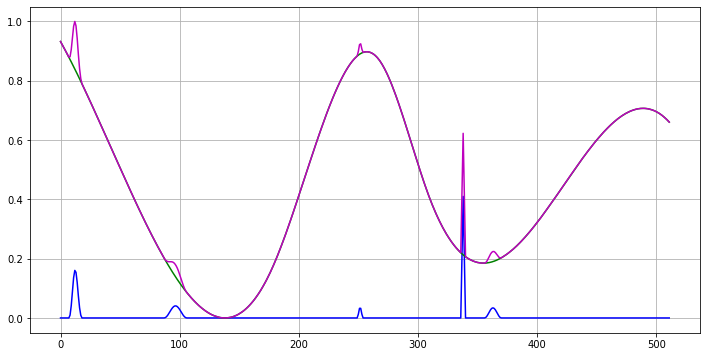

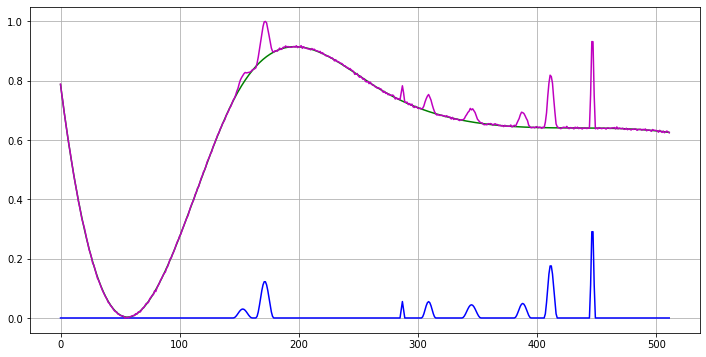

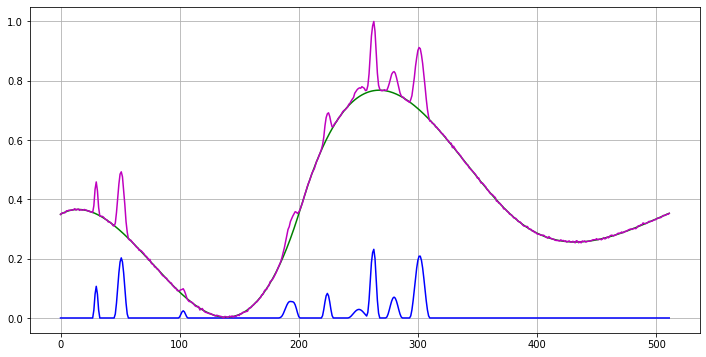

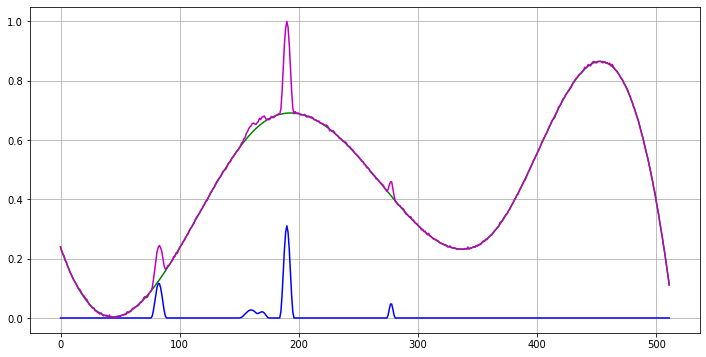

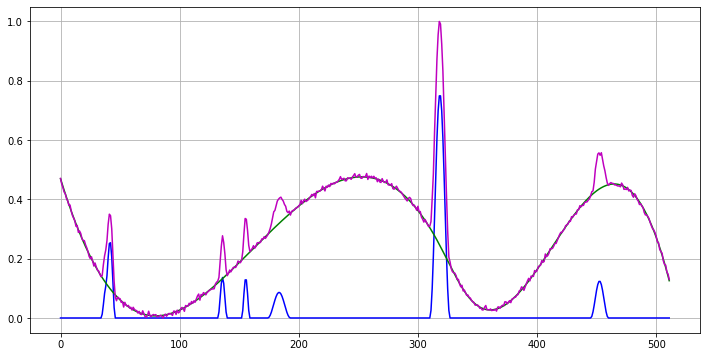

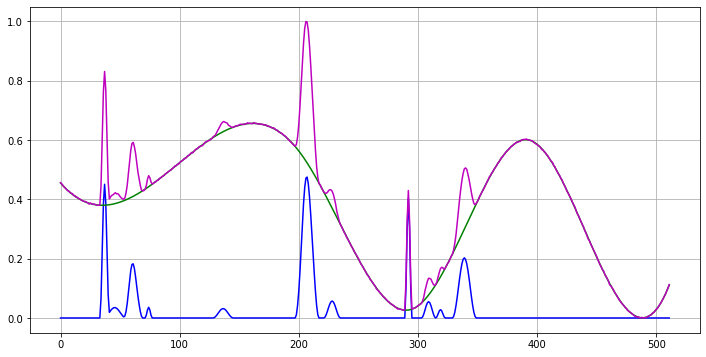

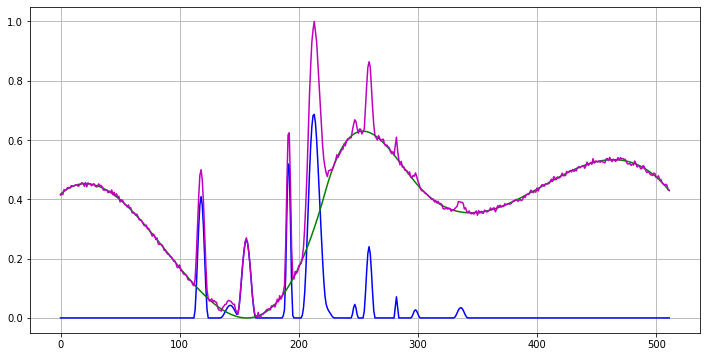

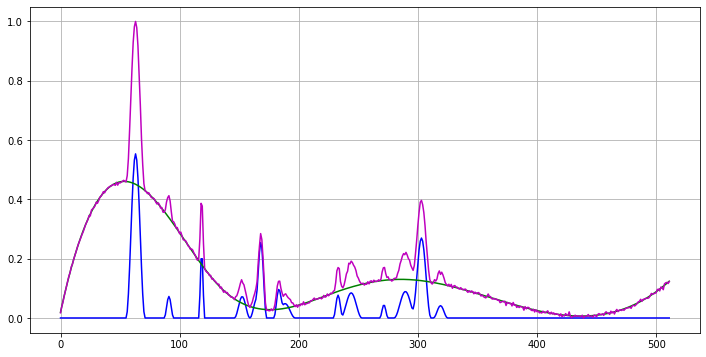

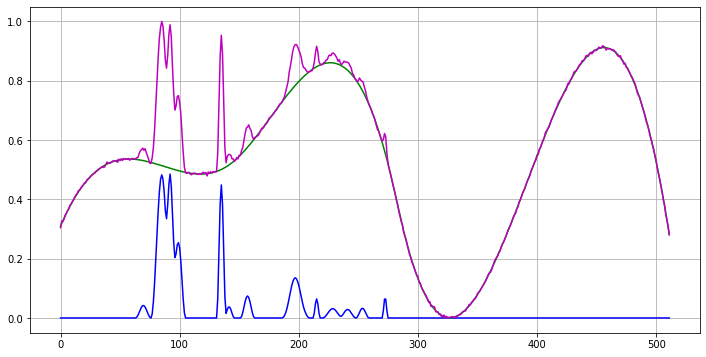

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

for _ in range(10):
    i = random.randint(0, testSize-1)
    plt.figure(figsize=(12,6))
    plt.plot(validXX[i],'b',validYY[i],'g',validZZ[i],'m')
    plt.grid(True)

In [3]:
#!/usr/bin/env python
# coding: utf-8

#from typing import List
from typing import *  # List, Set, Tuple, Dict, Union, Final, Optional, Callable

import numpy as np

'''
from numpy.random import default_rng
rng = default_rng(12345)

noiseSigma = rng.random((dataSize,1))*globalNoiseMax
noiseData = np.random.normal(trainData, scale=noiseSigma,size=(dataSize,dataWidth))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(allData[1200],'m')
plt.grid(True)

# logScale : ex) 8 -> 16 -> 32 -> 64 
layerWidth = np.round(np.logspace(np.log2(8),np.log2(64),4,base=2)).astype(int)
'''

import sys
def getVersion():
    return sys.version

def getVersionNP():
    return np.__version__

def normalize(x, axis=1):
    xmin = x.min(axis, keepdims=True)
    xmax = x.max(axis, keepdims=True)
    return x/(xmax - xmin)

import time
from datetime import timedelta

# use perf_time() for code execution time + pending time + io time
# myTimer = myUtils.MyTimer()
# print(myUtils.myTimer())
class MyTimer:
    def __init__(self, elapsedTime=0):
        self.elapsedTime = elapsedTime
        self.timeOrigin = time.process_time()
                
    def reset(self, elapsedTime=0):
        self.elapsedTime = elapsedTime
        self.timeOrigin = time.process_time()
    
    def __call__(self, inSeconds=True):
        elapsedTime = time.process_time() - self.timeOrigin + self.elapsedTime
        if inSeconds: elapsedTime = int(elapsedTime)
        return str(timedelta(seconds=elapsedTime))            
    
    def elapsedSeconds(self):
        elapsedSecs = time.process_time() - self.timeOrigin + self.elapsedTime
        return int(elapsedSecs)

#try:
#    print('Start training..')
#    trainLog, testLog = myTrainer(trainLoader, testLoader, epochMax=1200)
#except KeyboardInterrupt:
#    myTrainer.saveModel()
#    print('Training interrupted..')
#    raise myUtils.StopException
    
class StopException(Exception):
    def __init__(self, errMessage='StopException'):
        self.errMessage=errMessage
    def _render_traceback_(self):
        pass
    def __str__(self):
        return self.errMessage

import importlib
torch_spec = importlib.util.find_spec('torch')
if torch_spec == None:
    print('Pytorch is not installed. Install pytorch first..')
    raise StopException

import torch
import torch.nn as nn
import torch.nn.functional as F

class myTorch:
    
    @staticmethod
    def getVersion():
        return torch.__version__
    
    @staticmethod
    def standardize(x, mean, std):
        return (x - mean)/std

    @staticmethod
    def standardize_(x, mean, std):
        x.sub_(mean).div_(std)
    
    @staticmethod
    def normalize(x):
        xmin, _ = x.min(1, keepdims=True)
        x = x - xmin
        return x/x.max(1, keepdims=True).values        
    
    @staticmethod
    def normalize_(x):
        xmin, _ = x.min(1, keepdims=True)
        x.sub_(xmin)
        xdelta, _ = x.max(1, keepdims=True)
        x.div_(xdelta)
    
    @staticmethod
    def normalizeXY(x, y):
        xmin, _ = x.min(1, keepdims=True)
        x = x - xmin
        y = y - xmin
        xdelta, _ = x.max(1, keepdims=True)
        return x/xdelta, y/xdelta
    
    @staticmethod
    def normalizeXY_(x, y):
        xmin, _ = x.min(1, keepdims=True)
        x.sub_(xmin)
        y.sub_(xmin)
        xdelta, _ = x.max(1, keepdims=True)
        x.div_(xdelta)
        y.div_(xdelta)

    # usage: torchVariable.to(myDevice)
    @staticmethod
    def deviceGPU(clearCache = False, printInfo = True):
        useGPU = torch.cuda.is_available()
        if useGPU:
            myDevice=torch.device('cuda') # torch.device('cuda:0')
            if printInfo:
                print(f'# of GPU : {torch.cuda.device_count()}')
                deviceNo=torch.cuda.current_device()
                print(f'GPU: {torch.cuda.get_device_name(deviceNo)}, GPU No: {deviceNo}')
                print(f'CUDA capability: {torch.cuda.get_device_capability(myDevice)}')
            if clearCache: torch.cuda.empty_cache()
        else:
            myDevice=torch.device('cpu')

        return myDevice, useGPU
    
    @staticmethod
    def freezeUpdate(myModel, freezeFlag=True):
        assert isinstance(myModel, nn.Module), 'myModel must inherit nn.Module'
        for param in myModel.parameters():
            param.requires_grad = not freezeFlag
    
    def actUnit(actUnit):
        return  nn.ModuleDict([
            ['relu', nn.ReLU(inplace=True)],
            ['relu6', nn.ReLU6(inplace=True)],
            ['leakyrelu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
            ['gelu', nn.GELU()],
            ['selu', nn.SELU(inplace=True)],
            ['silu', nn.SiLU(inplace=True)],
            ['swish', nn.Hardswish(inplace=True)],
            ['elu', nn.ELU(inplace=True)],
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
            ['softsign', nn.Softsign()],
            ['softplus', nn.Softplus()],
            ['silu', nn.SiLU(inplace=True)],
            ['identity', nn.Identity()]
        ])[actUnit.lower()]
    
    # conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)
    # conv1k1 = partial(Conv2dAuto, kernel_size=1, bias=False)
    class Conv1dAuto(nn.Conv1d):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.padding =  self.kernel_size // 2 # dynamic padding according to the kernel_size

    """
    Usage:
    
    from collections import deque
    
    myNet = MyLinear(modelName=myModelName, channelList=[512, 256, 512], layerRepeats=[1, 2, 2], # dataShrink=dataShrink, 
                     preSizeK=0, preAct='ReLU', upType=0, resType=0, useNorm=False)

class MyLinear(torch.nn.Module):
    def __init__(self, modelName='MyPeakX', channelList=[512, 512, 512, 512], layerRepeats=[2, 2, 3, 3], 
                 preSizeK=0, preAct='ReLU', upType=0, resType=0, useNorm=False):
        super().__init__()        
        self.modelName = modelName
        self.upType = upType
        self.preNet = True if preSizeK else False

        # preSize==0 means that preLayer do nothing
        self.preLayer = myTorch.preLinear(channelList, preSizeK, resType, useNorm, actUnit=preAct)
        inSize = channelList[-1] if upType == 0 else channelList[0]
        self.outLayer = myTorch.outLinear(inSize = inSize, outSize = dataWidth)
        
        self.layerA = myTorch.downNetLinear(channelList, layerRepeats, preSizeK, resType, useNorm, actUnit='ReLU')

        ###
        inChannel, lastChannel = channelList[0], channelList[-1]
        self.midLayer = nn.Sequential(
            nn.Linear(lastChannel, dataShrink, bias=True),
            #self.nonLinear,
            nn.Linear(dataShrink, lastChannel, bias=True)
        )
        ###

        if upType <= 0 : return
        
        self.layerB = myTorch.upNetLinear(channelList, layerRepeats, upType, resType, useNorm, actUnit='ReLU')
        
    def forward(self, x):
        x = self.preLayer(x)

        # only forward path
        if self.upType == 0:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)
                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)
        
    """    
    class preLinear(nn.Module):
        def __init__(self, channelList, preSizeK=0, resType=0, useNorm=False, actUnit='ReLU'):
            super().__init__()
           
            preNet = True if preSizeK else False            
            if not preNet: # do nothing if preSizeK == 0
                self.preLayer = nn.ModuleList( [nn.Identity()] )
                self.normLayer = nn.ModuleList( [nn.Identity()] ) if useNorm else None
                self.actUnit = myTorch.actUnit('Identity')
                return
            
            self.actUnit = myTorch.actUnit(actUnit)
            
            assert preSizeK in {0, 1, 2, 4}, 'preNet shoud be in {0, 1, 2, 4}'
            
            dataWidth = channelList[0]
            preDepth = len(channelList) if preNet else 0

            if preNet: self.preChannel = [ channelWidth//preSizeK for channelWidth in channelList ]
            
            self.preLayer = nn.ModuleList( [nn.Identity()] )
            
            self.preLayer.extend( [ nn.Linear(dataWidth, self.preChannel[k] ) for k in range(1,preDepth) ] )                
                
            self.normLayer = nn.ModuleList( [nn.Identity()] ) if useNorm else None
            
            if self.normLayer!=None and preDepth > 1: 
                self.normLayer.extend( [ nn.BatchNorm1d(self.preChannel[k]) for k in range(1, preDepth) ] )
            
        def forward(self, x=None):
            if x!=None:
                if x.ndim == 1: x = x.view(1, -1)
                self.saveX = x
                self.saveK = 0
            else:
                x = self.saveX
                self.saveK += 1
                
            k = self.saveK
            x = self.preLayer[k](x)
            
            if self.normLayer!=None:  x = self.normLayer[k](x)
            
            x = self.actUnit(x)
            
            return x
        
    @staticmethod
    def outLinear(inSize, outSize):
        return nn.Sequential( nn.Flatten(), nn.Linear(inSize, outSize) )

    class BlockLinear(nn.Module):
        def __init__(self, inSize, outSize, numRepeats, preSizeK, resType, useNorm, actUnit='ReLU', initFlag=False):
            super().__init__()
                                        
            self.numRepeats = numRepeats
            # resType == -1 -> -2 when numRepeats == 1
            self.resType = -2 if numRepeats == 1 and resType == -1 else resType
            
            self.linearA = nn.ModuleList()
            self.linearB = nn.ModuleList()
            self.outLayer = nn.ModuleList()
            
            auxSize = outSize//preSizeK if preSizeK else 0
            
            if resType != 0:
                self.shortCut = nn.Linear(inSize, outSize) if inSize != outSize else nn.Identity()
                                
            linearA  = [ nn.Linear(inSize, outSize) ]
            if useNorm: linearA.append( nn.BatchNorm1d(outSize) )
            linearA.append( myTorch.actUnit(actUnit) )
            
            linearB = nn.Linear(outSize + auxSize, outSize)
            
            outLayer = [ nn.BatchNorm1d(outSize) if useNorm else nn.Identity() ]
            outLayer.append( myTorch.actUnit(actUnit) )

            self.linearA.append(nn.Sequential(*linearA))
            self.linearB.append(linearB)
            self.outLayer.append(nn.Sequential(*outLayer))
            
            for _ in range(1, numRepeats):
                
                linearA  = [ nn.Linear(outSize, outSize) ]
                if useNorm: linearA.append( nn.BatchNorm1d(outSize) )
                linearA.append( myTorch.actUnit(actUnit) )

                linearB = nn.Linear(outSize, outSize)

                outLayer = [ nn.BatchNorm1d(outSize) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )

                self.linearA.append(nn.Sequential(*linearA))
                self.linearB.append(linearB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
        def forward(self, x, z = None):
            y = self.linearA[0](x)
            z = y if z == None else torch.cat((y, z), dim=1)
            
            if self.resType !=0: shortX = self.shortCut(x)                
            x = self.linearB[0](z) + shortX if self.resType not in {0, -1} else self.linearB[0](z)
            
            x = self.outLayer[0](x)
            if self.numRepeats ==1: return x
            
            for linearA, linearB, outLayer in zip(self.linearA[1:], self.linearB[1:], self.outLayer[1:]):                
                y = linearA(x) + y if self.resType > 1 else linearA(x)
                if self.resNet >= 0:
                    x = linearB(y) + x if self.resType > 0 else linearB(y)
                else:
                    x = linearB(y) + shortX if linearB==self.linearB[-1] else linearB(y)
                    
                x = outLayer(x)
            
            return x
        
    # preSizeK is currently not used
    @staticmethod
    def downNetLinear(channelList, layerRepeats=2, preSizeK=0, resType=0, useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'        
        layerDepth = len(channelList)
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
            
        # usePreNet except for the first layer    
        layerA = nn.ModuleList( [myTorch.BlockLinear(channelList[0], channelList[0], layerRepeats[0], 
                                                     preSizeK=0, resType=resType, useNorm=useNorm, actUnit=actUnit)] )
        for k in range(1,layerDepth):
            layerA.append( myTorch.BlockLinear(channelList[k-1], channelList[k], layerRepeats[k], preSizeK, resType, useNorm, actUnit) )
        return layerA
        
    @staticmethod        
    def upNetLinear(channelList, layerRepeats=2, upType=0, resType=0, useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'        
        layerDepth = len(channelList)
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth

        preSizeK   = 1 if upType >= 2 else 0            
        channelList, layerRepeats = channelList[::-1], layerRepeats[-2::-1]        
        return nn.ModuleList([myTorch.BlockLinear(channelList[k], channelList[k+1], layerRepeats[k], preSizeK, 
                                                  resType, useNorm, actUnit) for k in range(layerDepth-1)])
   
    """
    Usage:

    # preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
    # preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    # outChannelK is used to reduce the number of the last channels before output channel with outChannel//outChannelK
    # upType = 0: no up net, 1: u-type net, 2: UNet
    # expansionK : replaces 3x1 convolution with 1x1 convolution by expansion {1, 2, 4} 
    # numGroups : divides the layer into small segments for deep network {1, 2, 3, 4, ...}
    # outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
    # resType = 0: no resNet, 1: normal resNet, 2: test resNet, -1: last resNet
    myNet = MyCNN(modelName=myModelName, channelList=[16, 32, 64, 128, 256], channelUpDown=[False, True, True, True, True], 
            layerRepeats=[2, 2, 2, 2, 3], numGroups=1, preNet=4, preSizeK=1, preAct=['identity','relu'], upType=1, expansionK=1, 
            useNorm=False, useResNet=False, outChannelK=8, dataWidth=512)


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

class MyCNN(nn.Module):
    # preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
    # preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    # outChannelK is used to reduce the number of the last channels before output channel with outChannel//outChannelK
    # upType = 0: no up net, 1: u-type net, 2: UNet
    # expansionK : replaces 3x1 convolution with 1x1 convolution by expansion {1, 2, 4} 
    # numGroups : divides the layer into small segments for deep network {1, 2, 3, 4, ...}
    # outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
    # resType = 0: no resNet, 1: normal resNet, 2: test resNet, -1: last resNet
    def __init__(self, modelName='MyPeak', channelList=[32, 64, 128], channelUpDown=[False, True, True], layerRepeats=[2, 2, 3, 3], 
                    numGroups=[2, 2, 2, 2], preNet=0, preSizeK=0, preAct=['Identity','ReLU'], upType=0, expansionK=1, 
                    resType=0, useNorm=False, outChannelK=4, dataWidth=512):        

        super().__init__()        
        self.modelName = modelName
        self.preNet = preNet
        self.upType     = upType
        
        assert expansionK>=1,  'expansionK should be greater than or equal to 1'
        assert outChannelK>=1, 'outChannelK should be greater than or equal to 1'
                
        self.preLayer = myTorch.preCNN(channelList, channelUpDown, preNet, preSizeK, expansionK, useNorm, preAct=preAct)
        self.outLayer = myTorch.outCNN(channelList, channelUpDown, upType, dataWidth, outSize=dataWidth, expansionK=expansionK, 
                                       outChannelK=outChannelK, actUnit='ReLU')
        
        self.layerA = myTorch.downNetCNN(channelList, channelUpDown, layerRepeats, numGroups, preNet, preSizeK, expansionK, 
                                         resType, useNorm, actUnit='ReLU')

        ##### 
        inChannel, midChannel = channelList[0], channelList[-1]
        midChannelX = midChannel//outChannelK
        midWidth = dataWidth//( 2**sum(channelUpDown) )
        midLen = midChannelX * midWidth
        print('midChannelX:',midChannelX, 'midWidth: ', midWidth, 'midLen:', midLen)
        
        self.midLayer = nn.Sequential(
            nn.Conv1d(midChannel*expansionK, midChannelX, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(midLen, dataShrink),
            #self.nonLinear,
            nn.Linear(dataShrink, midLen),
            nn.Unflatten(1, (midChannelX, midWidth ) ),
            nn.Conv1d(midChannelX, midChannel*expansionK, kernel_size=1, stride=1)
        )
        #####                             
                                         
        if upType <= 0: return
        self.layerB = myTorch.upNetCNN(channelList, channelUpDown, layerRepeats, numGroups, upType, expansionK, 
                                       resType, useNorm, actUnit='ReLU')
   
    def forward(self, x):
        x = self.preLayer(x)

        # only forward path
        if self.upType == 0:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)
                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)

    """

    # preNet : 0(No PreNet), 1(direct down), 2(sequential down by 2k), 4(sequential down by 4k) - {2, 4} can be used for keeping
    # preSizeK = 0: No PreNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    
    class preCNN(nn.Module):
        def __init__(self, channelList, channelUpDown, preNet=0, preSizeK=0, expansionK=1, useNorm=False, preAct=['Identity','ReLU']):
            super().__init__()

            if isinstance(preAct,str): preAct = ['Identity', preAct]
            self.preAct = myTorch.actUnit(preAct[0])
            self.actUnit = myTorch.actUnit(preAct[1])
            assert preNet in {0, 1, 2, 4}, 'preNet shoud be in {0, 1, 2, 4}'
            self.preNet = preNet            
            
            if preNet==0: preSizeK=0
            inChannel = channelList[0]
            preDepth = len(channelList) if preNet else 0

            if preNet: self.preChannel = [ channelWidth//preSizeK for channelWidth in channelList ]
            
            preLayer = [ nn.Conv1d(1, inChannel, kernel_size=3, stride=1, padding=1) ]
            if expansionK!=1: preLayer.append( nn.Conv1d(inChannel, inChannel*expansionK, kernel_size=1, stride=1, padding=0) )            
            preLayer = nn.Sequential(*preLayer)
            
            self.preLayer = nn.ModuleList( )
            self.preLayer.append(preLayer)
            
            if preNet==1:
                self.preLayer.extend( [ nn.Conv1d(1, self.preChannel[k], kernel_size=2*2**k, stride=2**k, padding=2**k//2) 
                                                       for k in range(1,preDepth) ] )                
            elif preNet>=2:
                down2k= lambda x, y : nn.Conv1d(x, y, kernel_size=2, stride=2, padding=0) # down
                down4k= lambda x, y : nn.Conv1d(x, y, kernel_size=4, stride=2, padding=1)
                conv3k= lambda x, y : nn.Conv1d(x, y, kernel_size=3, stride=1, padding=1)
                
                downConv = down2k if preNet==2 else down4k

                self.preLayer.append( downConv(1, self.preChannel[1]) if channelUpDown[1] else conv3k(1, self.preChannel[1]) )
                self.preLayer.extend( [ downConv(self.preChannel[k-1], self.preChannel[k]) if channelUpDown[k]
                                        else conv3k(self.preChannel[k-1], self.preChannel[k]) for k in range(2, preDepth) ] )
                
            self.normLayer = nn.ModuleList( [ nn.BatchNorm1d(inChannel*expansionK) ] ) if useNorm else None
            
            if self.normLayer!=None and preDepth>1: 
                self.normLayer.extend( [ nn.BatchNorm1d(self.preChannel[k]) for k in range(1, preDepth) ] )
                
        def forward(self, x=None):
            if x!=None:
                x = x.view(1, 1, -1) if x.ndim == 1 else x.unsqueeze(1)
                self.saveX = x
                self.saveK = 0
            else:
                x = self.saveX
                self.saveK += 1
                
            k = self.saveK
            x = self.preLayer[k](x)
            
            if self.normLayer!=None:  x = self.normLayer[k](x)
            
            if self.saveK and self.preNet>=2: self.saveX = self.preAct(x)

            x = self.actUnit(x)
            return x
        
    @staticmethod
    def outCNN(channelList, channelUpDown, upType, dataWidth, outSize, expansionK=1, outChannelK=2, actUnit='ReLU'):
        inChannel, outChannel = channelList[0], channelList[-1]
        if upType > 0:
            # implicitly assume that dataLength is dataWidth for U type network
            outChannel = inChannel
            return nn.Sequential( nn.Conv1d(outChannel*expansionK, 1, kernel_size=1, stride=1, padding=0), nn.Flatten() )
        
        # All codes below are for forward pass only
        # outChannelK used for output reduction and can be set to 2, 3, 4, ...
        assert outChannelK>=1, 'ensure that int(outChannelK) >= 1'
        
        outChannelX = outChannel//outChannelK
        outWidth = dataWidth//( 2**sum(channelUpDown) )
        outLen = outChannelX * outWidth
        
        print('outChannelX:',outChannelX, 'outWidth: ', outWidth, 'outLen:', outLen)
        
        outLayer = [ nn.Conv1d(outChannel*expansionK, outChannelX, kernel_size=1, stride=1) if outLen > outSize else nn.Identity() ]
        outLayer.append( myTorch.actUnit(actUnit) )
        
        # for classification problem where outChannel < dataWidth
        # AvgPool(k) makes the length of data be outSize without changing the number of channels
        if outSize < dataWidth: outLayer.append( nn.AdaptiveAvgPool1d(outSize) )
        outLayer.extend( [ nn.Flatten(), nn.Linear(outLen, outSize) ] )
        return nn.Sequential(*outLayer)   
        
    class BlockCNN(nn.Module):
        def __init__(self, inChannel, outChannel, layerUpDown, numRepeats, numGroups, preSizeK, expansionK, resType, 
                     useNorm, actUnit='ReLU'):
            super().__init__()
            
            self.numRepeats = numRepeats
            # resType == -1 -> -2 when numRepeats == 1
            self.resType = -2 if numRepeats == 1 and resType == -1 else resType

            auxChannel = outChannel//preSizeK if preSizeK else 0
            conv1k  = lambda x, y : nn.Conv1d(x, y, kernel_size=1, stride=1, padding=0)
            conv3k  = lambda x, y : nn.Conv1d(x, y, kernel_size=3, stride=1, padding=1, groups=numGroups)
            
            # decide which one is to be used between Conv and ConvTransposed
            if layerUpDown>=0:
                # (N+2P-K)/S + 1 = (N+2*1-4)/S + 1 = (N-2)/2 + 1 = N/2,  (N+2*1-3)/1+1 = N-2+1 = N - 1
                # (N+2*0-2)/2 + 1 = (N-2)/2 + 1 = N/2, (N+2*2-8)/4 + 1 = N/4                                
                #upDown1k= lambda x, y : nn.Conv1d(x, y, kernel_size=1, stride=2, padding=0) 
                upDown2k= lambda x, y : nn.Conv1d(x, y, kernel_size=2, stride=2, padding=0) # down
                upDown4k= lambda x, y : nn.Conv1d(x, y, kernel_size=4, stride=2, padding=1)
            else:
                # (N-1)*S - 2P + K = (N-1)*2 - 2*1 + 4 = 2N, (N-1)*4 - 2*2 + 8 = 4N                    
                #upDown1k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=1, stride=2, padding=0, output_padding=1)
                upDown2k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=2, stride=2, padding=0)
                upDown4k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=4, stride=2, padding=1)

            self.convA = nn.ModuleList()
            self.convB = nn.ModuleList()
            self.outLayer = nn.ModuleList()
            
            if expansionK==1:                
                if resType != 0:
                    # if layerUpDown==False and inChannel==outChannel, use nn.Identity()                     
                    idConv = nn.Identity() if inChannel==outChannel else conv3k(inChannel, outChannel)
                    self.shortCut = upDown2k(inChannel, outChannel) if layerUpDown else idConv
                                    
                convA = [ upDown4k(inChannel, outChannel) if layerUpDown else  conv3k(inChannel, outChannel) ]
                if useNorm: convA.append( nn.BatchNorm1d(outChannel) )
                convA.append( myTorch.actUnit(actUnit) )
                
                if auxChannel: self.convZ = nn.Identity()
                outChannelX = outChannel + auxChannel
                convB = conv3k(outChannelX, outChannel)
                
                outLayer = [ nn.BatchNorm1d(outChannel) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )
                

                self.convA.append(nn.Sequential(*convA))
                self.convB.append(convB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
                inChannel = outChannel
                for _ in range(1, numRepeats):

                    convA = [ conv3k(inChannel, outChannel) ]
                    if useNorm: convA.append( nn.BatchNorm1d(outChannel) )
                    convA.append( myTorch.actUnit(actUnit) )

                    convB = conv3k(outChannel, outChannel)

                    outLayer = [ nn.BatchNorm1d(outChannel) if useNorm else nn.Identity() ]
                    outLayer.append( myTorch.actUnit(actUnit) )

                    self.convA.append(nn.Sequential(*convA))
                    self.convB.append(convB)
                    self.outLayer.append(nn.Sequential(*outLayer))
                                                    
            else:
                inChannelX = inChannel*expansionK
                midChannel, outChannelX = outChannel, outChannel*expansionK
                
                if resType != 0:
                    idConv = nn.Identity() if inChannelX==outChannelX else conv3k(inChannelX, outChannelX)
                    self.shortCut = upDown2k(inChannelX, outChannelX) if layerUpDown else idConv
                    
                convA = [ conv1k(inChannelX, midChannel) ]
                if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                convA.append( myTorch.actUnit(actUnit) )

                convA.append( upDown4k(midChannel, midChannel) if layerUpDown else conv3k(midChannel, midChannel) )
                if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                convA.append( myTorch.actUnit(actUnit) )
                    
                # conv1k is needed only for up-path
                if auxChannel: self.convZ = conv1k(outChannelX, midChannel) if inChannel>outChannel else nn.Identity()
                midChannel += auxChannel
                convB = conv1k(midChannel, outChannelX)
                outLayer = [ nn.BatchNorm1d(outChannelX) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )

                self.convA.append(nn.Sequential(*convA))
                self.convB.append(convB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
                for _ in range(1, numRepeats):
                    inChannelX = outChannel*expansionK
                    midChannel, outChannelX = outChannel, outChannel*expansionK

                    convA = [ conv1k(inChannelX, midChannel) ]
                    if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                    convA.append( myTorch.actUnit(actUnit) )
                    
                    convA.append( conv3k(midChannel, midChannel) )                    
                    if useNorm: convA.append( nn.BatchNorm1d(midChannel) )                        
                    convA.append( myTorch.actUnit(actUnit) )

                    convB = conv1k(midChannel, outChannelX)
                    outLayer = [ nn.BatchNorm1d(outChannelX) if useNorm else nn.Identity() ]
                    outLayer.append( myTorch.actUnit(actUnit) )
                    
                    self.convA.append(nn.Sequential(*convA))
                    self.convB.append(convB)
                    self.outLayer.append(nn.Sequential(*outLayer))                              

        def forward(self, x, z = None):
            y = self.convA[0](x)
            z = y if z == None else torch.cat((self.convZ(z), y), dim=1)
            
            if self.resType !=0: shortX = self.shortCut(x)                
            x = self.convB[0](z) + shortX if self.resType not in {0, -1} else self.convB[0](z)
            
            x = self.outLayer[0](x)
            if self.numRepeats == 1: return x
            
            for convA, convB, outLayer in zip(self.convA[1:], self.convB[1:], self.outLayer[1:]):                
                y = convA(x) + y if self.resType > 1 else convA(x)

                if self.resType > 0:
                    x = convB(y) + x if self.resType > 0 else convB(y)
                elif self.resType==-1:
                    x = convB(y) + shortX if convB==self.convB[-1] else convB(y)
                else:
                    x = convB(y)

                x = outLayer(x)
            
            return x
                
    @staticmethod    
    # upType = 0: no up net, 1: u-type net, 2: UNet
    def downNetCNN(channelList, channelUpDown, layerRepeats=2, numGroups=1, preNet=0, preSizeK=0, expansionK=1, resType=0,
                   useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'        
        layerDepth = len(channelList)        
        layerUpDown = [1 if x else 0 for x in channelUpDown ] # 0: no channel width change, 1 : downsize channel width
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
        if isinstance(numGroups, int):    numGroups    = [numGroups]*layerDepth
                
        if preNet==0: preSizeK=0
        # usePreNet except for the first layer
        layerA = nn.ModuleList( [myTorch.BlockCNN(channelList[0], channelList[0], layerUpDown[0], layerRepeats[0], 
                  numGroups[0], preSizeK=0, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit)] ) 
        for k in range(1,layerDepth):
            layerA.append( myTorch.BlockCNN(channelList[k-1], channelList[k], layerUpDown[k], layerRepeats[k], numGroups[k], 
                            preSizeK=preSizeK, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit) )
        return layerA
    
    @staticmethod
    # upType = { 1: U type, 2: UNet }
    def upNetCNN(channelList, channelUpDown, layerRepeats=2, numGroups=1, upType=1, expansionK=1, resType=0, 
                 useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'
        layerDepth = len(channelList)
        layerUpDown = [-1 if x else 0 for x in channelUpDown ] # 0: no channel width change, -1 : upsize channel width
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
        if isinstance(numGroups, int):    numGroups    = [numGroups]*layerDepth

        preSizeK   = 1 if upType==2 else 0
        channelList, layerUpDown, layerRepeats = channelList[::-1], layerUpDown[::-1], layerRepeats[-2::-1]
        layerB = nn.ModuleList([myTorch.BlockCNN(channelList[k], channelList[k+1], layerUpDown[k], layerRepeats[k], numGroups[k], 
          preSizeK, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit ) for k in range(layerDepth-1)])
        return layerB
    
    # End of myTorch class
    
class MyCustomMSE(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        self.baseMargin= baseMargin
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        #errData.copy_(outData - trueData)
        #batchSize = len(outData)
        #errData = self.errData[:batchSize] # to avoid memory allocation
        #errData.copy_(outData - trueData)
        errData = outData - trueData
        errData[errData>self.baseMargin].mul_(2)
        return errData.square().mean()
        #return errData.pow(2).mean()

class MyCustomLoss(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        self.baseMargin= baseMargin
        #self.customLoss = nn.Softshrink(baseMargin)
        self.customLoss = nn.Hardshrink(baseMargin)
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):
        errData = self.customLoss(outData-trueData)
        errData[errData>self.baseMargin].mul_(2)
        return errData.square().mean()
        #return self.customLoss(outData-trueData).square().mean()

class MyCustomLossX(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        #self.customLoss = nn.Softshrink(baseMargin)
        self.customLoss = nn.Hardtanh(min_val=-baseMargin, max_val=baseMargin)
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        return self.customLoss(outData-trueData).square().mean()
    
class MyCustomL1(nn.Module):
    def __init__(self,baseMargin=0.005):
        super().__init__()
        self.baseMargin= baseMargin
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        errData = outData - trueData
        errData[errData>self.baseMargin].mul_(1.5)
        return errData.abs().mean()
"""
class MyFlatten(nn.Module):
    def __init__(self,dataLen):
        super().__init__()
        self.dataLen = dataLen
    def forward(self, input):
        return input.view(-1, self.dataLen)
"""


'\nclass MyFlatten(nn.Module):\n    def __init__(self,dataLen):\n        super().__init__()\n        self.dataLen = dataLen\n    def forward(self, input):\n        return input.view(-1, self.dataLen)\n'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

class MyCNN(nn.Module):
    # preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
    # preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    # outChannelK is used to reduce the number of the last channels before output channel as outChannel//outChannelK
    # upType = 0: no up net, 1: u-type net, 2: UNet
    # expansionK expands the width of the layer for deep network
    # outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
    # resType = 0: no resNet, 1: normal resNet, 2: test resNet
    def __init__(self, modelName='MyPeak', channelList=[32, 64, 128], channelUpDown=[False, True, True], layerRepeats=[2, 2, 3, 3], 
                    numGroups=[2, 2, 2, 2], preNet=0, preSizeK=0, preAct=['Identity','ReLU'], upType=0, expansionK=1, 
                    resType=0, useNorm=False, outChannelK=4, dataWidth=512):        

        super().__init__()        
        self.modelName = modelName
        self.preNet = preNet
        self.upType     = upType
        
        assert expansionK>=1,  'expansionK should be greater than or equal to 1'
        assert outChannelK>=1, 'outChannelK should be greater than or equal to 1'
                
        self.preLayer = myTorch.preCNN(channelList, channelUpDown, preNet, preSizeK, expansionK, useNorm, preAct=preAct)
        self.outLayer = myTorch.outCNN(channelList, channelUpDown, upType, dataWidth, outSize=dataWidth, expansionK=expansionK, 
                                       outChannelK=outChannelK, actUnit='ReLU')
        
        self.layerA = myTorch.downNetCNN(channelList, channelUpDown, layerRepeats, numGroups, preNet, preSizeK, expansionK, 
                                         resType, useNorm, actUnit='ReLU')                                         
        if upType <= 0: return
        self.layerB = myTorch.upNetCNN(channelList, channelUpDown, layerRepeats, numGroups, upType, expansionK, 
                                       resType, useNorm, actUnit='ReLU')
   
    def forward(self, x):
        x = self.preLayer(x)

        # only forward path
        if self.upType == 0:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)
                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)
    
print('MyCNN is defined..')

class MyLinear(torch.nn.Module):
    def __init__(self, modelName='MyPeakX', channelList=[512, 512, 512, 512], layerRepeats=[2, 2, 3, 3], 
                 preSizeK=0, preAct='ReLU', upType=0, resType=0, useNorm=False):
        super().__init__()        
        self.modelName = modelName
        self.upType = upType
        self.preNet = True if preSizeK else False

        # preSize==0 means that preLayer do nothing
        self.preLayer = myTorch.preLinear(channelList, preSizeK, resType, useNorm, actUnit=preAct)
        inSize = channelList[-1] if upType == 0 else channelList[0]
        self.outLayer = myTorch.outLinear(inSize = inSize, outSize = dataWidth)
        
        self.layerA = myTorch.downNetLinear(channelList, layerRepeats, preSizeK, resType, useNorm, actUnit='ReLU')
        
        if upType <= 0 : return
        
        self.layerB = myTorch.upNetLinear(channelList, layerRepeats, upType, resType, useNorm, actUnit='ReLU')
        
    def forward(self, x):
        x = self.preLayer(x)

        # only forward path
        if self.upType == 0:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)
                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)

print('MyLinear is defined..')


MyCNN is defined..
MyLinear is defined..


In [5]:
import numpy as np
import torch
#import myUtils

def preProcess(batchNo, netX, netY):
    #####
    noiseMax = gNoiseMax
    baseRatioMin = gBaseMin
    baseRatioMax = gBaseMax
    randomSeed = 12345
    #####
    netDevice = netX.device
    batchSize = len(netX)   
    baseRatio = torch.empty((batchSize,1), device=netX.device, dtype=torch.float32).uniform_(baseRatioMin, baseRatioMax)
    peakRatio = 1 - baseRatio
    
    #permIndex = torch.randperm(batchSize,device=netX.device)
    #netX = netX[permIndex] if iType==1 else netX[permIndex].fliplr()
    evenBatch = batchNo % 2
    if evenBatch:
        netX = netX[torch.randperm(batchSize,device=netDevice)]*peakRatio
    else:
        netX = netX[torch.randperm(batchSize,device=netDevice)].flip(1)*peakRatio

    netY = netY*baseRatio if evenBatch else (1-netY)*baseRatio
    
    # reverse or invert 
    netZ = netX + netY
    
    #noiseX = torch.randn_like(netZ)*(noiseMax*deltaZ)
    #netZ += noiseX
    #netY += noiseX # for clean peak
    #####

    # add noise        
    netZ = torch.normal(netZ, std=noiseMax*peakRatio*torch.rand(batchSize,1,device=netDevice))
    
    # normlized again
    zMin, _ = netZ.min(1, keepdims=True)
    netZ -= zMin
    
    zDelta, _ = netZ.max(1, keepdims=True)
    netY -= zMin
    
    return netZ/zDelta, netY/zDelta
#    return netZ/zDelta, netX/zDelta

class MyTrainer(torch.nn.Module):
    def __init__(self, myModel, myDevice, learningRate = 0.0005, patienceCount=100, continueTraining = False):
        super().__init__()
        #####
        self.elapsedTime = 0
        
        self.preProcess = preProcess
        self.trainLoss, self.testLoss = torch.nn.MSELoss(), torch.nn.L1Loss()
        self.myDevice = myDevice
        self.myModel = myModel.to(myDevice)
       
        self.lr = learningRate
        self.lrMin = self.lr/8
        self.myOptimizer = torch.optim.Adam(myModel.parameters(), lr=self.lr)
        self.myScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.myOptimizer, 'min', factor=4/5, patience=patienceCount)

        self.fmax = np.finfo(np.float32).max        
        self.lossMin = self.fmax
        self.epochSave = 0

        try:
            self.myTimer = myUtils.MyTimer()
        except NameError:
            self.myTimer = MyTimer()
        
        randomSeed = 12345        
        if myDevice.type == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.manual_seed(randomSeed)
        else:
            torch.manual_seed(randomSeed)
        
        if continueTraining: self.loadModel()

        self.lr = self.myOptimizer.param_groups[0]['lr']        
        countParameters = sum(p.numel() for p in myModel.parameters() if p.requires_grad)
        print(f'Number of parameters : {countParameters}, learning rate : {self.lr}')
        
    def trainModel(self, trainLoader):
        self.myModel.train() # for batch normalization or dropout

        lossSum, lossMax = 0., 0.
        for batchIndex, (netX, netY) in enumerate(trainLoader):
            netX = netX.to(device=self.myDevice, non_blocking=True)
            netY = netY.to(device=self.myDevice, non_blocking=True)

            if self.preProcess != None: 
                netZ, netY = self.preProcess(batchIndex, netX, netY)
            else:
                netZ = netX + netY

            self.myOptimizer.zero_grad()
            netYt = self.myModel(netZ)
            
            loss  = self.trainLoss(netYt,netY)
            loss_t = loss.item()            
            loss.backward()
            
            #loss.backward(retain_graph=True)
            #lossX = self.trainLoss(netZ-netYt,netX)
            #lossX.backward()
            
            self.myOptimizer.step()
            
            if lossMax < loss_t: lossMax = loss_t
            lossSum += loss_t

        return lossSum/len(trainLoader), lossMax

    def testModel(self, testLoader):
        self.myModel.eval() # for batch normalization or dropout
        with torch.no_grad():
            lossSum, lossMax = 0., 0.
            countTrue = 0
            for netZ, netX, netY in testLoader:
                netZ = netZ.to(device=self.myDevice, non_blocking=True)
                netY = netY.to(device=self.myDevice, non_blocking=True)
                #netX = netX.to(device=self.myDevice, non_blocking=True)
                                
                netYt = self.myModel(netZ)
                loss  = self.testLoss(netYt,netY)
                loss_t= loss.item()
                #loss += self.testLoss(netZ-netYt,netX)
                
                if lossMax < loss_t: lossMax = loss_t
                lossSum += loss_t

                #netZ = netY.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                #countTrue += netZ.eq(netT.view_as(outZ)).sum().item()
            
        return lossSum/len(testLoader), lossMax
        #return lossSum/len(testLoader),  lossMax, 100.*countTrue/len(testLoader)

    def saveModel(self, saveMaxModel=False):
        if saveMaxModel:
            modelName = self.myModel.modelName+'_Max'            
        else:
            modelName = self.myModel.modelName
                
        torch.save({'modelState':self.myModel.state_dict(),
                    'epochSave':self.epochSave,
                    'lossMin':self.lossMin,
                    'elapsedTime':self.myTimer.elapsedSeconds(),
                    'schedulerState':self.myScheduler.state_dict(),
                    'optimizerState':self.myOptimizer.state_dict()
                   }, modelName+'.pth')
        print('### A model is saved:', modelName+'.pth')
        print('### elapsed time :', self.myTimer())
        
    def loadModel(self):
        modelDict = torch.load(self.myModel.modelName+'.pth')
        self.myModel.load_state_dict(modelDict['modelState'])
        self.epochSave = modelDict['epochSave']
        self.lossMin = modelDict['lossMin']
        self.elapsedTime = modelDict['elapsedTime']
        self.myOptimizer.load_state_dict(modelDict['optimizerState'])
        self.myScheduler.load_state_dict(modelDict['schedulerState'])
        print('### A model is loaded:', self.myModel.modelName+'.pth') 
       
    def forward(self, trainLoader, testLoader, epochMax=2000): 
        trainLog = []
        testLog  = []
        testLossMin = self.lossMin # for continueTraining
        trainLossMin = trainLossMinMax = testLossMinMax = self.fmax
        
        self.myTimer.reset(self.elapsedTime)
        for epoch in range(self.epochSave, epochMax):
            trainLoss, trainLossMax = self.trainModel(trainLoader)            
            testLoss, testLossMax = self.testModel(testLoader)
                                          
            trainLoss = trainLoss**(1/2) # for MSE
            trainLog.append(trainLoss)
            testLog.append(testLoss)

            if trainLossMax < trainLossMinMax: trainLossMinMax = trainLossMax
            if testLossMax < testLossMinMax: testLossMinMax = testLossMax            
            if trainLoss < trainLossMin: trainLossMin = trainLoss
                
            self.epochSave = epoch + 1
            if testLoss < testLossMin:
                self.lossMin = testLossMin = testLoss
                if self.epochSave > 50:                     
                    self.saveModel(saveMaxModel=True)
                        
            print(f'{epoch:4d} : trLoss {trainLoss:.7f}({trainLossMin:.7f}), vLoss(L1) {testLoss:.7f}({testLossMin:.7f}), vLossMax(L1) {testLossMax:.7f}({testLossMinMax:.7f})')
                        
            self.myScheduler.step(testLossMin)
            #lr=self.myScheduler.get_last_lr()
            lr = self.myOptimizer.param_groups[0]['lr']
            if lr<=self.lrMin:
                print(f'lr reaches {self.lr:.10f}. exit..')
                break
                            
            if self.epochSave%100 == 0:
                if self.epochSave>=200: self.saveModel(saveMaxModel=False)
                print(f'#   Training continues.. lr = {lr:.10f},  time : ({self.myTimer()})')
            
        print(f'Overall time : ({self.myTimer()})')
        print('Training Finished..')

        return trainLog, testLog
    
print('MyTrainer is defined..') 

MyTrainer is defined..


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print('torch version',torch.__version__)

trainX = torch.as_tensor(trainX, dtype=torch.float32)
trainY = torch.as_tensor(trainY, dtype=torch.float32)
trainSet = torch.utils.data.TensorDataset(trainX, trainY)

validX = torch.as_tensor(validXX, dtype=torch.float32)
validY = torch.as_tensor(validYY, dtype=torch.float32)
validZ = torch.as_tensor(validZZ, dtype=torch.float32)
validSet = torch.utils.data.TensorDataset(validZ, validX, validY)

testX = torch.as_tensor(testXX, dtype=torch.float32)
testY = torch.as_tensor(testYY, dtype=torch.float32)
testZ = torch.as_tensor(testZZ, dtype=torch.float32)
testSet = torch.utils.data.TensorDataset(testZ, testX, testY)

print(f'Data {trainX.shape}, {trainY.shape}, {validX.shape}, {validY.shape} in {trainX.device}')
dataWidth = len(trainX.T)

batchSize, numWorkers = 500, 1

trainLoader = DataLoader(dataset=trainSet, shuffle=True, batch_size=batchSize, num_workers=numWorkers, pin_memory=True)
validLoader  = DataLoader(dataset=validSet,  shuffle=False, batch_size=batchSize, num_workers=numWorkers, pin_memory=True)
testLoader  = DataLoader(dataset=testSet,  shuffle=False, batch_size=batchSize, num_workers=numWorkers, pin_memory=True)
print(f'train: {len(trainLoader)}, valid: {len(validLoader)}, test: {len(testLoader)}')


torch version 1.7.0
Data torch.Size([210000, 512]), torch.Size([210000, 512]), torch.Size([70000, 512]), torch.Size([70000, 512]) in cpu
train: 420, valid: 140, test: 140


In [7]:
#from myUtils import myTorch

myDevice, useGPU = myTorch.deviceGPU(clearCache = True, printInfo = True)
modelName = 'ResNet_Unet'
# preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
# preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
# outChannelK is used to reduce the number of the last channels before output channel with outChannel//outChannelK
# upType = 0: no up net, 1: u-type net, 2: UNet
# expansionK : replaces 3x1 convolution with 1x1 convolution by expansion {1, 2, 4} 
# numGroups : divides the layer into small segments for deep network {1, 2, 3, 4, ...}
# outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
# resType = 0: no resNet, 1: normal resNet, 2: test resNet, -1: last resNet

#myNet = MyCNN(modelName=modelName, channelList=[32, 48, 72, 108, 162], channelUpDown=[False, True, True, True, True], 
#                layerRepeats=[2, 2, 2, 2, 2], numGroups=1, preNet=0, preSizeK=2, preAct=['identity','relu'], upType=2, expansionK=1, 
#                resType=2, useNorm=False, outChannelK=64, dataWidth=512)
myNet = MyCNN(modelName=modelName, channelList=[32, 48, 72, 108, 162, 244], channelUpDown=[False, True, True, True, True, True], 
                layerRepeats=[2, 2, 2, 2, 2, 2], numGroups=1, preNet=0, preSizeK=2, preAct=['identity','relu'], upType=2, expansionK=1, 
                resType=1, useNorm=False, outChannelK=64, dataWidth=512)
#myNet = MyLinear(modelName=modelName, channelList=[512, 256, 128, 64, 32], layerRepeats=[1, 2, 2, 2, 2], 
#                 preSizeK=2, preAct='ReLU', upType=2, resType=1, useNorm=True)

print('MyNet is defined..')

# of GPU : 1
GPU: GeForce RTX 3080, GPU No: 0
CUDA capability: (8, 6)
MyNet is defined..


In [8]:
myNet

MyCNN(
  (preLayer): preCNN(
    (preAct): Identity()
    (actUnit): ReLU(inplace=True)
    (preLayer): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
  )
  (outLayer): Sequential(
    (0): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (layerA): ModuleList(
    (0): BlockCNN(
      (convA): ModuleList(
        (0): Sequential(
          (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
        )
      )
      (convB): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (outLayer): ModuleList(
        (0): Sequential(
          (0): Identity()
          (1): Re

In [9]:
#!pip install pytorch-model-summary

from pytorch_model_summary import summary

x=torch.zeros( (512, )) # or .cuda()
# show input shape
# print(summary(myNet, x, show_input=True))

# show output shape
#print(summary(myNet, x, show_input=False))

# show output shape and hierarchical view of net
print(summary(myNet, x, show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          preCNN-1        [1, 32, 512]             128             128
        BlockCNN-2        [1, 32, 512]          12,416          12,416
        BlockCNN-3        [1, 48, 256]          30,192          30,192
        BlockCNN-4        [1, 72, 128]          67,752          67,752
        BlockCNN-5        [1, 108, 64]         152,172         152,172
        BlockCNN-6        [1, 162, 32]         341,982         341,982
        BlockCNN-7        [1, 244, 16]         774,212         774,212
        BlockCNN-8        [1, 162, 32]         552,906         552,906
        BlockCNN-9        [1, 108, 64]         245,484         245,484
       BlockCNN-10        [1, 72, 128]         109,224         109,224
       BlockCNN-11        [1, 48, 256]          48,624          48,624
       BlockCNN-12        [1, 32, 512]          21,664          21,664
     

In [10]:
#print(myNet)

myTrainer = MyTrainer(myNet, myDevice, learningRate = 0.0005, patienceCount=75, continueTraining = False)
try:
    print('Start training..')
    trainLog, testLog = myTrainer(trainLoader, validLoader, epochMax=1200)
except (KeyboardInterrupt, RuntimeError) as e:
    myTrainer.saveModel()    
    print('Training interrupted..')
    print('Exception:', e)
    
    try:
        raise myUtils.StopException
    except NameError:   
        raise StopException

Number of parameters : 2356789, learning rate : 0.0005
Start training..
   0 : trLoss 0.0577198(0.0577198), vLoss(L1) 0.0035544(0.0035544), vLossMax(L1) 0.0036240(0.0036240)
   1 : trLoss 0.0043479(0.0043479), vLoss(L1) 0.0026930(0.0026930), vLossMax(L1) 0.0027698(0.0027698)
   2 : trLoss 0.0036182(0.0036182), vLoss(L1) 0.0033871(0.0026930), vLossMax(L1) 0.0034851(0.0027698)
   3 : trLoss 0.0031858(0.0031858), vLoss(L1) 0.0019376(0.0019376), vLossMax(L1) 0.0019811(0.0019811)
   4 : trLoss 0.0030018(0.0030018), vLoss(L1) 0.0026415(0.0019376), vLossMax(L1) 0.0027307(0.0019811)
   5 : trLoss 0.0029752(0.0029752), vLoss(L1) 0.0035352(0.0019376), vLossMax(L1) 0.0036015(0.0019811)
   6 : trLoss 0.0030720(0.0029752), vLoss(L1) 0.0020851(0.0019376), vLossMax(L1) 0.0021246(0.0019811)
   7 : trLoss 0.0026616(0.0026616), vLoss(L1) 0.0011103(0.0011103), vLossMax(L1) 0.0011617(0.0011617)
   8 : trLoss 0.0026301(0.0026301), vLoss(L1) 0.0016645(0.0011103), vLossMax(L1) 0.0016974(0.0011617)
   9 : trL

  77 : trLoss 0.0010910(0.0009903), vLoss(L1) 0.0023587(0.0005514), vLossMax(L1) 0.0023982(0.0005955)
  78 : trLoss 0.0010911(0.0009903), vLoss(L1) 0.0007421(0.0005514), vLossMax(L1) 0.0007821(0.0005955)
### A model is saved: ResNet_Unet_Max.pth
### elapsed time : 1:42:01
  79 : trLoss 0.0010949(0.0009903), vLoss(L1) 0.0005491(0.0005491), vLossMax(L1) 0.0005965(0.0005955)
  80 : trLoss 0.0011297(0.0009903), vLoss(L1) 0.0007801(0.0005491), vLossMax(L1) 0.0008201(0.0005955)
### A model is saved: ResNet_Unet_Max.pth
### elapsed time : 1:44:34
  81 : trLoss 0.0012971(0.0009903), vLoss(L1) 0.0005354(0.0005354), vLossMax(L1) 0.0005795(0.0005795)
  82 : trLoss 0.0009726(0.0009726), vLoss(L1) 0.0008435(0.0005354), vLossMax(L1) 0.0008773(0.0005795)
  83 : trLoss 0.0011266(0.0009726), vLoss(L1) 0.0010419(0.0005354), vLossMax(L1) 0.0010916(0.0005795)
  84 : trLoss 0.0010140(0.0009726), vLoss(L1) 0.0007758(0.0005354), vLossMax(L1) 0.0008123(0.0005795)
  85 : trLoss 0.0010520(0.0009726), vLoss(L1) 

 154 : trLoss 0.0009407(0.0008927), vLoss(L1) 0.0008380(0.0005063), vLossMax(L1) 0.0008716(0.0005530)
 155 : trLoss 0.0009386(0.0008927), vLoss(L1) 0.0005540(0.0005063), vLossMax(L1) 0.0006003(0.0005530)
 156 : trLoss 0.0009063(0.0008927), vLoss(L1) 0.0005183(0.0005063), vLossMax(L1) 0.0005636(0.0005530)
 157 : trLoss 0.0009224(0.0008927), vLoss(L1) 0.0007095(0.0005063), vLossMax(L1) 0.0007472(0.0005530)
 158 : trLoss 0.0009290(0.0008927), vLoss(L1) 0.0007035(0.0005063), vLossMax(L1) 0.0007373(0.0005530)
 159 : trLoss 0.0009135(0.0008927), vLoss(L1) 0.0008248(0.0005063), vLossMax(L1) 0.0008588(0.0005530)
 160 : trLoss 0.0009324(0.0008927), vLoss(L1) 0.0007927(0.0005063), vLossMax(L1) 0.0008270(0.0005530)
 161 : trLoss 0.0009072(0.0008927), vLoss(L1) 0.0005938(0.0005063), vLossMax(L1) 0.0006371(0.0005530)
 162 : trLoss 0.0009383(0.0008927), vLoss(L1) 0.0006694(0.0005063), vLossMax(L1) 0.0007110(0.0005530)
 163 : trLoss 0.0009140(0.0008927), vLoss(L1) 0.0006129(0.0005063), vLossMax(L1) 0

 229 : trLoss 0.0008409(0.0007818), vLoss(L1) 0.0006229(0.0004731), vLossMax(L1) 0.0006600(0.0005171)
 230 : trLoss 0.0008377(0.0007818), vLoss(L1) 0.0006506(0.0004731), vLossMax(L1) 0.0006881(0.0005171)
 231 : trLoss 0.0008381(0.0007818), vLoss(L1) 0.0005523(0.0004731), vLossMax(L1) 0.0005940(0.0005171)
 232 : trLoss 0.0008578(0.0007818), vLoss(L1) 0.0005942(0.0004731), vLossMax(L1) 0.0006330(0.0005171)
 233 : trLoss 0.0008306(0.0007818), vLoss(L1) 0.0004885(0.0004731), vLossMax(L1) 0.0005282(0.0005171)
 234 : trLoss 0.0008402(0.0007818), vLoss(L1) 0.0005631(0.0004731), vLossMax(L1) 0.0006022(0.0005171)
 235 : trLoss 0.0008411(0.0007818), vLoss(L1) 0.0005556(0.0004731), vLossMax(L1) 0.0005946(0.0005171)
 236 : trLoss 0.0008370(0.0007818), vLoss(L1) 0.0007293(0.0004731), vLossMax(L1) 0.0007677(0.0005171)
 237 : trLoss 0.0008268(0.0007818), vLoss(L1) 0.0005026(0.0004731), vLossMax(L1) 0.0005445(0.0005171)
 238 : trLoss 0.0008518(0.0007818), vLoss(L1) 0.0004807(0.0004731), vLossMax(L1) 0

 307 : trLoss 0.0008252(0.0007445), vLoss(L1) 0.0004715(0.0004621), vLossMax(L1) 0.0005179(0.0005059)
 308 : trLoss 0.0007992(0.0007445), vLoss(L1) 0.0008373(0.0004621), vLossMax(L1) 0.0008709(0.0005059)
 309 : trLoss 0.0008052(0.0007445), vLoss(L1) 0.0005366(0.0004621), vLossMax(L1) 0.0005746(0.0005059)
 310 : trLoss 0.0008061(0.0007445), vLoss(L1) 0.0004704(0.0004621), vLossMax(L1) 0.0005155(0.0005059)
 311 : trLoss 0.0008029(0.0007445), vLoss(L1) 0.0005071(0.0004621), vLossMax(L1) 0.0005512(0.0005059)
 312 : trLoss 0.0008570(0.0007445), vLoss(L1) 0.0004750(0.0004621), vLossMax(L1) 0.0005198(0.0005059)
 313 : trLoss 0.0007620(0.0007445), vLoss(L1) 0.0005629(0.0004621), vLossMax(L1) 0.0006054(0.0005059)
 314 : trLoss 0.0008019(0.0007445), vLoss(L1) 0.0004625(0.0004621), vLossMax(L1) 0.0005078(0.0005059)
 315 : trLoss 0.0008035(0.0007445), vLoss(L1) 0.0006576(0.0004621), vLossMax(L1) 0.0006908(0.0005059)
 316 : trLoss 0.0007982(0.0007445), vLoss(L1) 0.0004819(0.0004621), vLossMax(L1) 0

 386 : trLoss 0.0007734(0.0007445), vLoss(L1) 0.0004835(0.0004603), vLossMax(L1) 0.0005257(0.0005043)
 387 : trLoss 0.0007853(0.0007445), vLoss(L1) 0.0005397(0.0004603), vLossMax(L1) 0.0005834(0.0005043)
 388 : trLoss 0.0007946(0.0007445), vLoss(L1) 0.0004764(0.0004603), vLossMax(L1) 0.0005214(0.0005043)
 389 : trLoss 0.0007762(0.0007445), vLoss(L1) 0.0005050(0.0004603), vLossMax(L1) 0.0005484(0.0005043)
 390 : trLoss 0.0007935(0.0007445), vLoss(L1) 0.0004783(0.0004603), vLossMax(L1) 0.0005226(0.0005043)
 391 : trLoss 0.0007733(0.0007445), vLoss(L1) 0.0005482(0.0004603), vLossMax(L1) 0.0005876(0.0005043)
 392 : trLoss 0.0007810(0.0007445), vLoss(L1) 0.0005282(0.0004603), vLossMax(L1) 0.0005677(0.0005043)
 393 : trLoss 0.0007877(0.0007445), vLoss(L1) 0.0005541(0.0004603), vLossMax(L1) 0.0005923(0.0005043)
 394 : trLoss 0.0007881(0.0007445), vLoss(L1) 0.0007658(0.0004603), vLossMax(L1) 0.0007979(0.0005043)
 395 : trLoss 0.0007787(0.0007445), vLoss(L1) 0.0004847(0.0004603), vLossMax(L1) 0

 464 : trLoss 0.0007740(0.0007445), vLoss(L1) 0.0004893(0.0004465), vLossMax(L1) 0.0005358(0.0004926)
 465 : trLoss 0.0007801(0.0007445), vLoss(L1) 0.0004742(0.0004465), vLossMax(L1) 0.0005175(0.0004926)
 466 : trLoss 0.0007700(0.0007445), vLoss(L1) 0.0005335(0.0004465), vLossMax(L1) 0.0005737(0.0004926)
 467 : trLoss 0.0007788(0.0007445), vLoss(L1) 0.0004660(0.0004465), vLossMax(L1) 0.0005072(0.0004926)
 468 : trLoss 0.0007750(0.0007445), vLoss(L1) 0.0005035(0.0004465), vLossMax(L1) 0.0005461(0.0004926)
 469 : trLoss 0.0007753(0.0007445), vLoss(L1) 0.0005063(0.0004465), vLossMax(L1) 0.0005455(0.0004926)
 470 : trLoss 0.0007631(0.0007445), vLoss(L1) 0.0004740(0.0004465), vLossMax(L1) 0.0005181(0.0004926)
 471 : trLoss 0.0007760(0.0007445), vLoss(L1) 0.0004619(0.0004465), vLossMax(L1) 0.0005061(0.0004926)
 472 : trLoss 0.0007738(0.0007445), vLoss(L1) 0.0004896(0.0004465), vLossMax(L1) 0.0005329(0.0004926)
 473 : trLoss 0.0007646(0.0007445), vLoss(L1) 0.0006710(0.0004465), vLossMax(L1) 0

 543 : trLoss 0.0007180(0.0006979), vLoss(L1) 0.0004535(0.0004435), vLossMax(L1) 0.0004973(0.0004875)
 544 : trLoss 0.0007293(0.0006979), vLoss(L1) 0.0005367(0.0004435), vLossMax(L1) 0.0005745(0.0004875)
 545 : trLoss 0.0007289(0.0006979), vLoss(L1) 0.0005064(0.0004435), vLossMax(L1) 0.0005488(0.0004875)
 546 : trLoss 0.0007240(0.0006979), vLoss(L1) 0.0004940(0.0004435), vLossMax(L1) 0.0005365(0.0004875)
 547 : trLoss 0.0007334(0.0006979), vLoss(L1) 0.0004870(0.0004435), vLossMax(L1) 0.0005264(0.0004875)
 548 : trLoss 0.0007189(0.0006979), vLoss(L1) 0.0006098(0.0004435), vLossMax(L1) 0.0006477(0.0004875)
 549 : trLoss 0.0007289(0.0006979), vLoss(L1) 0.0005608(0.0004435), vLossMax(L1) 0.0006014(0.0004875)
 550 : trLoss 0.0007219(0.0006979), vLoss(L1) 0.0004786(0.0004435), vLossMax(L1) 0.0005270(0.0004875)
 551 : trLoss 0.0007353(0.0006979), vLoss(L1) 0.0004765(0.0004435), vLossMax(L1) 0.0005203(0.0004875)
 552 : trLoss 0.0007150(0.0006979), vLoss(L1) 0.0004998(0.0004435), vLossMax(L1) 0

 620 : trLoss 0.0007209(0.0006908), vLoss(L1) 0.0004717(0.0004410), vLossMax(L1) 0.0005154(0.0004864)
 621 : trLoss 0.0007249(0.0006908), vLoss(L1) 0.0004562(0.0004410), vLossMax(L1) 0.0004978(0.0004864)
 622 : trLoss 0.0007154(0.0006908), vLoss(L1) 0.0004550(0.0004410), vLossMax(L1) 0.0004969(0.0004864)
 623 : trLoss 0.0007156(0.0006908), vLoss(L1) 0.0005089(0.0004410), vLossMax(L1) 0.0005479(0.0004864)
 624 : trLoss 0.0007272(0.0006908), vLoss(L1) 0.0004800(0.0004410), vLossMax(L1) 0.0005244(0.0004864)
 625 : trLoss 0.0007133(0.0006908), vLoss(L1) 0.0004476(0.0004410), vLossMax(L1) 0.0004888(0.0004864)
 626 : trLoss 0.0007172(0.0006908), vLoss(L1) 0.0004460(0.0004410), vLossMax(L1) 0.0004902(0.0004864)
 627 : trLoss 0.0007201(0.0006908), vLoss(L1) 0.0004616(0.0004410), vLossMax(L1) 0.0005035(0.0004864)
 628 : trLoss 0.0007228(0.0006908), vLoss(L1) 0.0005093(0.0004410), vLossMax(L1) 0.0005507(0.0004864)
 629 : trLoss 0.0007168(0.0006908), vLoss(L1) 0.0004426(0.0004410), vLossMax(L1) 0

 699 : trLoss 0.0007120(0.0006908), vLoss(L1) 0.0004650(0.0004383), vLossMax(L1) 0.0005075(0.0004802)
### A model is saved: ResNet_Unet.pth
### elapsed time : 14:50:01
#   Training continues.. lr = 0.0004000000,  time : (14:50:01)
 700 : trLoss 0.0007141(0.0006908), vLoss(L1) 0.0006879(0.0004383), vLossMax(L1) 0.0007199(0.0004802)
 701 : trLoss 0.0007184(0.0006908), vLoss(L1) 0.0004525(0.0004383), vLossMax(L1) 0.0004961(0.0004802)
 702 : trLoss 0.0007144(0.0006908), vLoss(L1) 0.0006050(0.0004383), vLossMax(L1) 0.0006391(0.0004802)
 703 : trLoss 0.0007117(0.0006908), vLoss(L1) 0.0004645(0.0004383), vLossMax(L1) 0.0005079(0.0004802)
 704 : trLoss 0.0007258(0.0006908), vLoss(L1) 0.0004772(0.0004383), vLossMax(L1) 0.0005199(0.0004802)
 705 : trLoss 0.0007114(0.0006908), vLoss(L1) 0.0007112(0.0004383), vLossMax(L1) 0.0007425(0.0004802)
 706 : trLoss 0.0007126(0.0006908), vLoss(L1) 0.0005844(0.0004383), vLossMax(L1) 0.0006229(0.0004802)
 707 : trLoss 0.0007111(0.0006908), vLoss(L1) 0.0005167

 776 : trLoss 0.0006986(0.0006839), vLoss(L1) 0.0005063(0.0004322), vLossMax(L1) 0.0005456(0.0004756)
 777 : trLoss 0.0007002(0.0006839), vLoss(L1) 0.0004380(0.0004322), vLossMax(L1) 0.0004803(0.0004756)
 778 : trLoss 0.0007015(0.0006839), vLoss(L1) 0.0004915(0.0004322), vLossMax(L1) 0.0005327(0.0004756)
 779 : trLoss 0.0006935(0.0006839), vLoss(L1) 0.0004661(0.0004322), vLossMax(L1) 0.0005095(0.0004756)
 780 : trLoss 0.0006959(0.0006839), vLoss(L1) 0.0004999(0.0004322), vLossMax(L1) 0.0005428(0.0004756)
 781 : trLoss 0.0007021(0.0006839), vLoss(L1) 0.0004374(0.0004322), vLossMax(L1) 0.0004816(0.0004756)
 782 : trLoss 0.0006948(0.0006839), vLoss(L1) 0.0004685(0.0004322), vLossMax(L1) 0.0005106(0.0004756)
 783 : trLoss 0.0006934(0.0006839), vLoss(L1) 0.0005961(0.0004322), vLossMax(L1) 0.0006319(0.0004756)
 784 : trLoss 0.0007002(0.0006839), vLoss(L1) 0.0004827(0.0004322), vLossMax(L1) 0.0005241(0.0004756)
### A model is saved: ResNet_Unet_Max.pth
### elapsed time : 16:38:57
 785 : trLos

 854 : trLoss 0.0006940(0.0006839), vLoss(L1) 0.0004704(0.0004306), vLossMax(L1) 0.0005086(0.0004740)
 855 : trLoss 0.0006972(0.0006839), vLoss(L1) 0.0004311(0.0004306), vLossMax(L1) 0.0004746(0.0004740)
 856 : trLoss 0.0006890(0.0006839), vLoss(L1) 0.0004678(0.0004306), vLossMax(L1) 0.0005091(0.0004740)
 857 : trLoss 0.0007012(0.0006839), vLoss(L1) 0.0004948(0.0004306), vLossMax(L1) 0.0005347(0.0004740)
 858 : trLoss 0.0007048(0.0006839), vLoss(L1) 0.0004409(0.0004306), vLossMax(L1) 0.0004846(0.0004740)
 859 : trLoss 0.0006878(0.0006839), vLoss(L1) 0.0004322(0.0004306), vLossMax(L1) 0.0004735(0.0004735)
 860 : trLoss 0.0006913(0.0006839), vLoss(L1) 0.0004831(0.0004306), vLossMax(L1) 0.0005251(0.0004735)
 861 : trLoss 0.0006971(0.0006839), vLoss(L1) 0.0004406(0.0004306), vLossMax(L1) 0.0004832(0.0004735)
 862 : trLoss 0.0006935(0.0006839), vLoss(L1) 0.0004368(0.0004306), vLossMax(L1) 0.0004810(0.0004735)
 863 : trLoss 0.0006973(0.0006839), vLoss(L1) 0.0004367(0.0004306), vLossMax(L1) 0

 933 : trLoss 0.0006902(0.0006839), vLoss(L1) 0.0004385(0.0004294), vLossMax(L1) 0.0004809(0.0004720)
 934 : trLoss 0.0006961(0.0006839), vLoss(L1) 0.0005346(0.0004294), vLossMax(L1) 0.0005727(0.0004720)
 935 : trLoss 0.0006883(0.0006839), vLoss(L1) 0.0004513(0.0004294), vLossMax(L1) 0.0004925(0.0004720)
 936 : trLoss 0.0006934(0.0006839), vLoss(L1) 0.0004347(0.0004294), vLossMax(L1) 0.0004766(0.0004720)
 937 : trLoss 0.0006913(0.0006839), vLoss(L1) 0.0004487(0.0004294), vLossMax(L1) 0.0004919(0.0004720)
 938 : trLoss 0.0006926(0.0006839), vLoss(L1) 0.0004394(0.0004294), vLossMax(L1) 0.0004837(0.0004720)
 939 : trLoss 0.0006892(0.0006839), vLoss(L1) 0.0004479(0.0004294), vLossMax(L1) 0.0004955(0.0004720)
 940 : trLoss 0.0006987(0.0006839), vLoss(L1) 0.0004399(0.0004294), vLossMax(L1) 0.0004828(0.0004720)
 941 : trLoss 0.0006918(0.0006839), vLoss(L1) 0.0004463(0.0004294), vLossMax(L1) 0.0004906(0.0004720)
 942 : trLoss 0.0006921(0.0006839), vLoss(L1) 0.0004331(0.0004294), vLossMax(L1) 0

1011 : trLoss 0.0006876(0.0006746), vLoss(L1) 0.0004337(0.0004280), vLossMax(L1) 0.0004758(0.0004710)
1012 : trLoss 0.0006806(0.0006746), vLoss(L1) 0.0004390(0.0004280), vLossMax(L1) 0.0004812(0.0004710)
1013 : trLoss 0.0006832(0.0006746), vLoss(L1) 0.0004420(0.0004280), vLossMax(L1) 0.0004838(0.0004710)
1014 : trLoss 0.0006814(0.0006746), vLoss(L1) 0.0004317(0.0004280), vLossMax(L1) 0.0004727(0.0004710)
1015 : trLoss 0.0006808(0.0006746), vLoss(L1) 0.0004283(0.0004280), vLossMax(L1) 0.0004691(0.0004691)
1016 : trLoss 0.0006829(0.0006746), vLoss(L1) 0.0004810(0.0004280), vLossMax(L1) 0.0005219(0.0004691)
1017 : trLoss 0.0006809(0.0006746), vLoss(L1) 0.0004337(0.0004280), vLossMax(L1) 0.0004745(0.0004691)
1018 : trLoss 0.0006834(0.0006746), vLoss(L1) 0.0004807(0.0004280), vLossMax(L1) 0.0005200(0.0004691)
1019 : trLoss 0.0006835(0.0006746), vLoss(L1) 0.0004293(0.0004280), vLossMax(L1) 0.0004723(0.0004691)
1020 : trLoss 0.0006817(0.0006746), vLoss(L1) 0.0004385(0.0004280), vLossMax(L1) 0

1090 : trLoss 0.0006808(0.0006746), vLoss(L1) 0.0004800(0.0004272), vLossMax(L1) 0.0005198(0.0004691)
1091 : trLoss 0.0006828(0.0006746), vLoss(L1) 0.0004424(0.0004272), vLossMax(L1) 0.0004834(0.0004691)
1092 : trLoss 0.0006815(0.0006746), vLoss(L1) 0.0004321(0.0004272), vLossMax(L1) 0.0004736(0.0004691)
1093 : trLoss 0.0006808(0.0006746), vLoss(L1) 0.0004297(0.0004272), vLossMax(L1) 0.0004722(0.0004691)
1094 : trLoss 0.0006851(0.0006746), vLoss(L1) 0.0004716(0.0004272), vLossMax(L1) 0.0005139(0.0004691)
1095 : trLoss 0.0006754(0.0006746), vLoss(L1) 0.0004728(0.0004272), vLossMax(L1) 0.0005112(0.0004691)
1096 : trLoss 0.0006832(0.0006746), vLoss(L1) 0.0004276(0.0004272), vLossMax(L1) 0.0004711(0.0004691)
1097 : trLoss 0.0006827(0.0006746), vLoss(L1) 0.0004319(0.0004272), vLossMax(L1) 0.0004751(0.0004691)
1098 : trLoss 0.0006858(0.0006746), vLoss(L1) 0.0004736(0.0004272), vLossMax(L1) 0.0005137(0.0004691)
1099 : trLoss 0.0006782(0.0006746), vLoss(L1) 0.0004760(0.0004272), vLossMax(L1) 0

1169 : trLoss 0.0006730(0.0006695), vLoss(L1) 0.0004294(0.0004236), vLossMax(L1) 0.0004724(0.0004657)
1170 : trLoss 0.0006730(0.0006695), vLoss(L1) 0.0004380(0.0004236), vLossMax(L1) 0.0004797(0.0004657)
1171 : trLoss 0.0006748(0.0006695), vLoss(L1) 0.0004251(0.0004236), vLossMax(L1) 0.0004677(0.0004657)
1172 : trLoss 0.0006744(0.0006695), vLoss(L1) 0.0004258(0.0004236), vLossMax(L1) 0.0004682(0.0004657)
1173 : trLoss 0.0006773(0.0006695), vLoss(L1) 0.0004296(0.0004236), vLossMax(L1) 0.0004713(0.0004657)
1174 : trLoss 0.0006742(0.0006695), vLoss(L1) 0.0004280(0.0004236), vLossMax(L1) 0.0004693(0.0004657)
1175 : trLoss 0.0006846(0.0006695), vLoss(L1) 0.0004401(0.0004236), vLossMax(L1) 0.0004839(0.0004657)
1176 : trLoss 0.0006736(0.0006695), vLoss(L1) 0.0004462(0.0004236), vLossMax(L1) 0.0004866(0.0004657)
1177 : trLoss 0.0006738(0.0006695), vLoss(L1) 0.0004337(0.0004236), vLossMax(L1) 0.0004760(0.0004657)
1178 : trLoss 0.0006765(0.0006695), vLoss(L1) 0.0004546(0.0004236), vLossMax(L1) 0

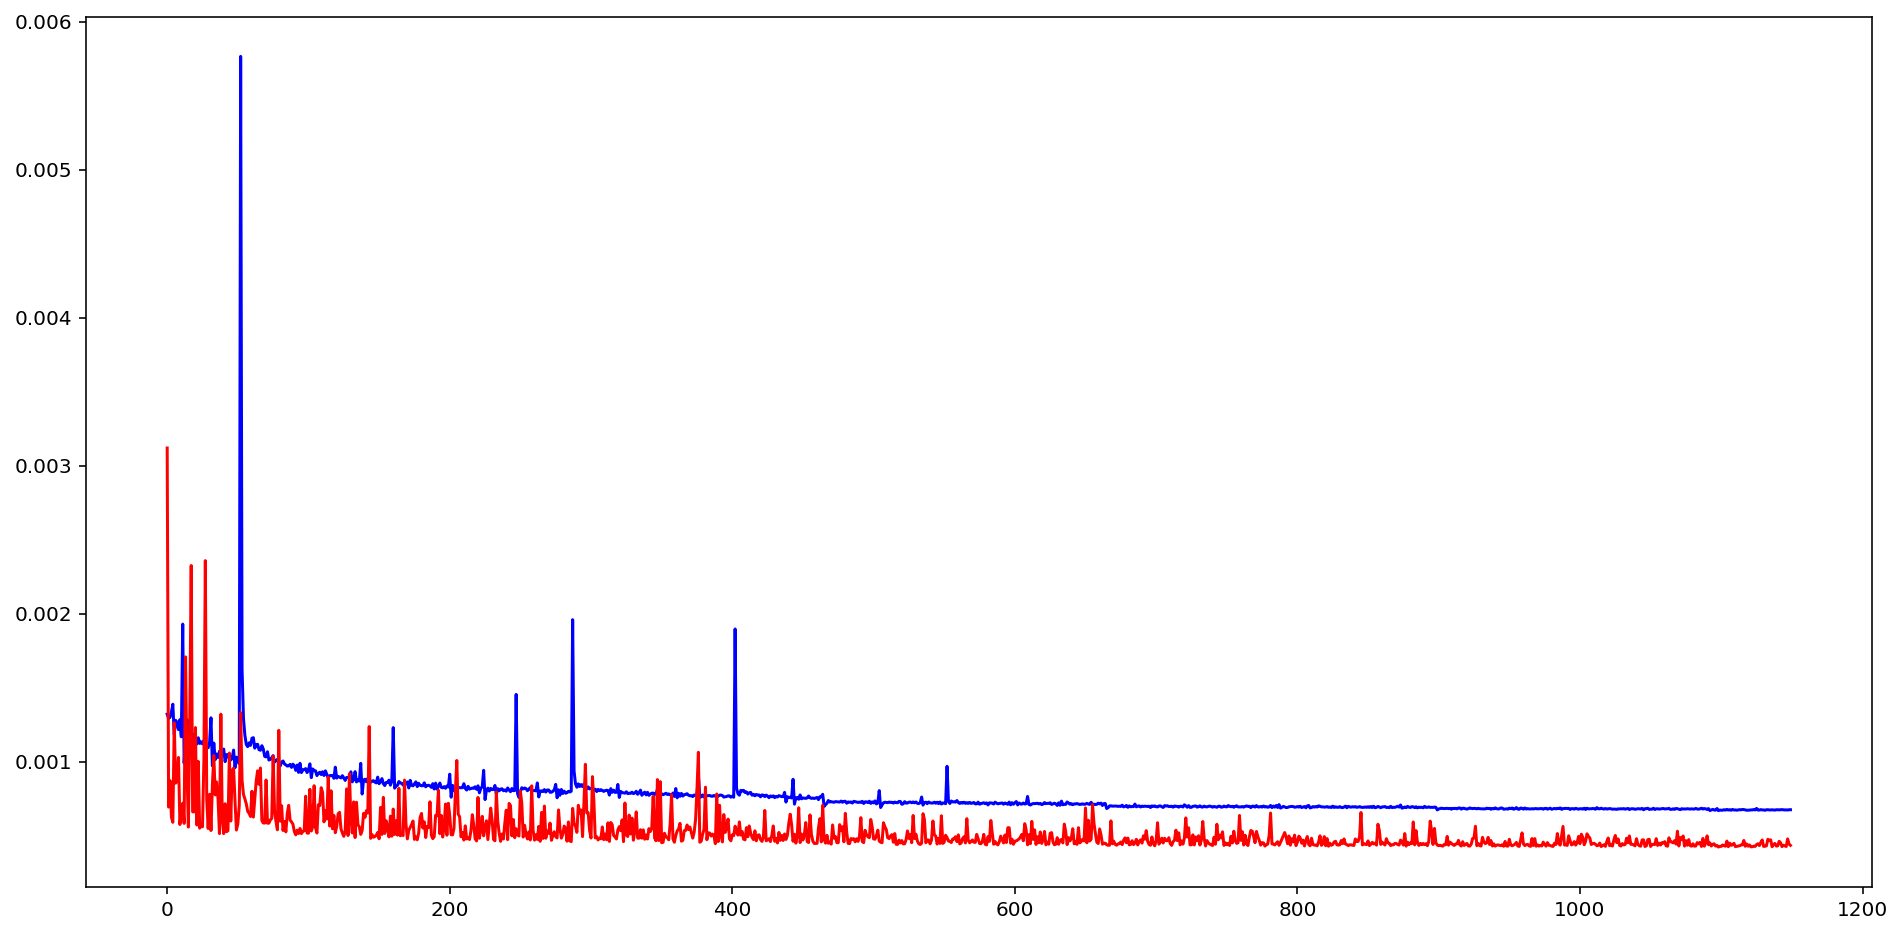

In [11]:
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16,8))
plt.plot(trainLog[50:],'b',testLog[50:],'r')
plt.show()

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

#myDevice, useGPU = myTorch.deviceGPU(clearCache = True, printInfo = True)
#myNet = MyModel(modelName=modelName, altType=False, dataWidth=dataWidth, updateCNN=[1,1,-1,1]).to(myDevice)

modelDict = torch.load(modelName+'_Max.pth')
myNet.load_state_dict(modelDict['modelState'])

validSize = len(validX)
outData_valid = np.zeros((validSize,dataWidth),dtype=np.float32)
outScore_valid = np.zeros(validSize,dtype=np.float32)

with torch.no_grad():
    lossSum, lossMax = 0, 0
    for i, (inZ, trueY, outY) in enumerate(zip(validZ,validY,outData_valid)):
        if useGPU: inZ, trueY  = inZ.cuda(non_blocking=True), trueY.cuda(non_blocking=True)

        netY = myNet(inZ).view(-1)
        lossT = torch.nn.functional.l1_loss(netY, trueY)
        if useGPU:
            netY=netY.cpu()
            lossT=lossT.cpu()
        
        outY[:]=netY.numpy()
        outScore_valid[i]=lossT
            
        lossSum += lossT
        if lossT>lossMax: lossMax=lossT
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    print(f'loss : {lossSum/validSize:.7f}, loss max : {lossMax:.7f}')

      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
  20000 data are processed..
  25000 data are processed..
  30000 data are processed..
  35000 data are processed..
  40000 data are processed..
  45000 data are processed..
  50000 data are processed..
  55000 data are processed..
  60000 data are processed..
  65000 data are processed..
loss : 0.0004236, loss max : 0.0026698


In [13]:
testSize = len(testX)
outData = np.zeros((testSize,dataWidth),dtype=np.float32)
outScore=np.zeros(testSize,dtype=np.float32)

with torch.no_grad():
    lossSum, lossMax = 0, 0
    for i, (inZ, trueY, outY) in enumerate(zip(testZ,testY,outData)):
        if useGPU: inZ, trueY  = inZ.cuda(non_blocking=True), trueY.cuda(non_blocking=True)

        netY = myNet(inZ).view(-1)
        lossT = torch.nn.functional.l1_loss(netY, trueY)
        if useGPU:
            netY=netY.cpu()
            lossT=lossT.cpu()
        
        outY[:]=netY.numpy()
        outScore[i]=lossT
            
        lossSum += lossT
        if lossT>lossMax: lossMax=lossT
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    print(f'loss : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}')

      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
  20000 data are processed..
  25000 data are processed..
  30000 data are processed..
  35000 data are processed..
  40000 data are processed..
  45000 data are processed..
  50000 data are processed..
  55000 data are processed..
  60000 data are processed..
  65000 data are processed..
loss : 0.0004235, loss max : 0.0034267


314


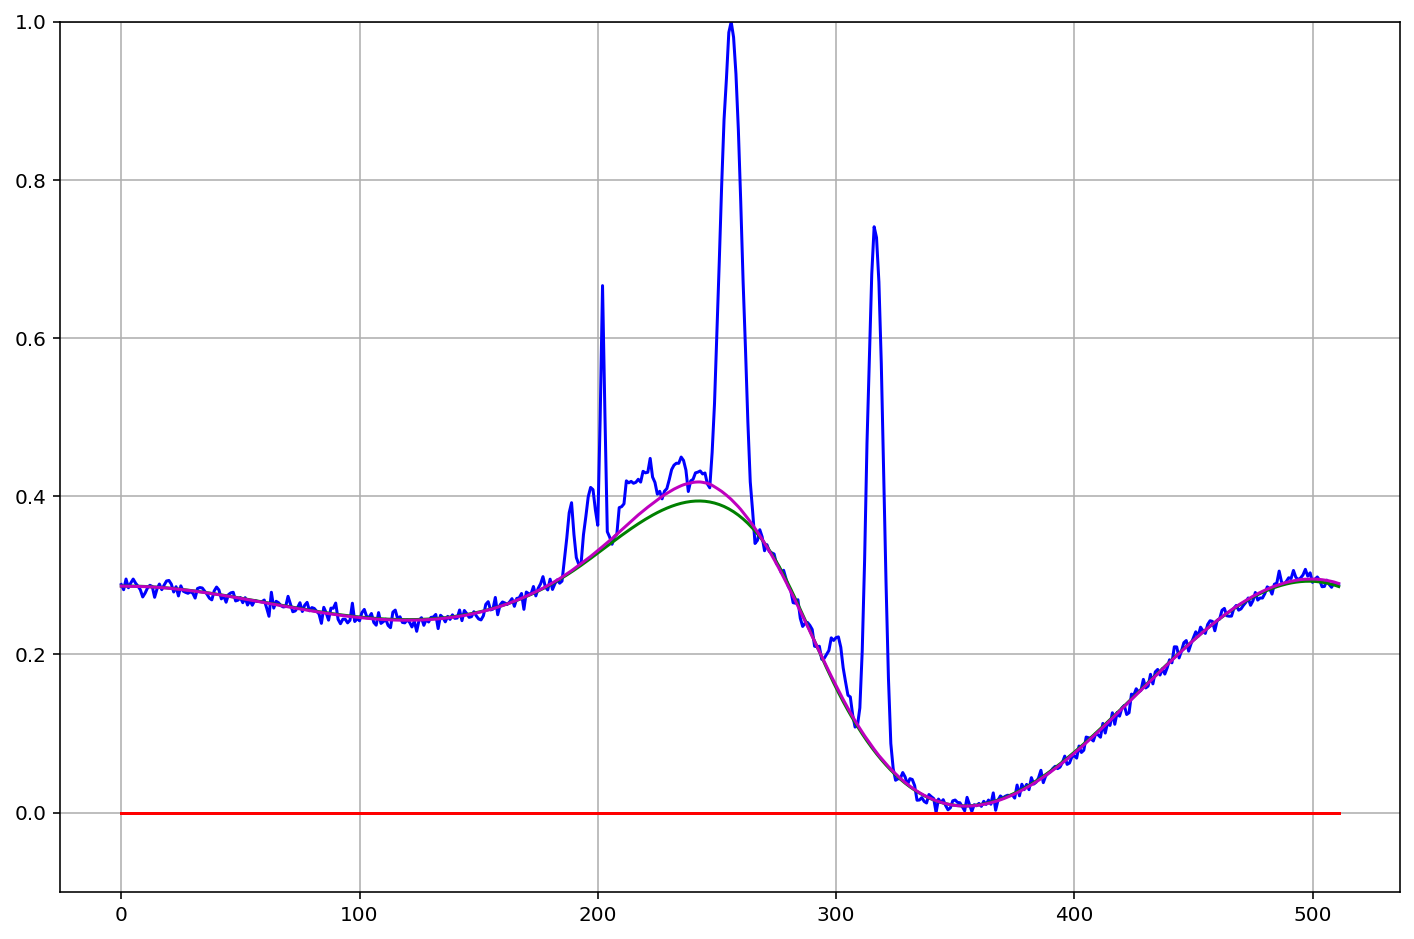

error=0.0026698452420532703
42547


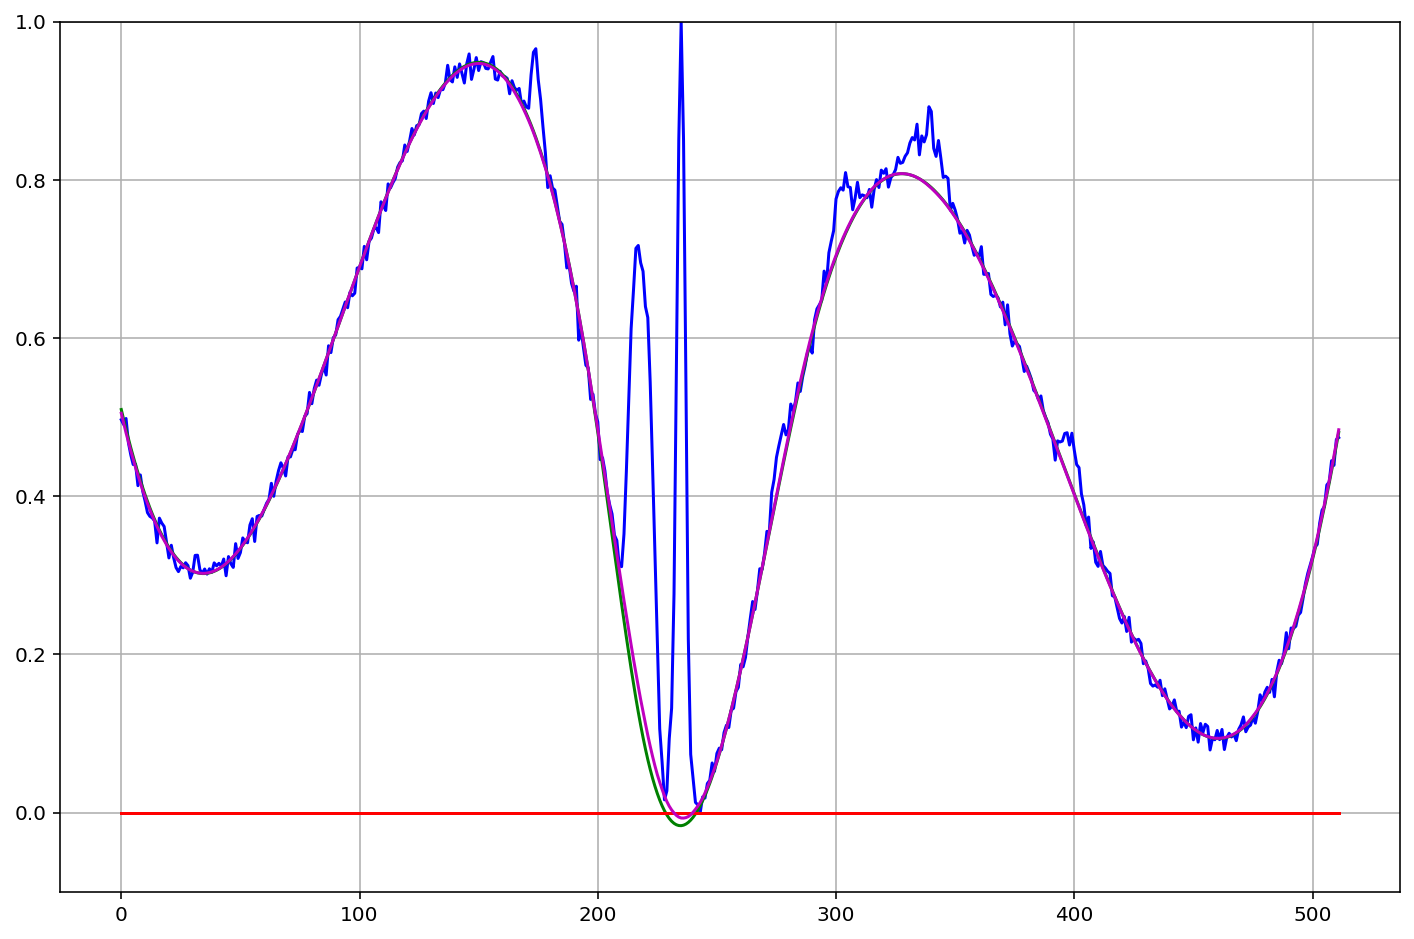

error=0.0025542406365275383
57669


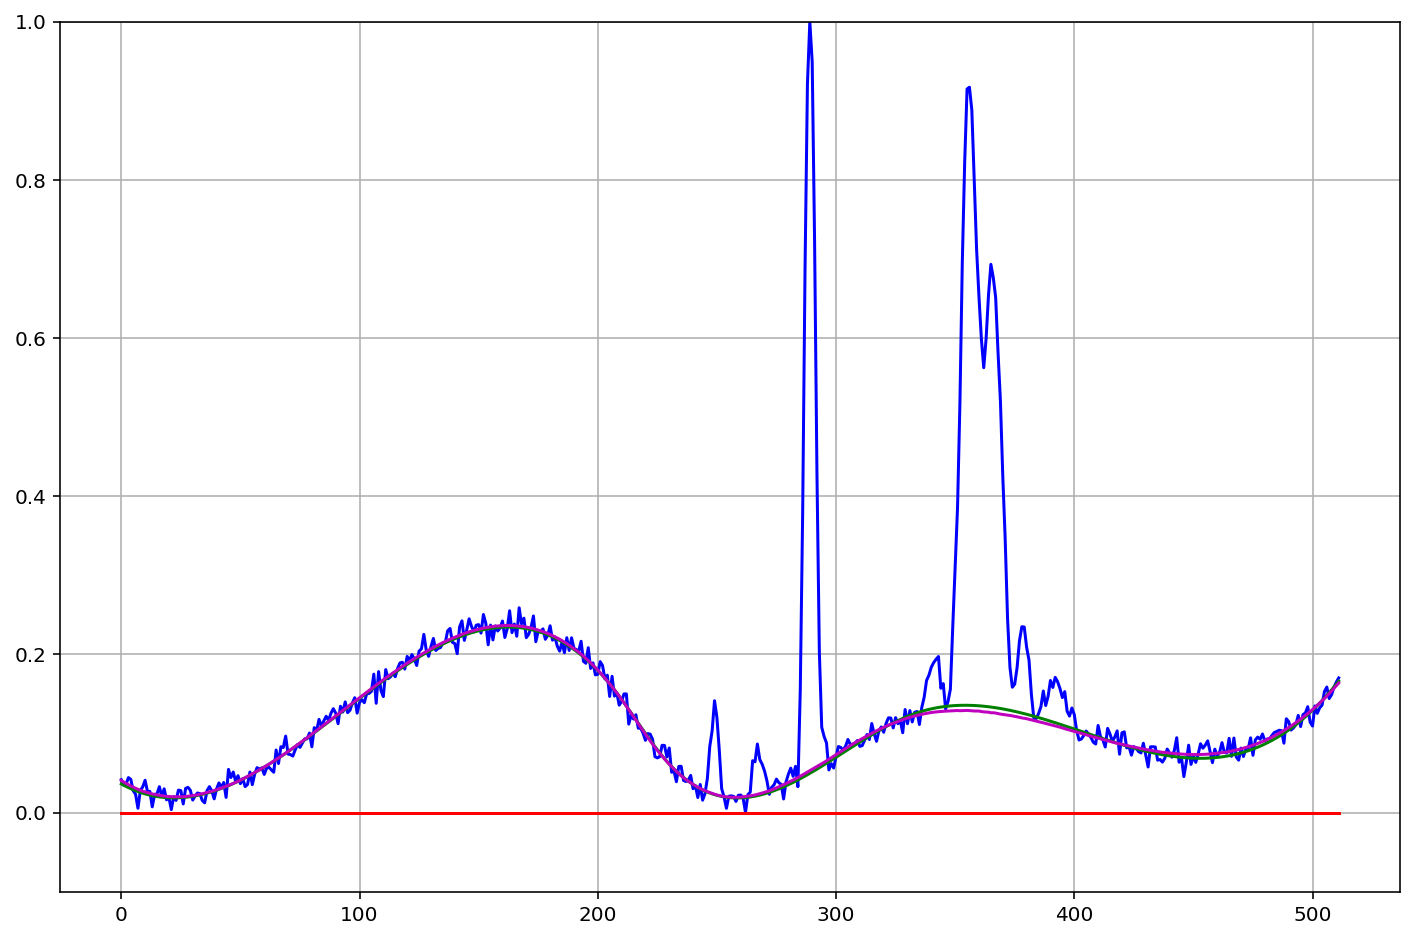

error=0.0022610716987401247
4917


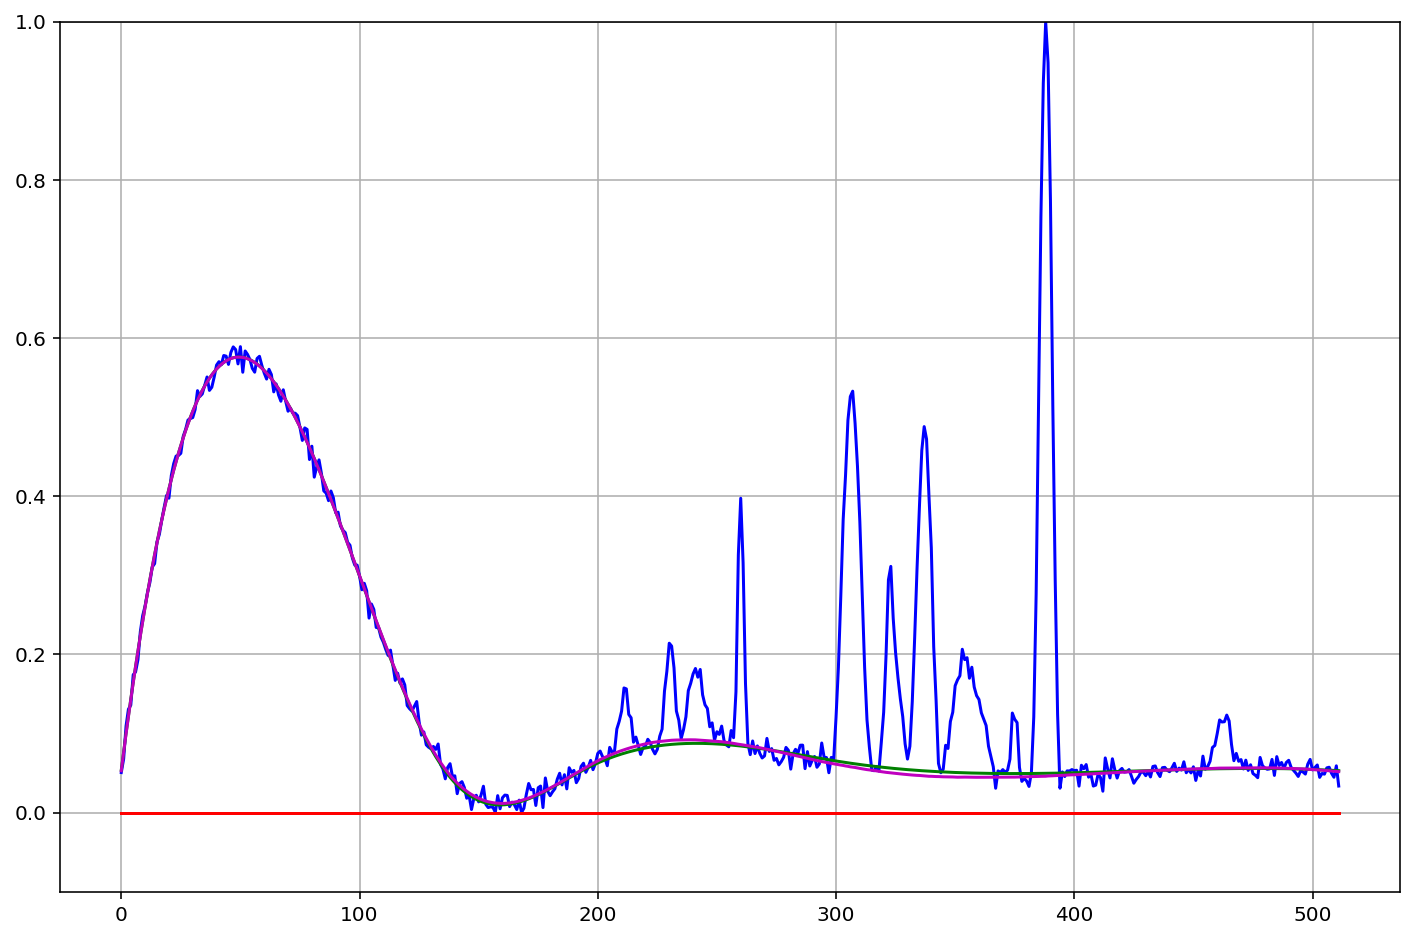

error=0.002112876158207655
67561


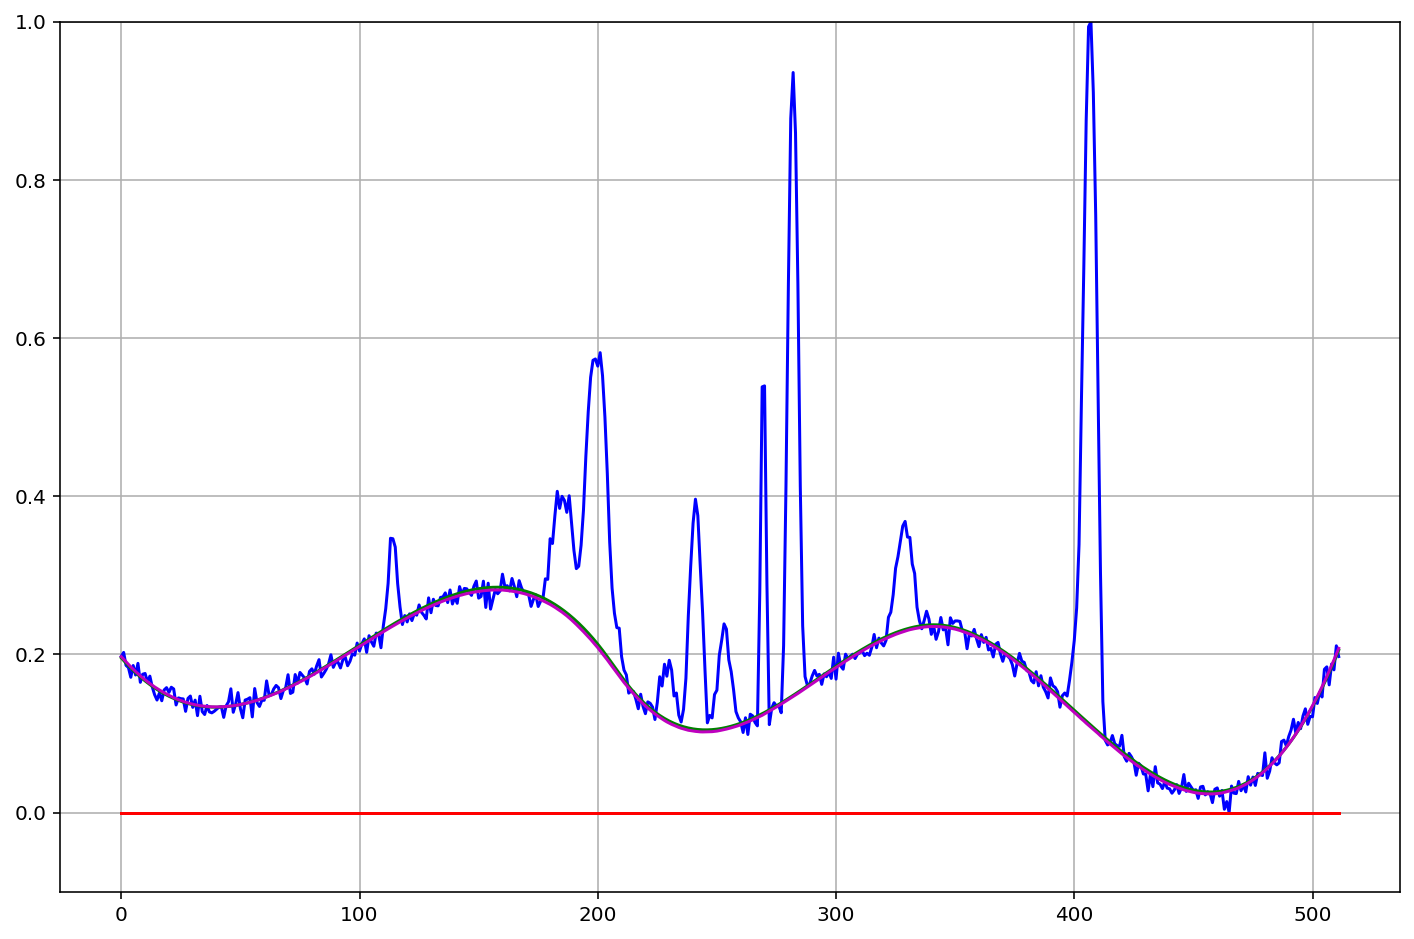

error=0.002070613671094179
64745


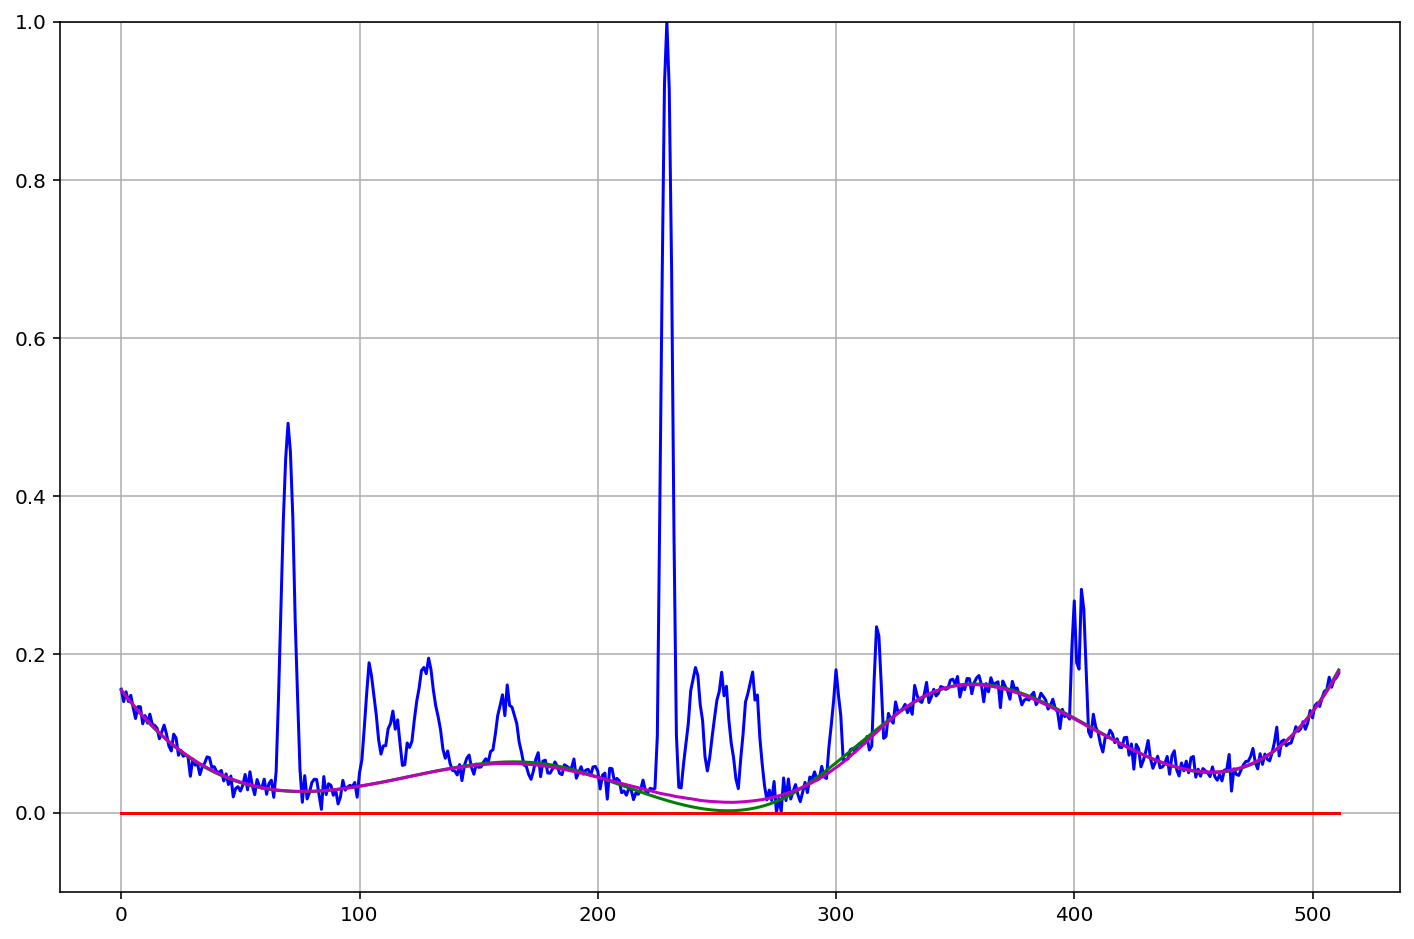

error=0.0020673328544944525
43097


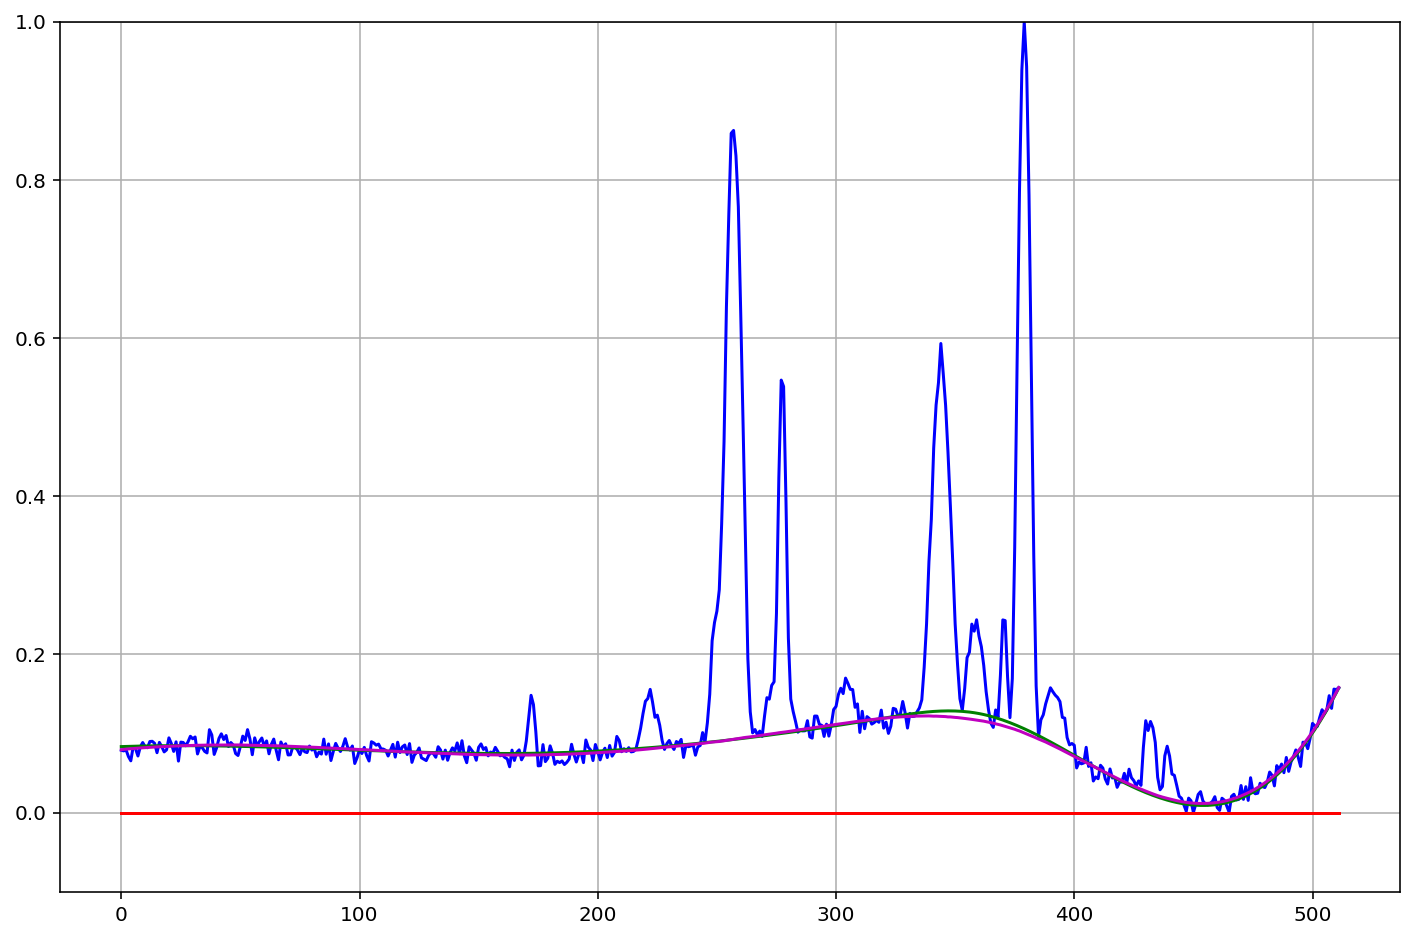

error=0.002040490508079529
16222


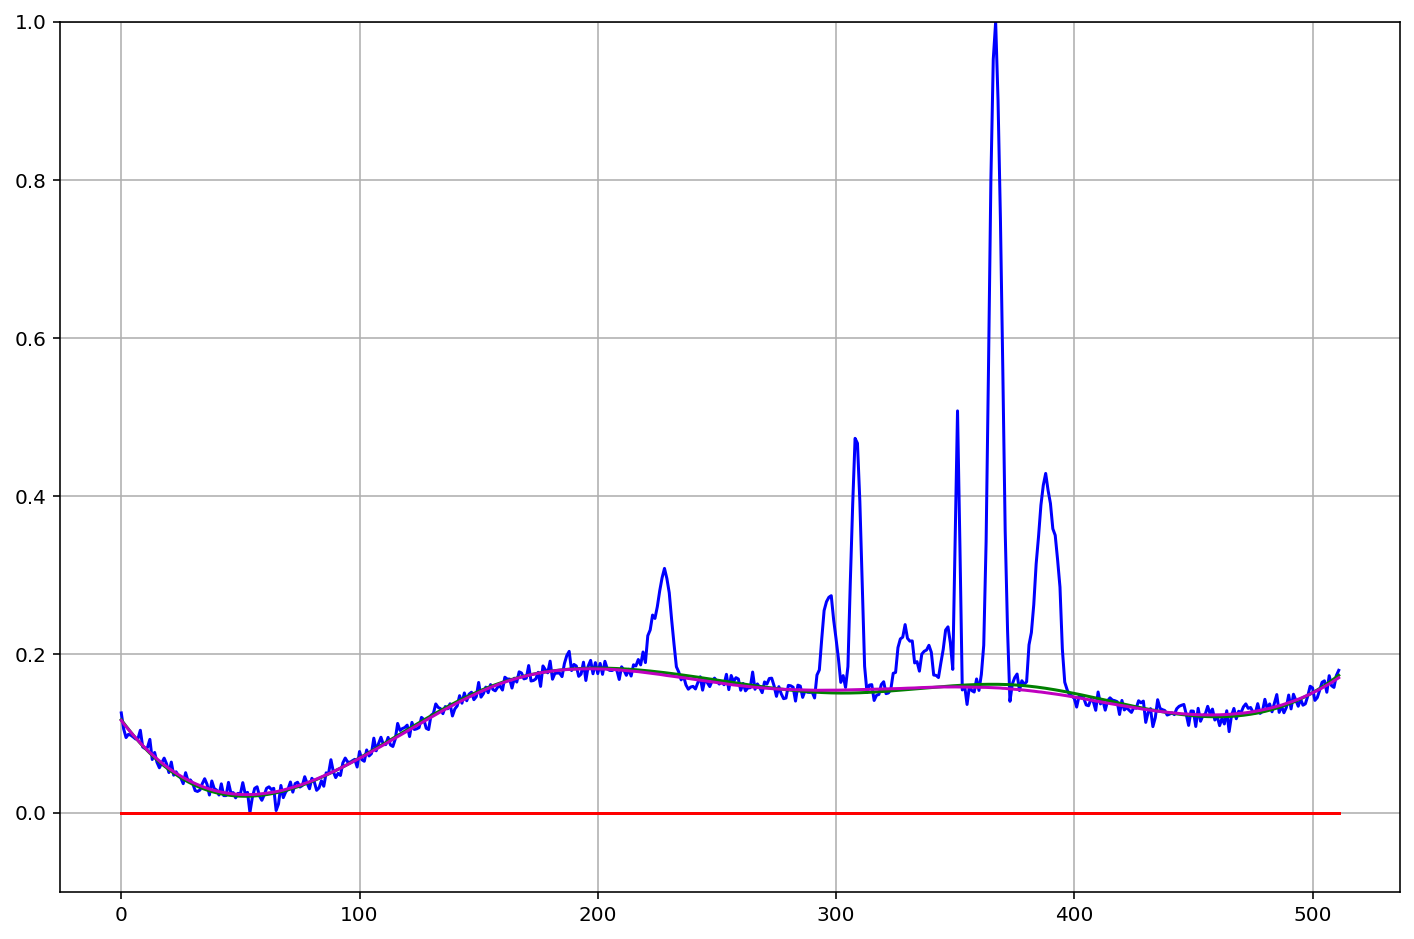

error=0.0020350259728729725
30348


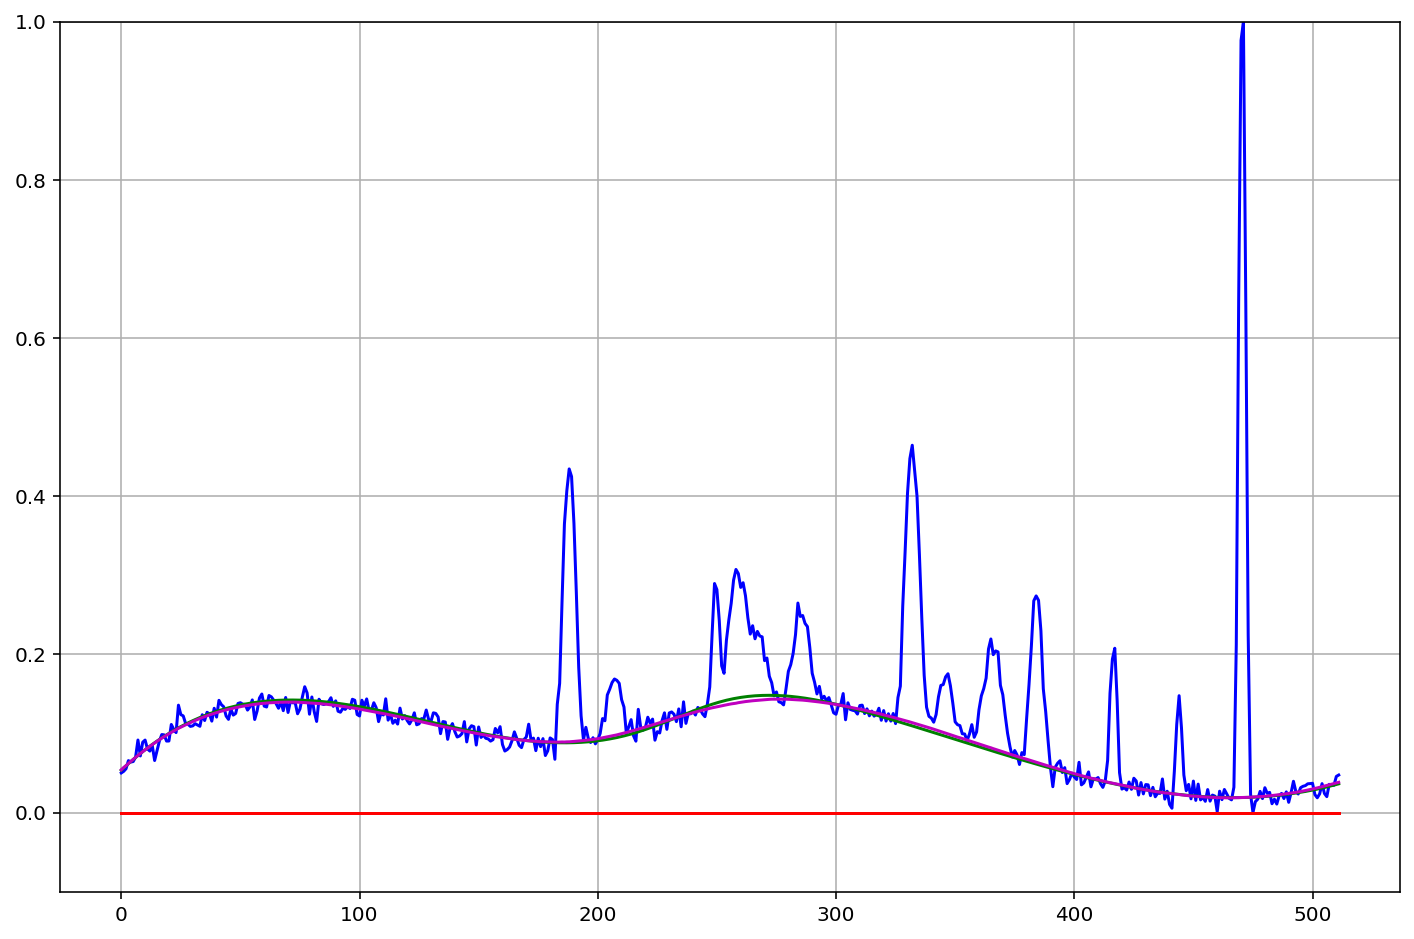

error=0.002010796219110489
35890


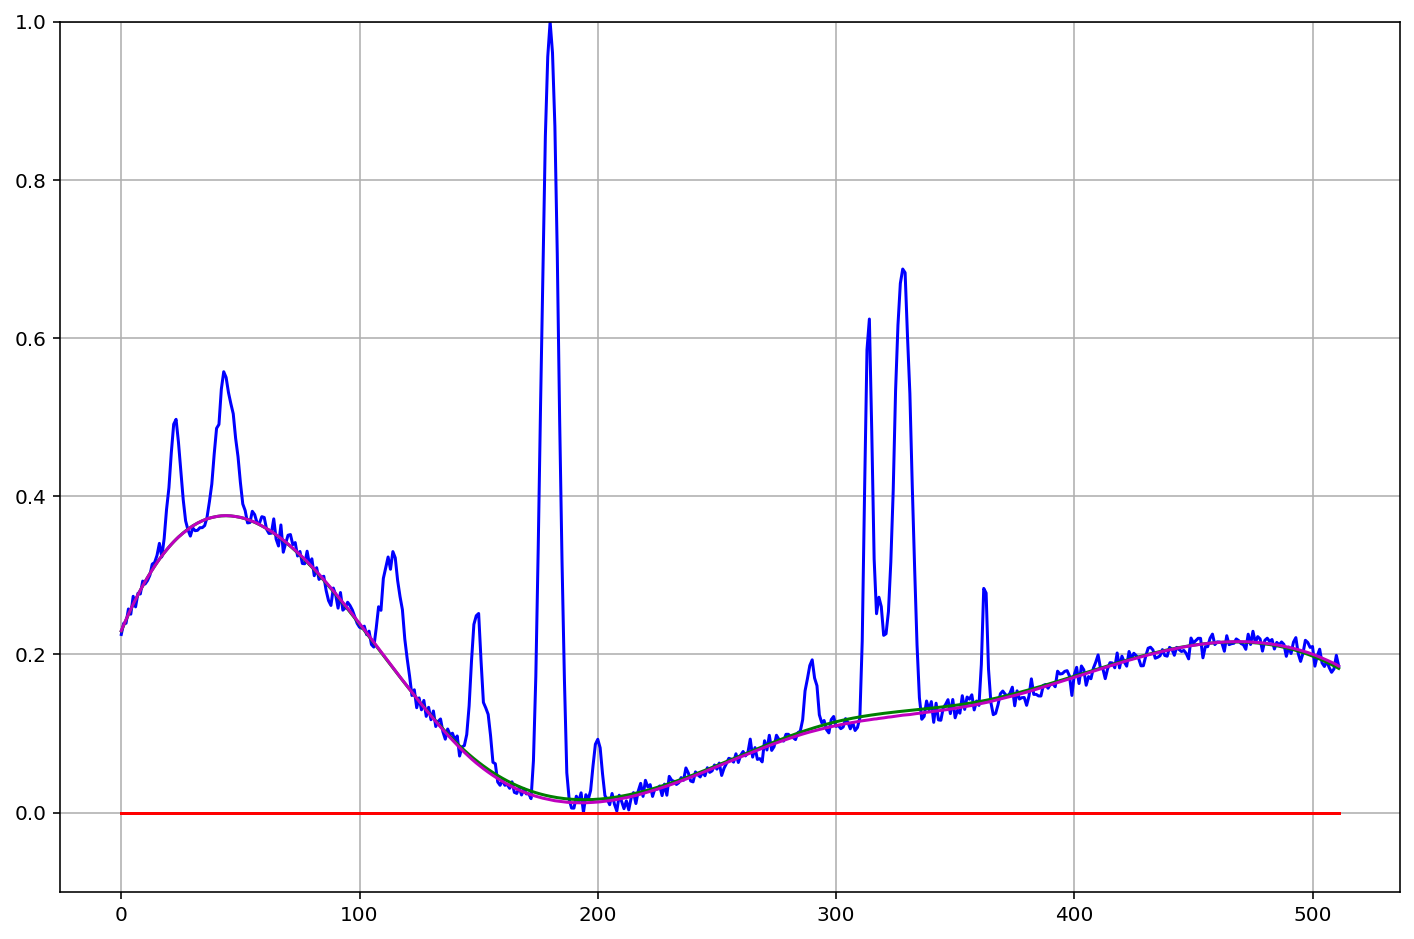

error=0.0020012801978737116
55836


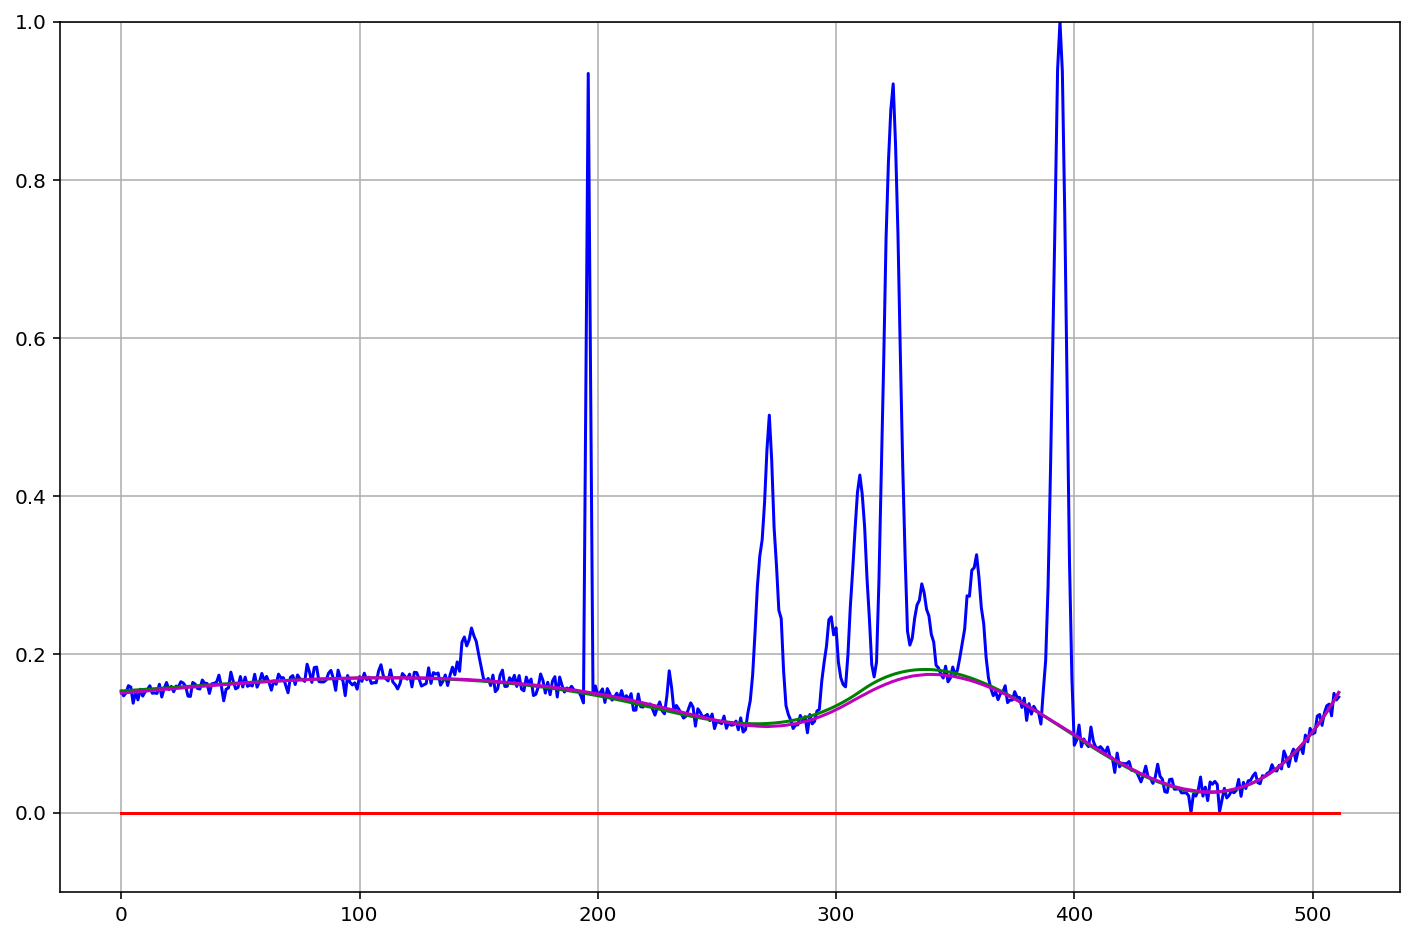

error=0.001942185452207923
64822


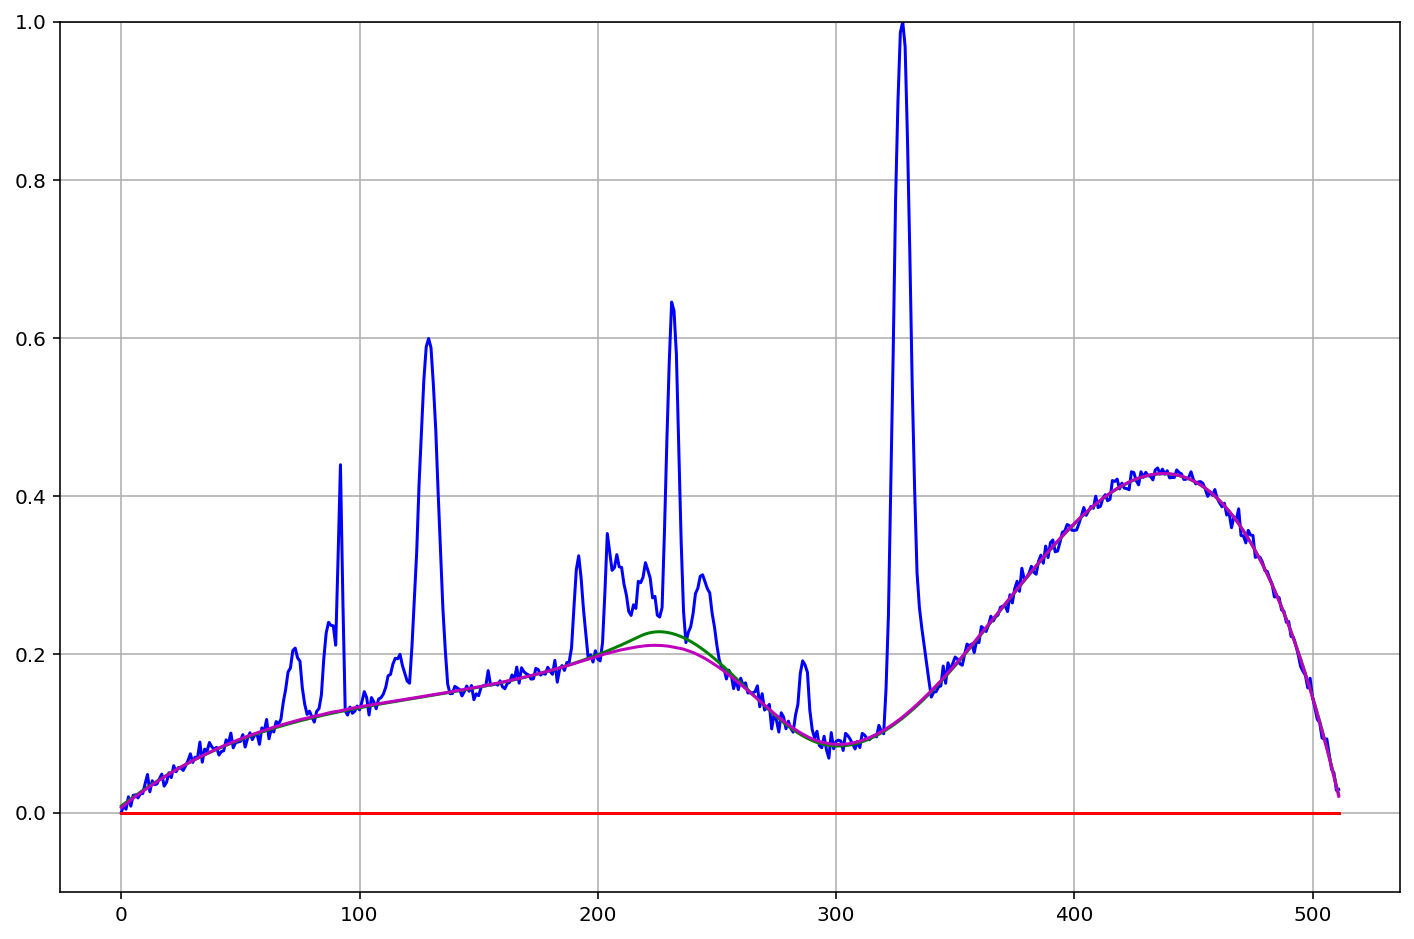

error=0.0019369297660887241
63159


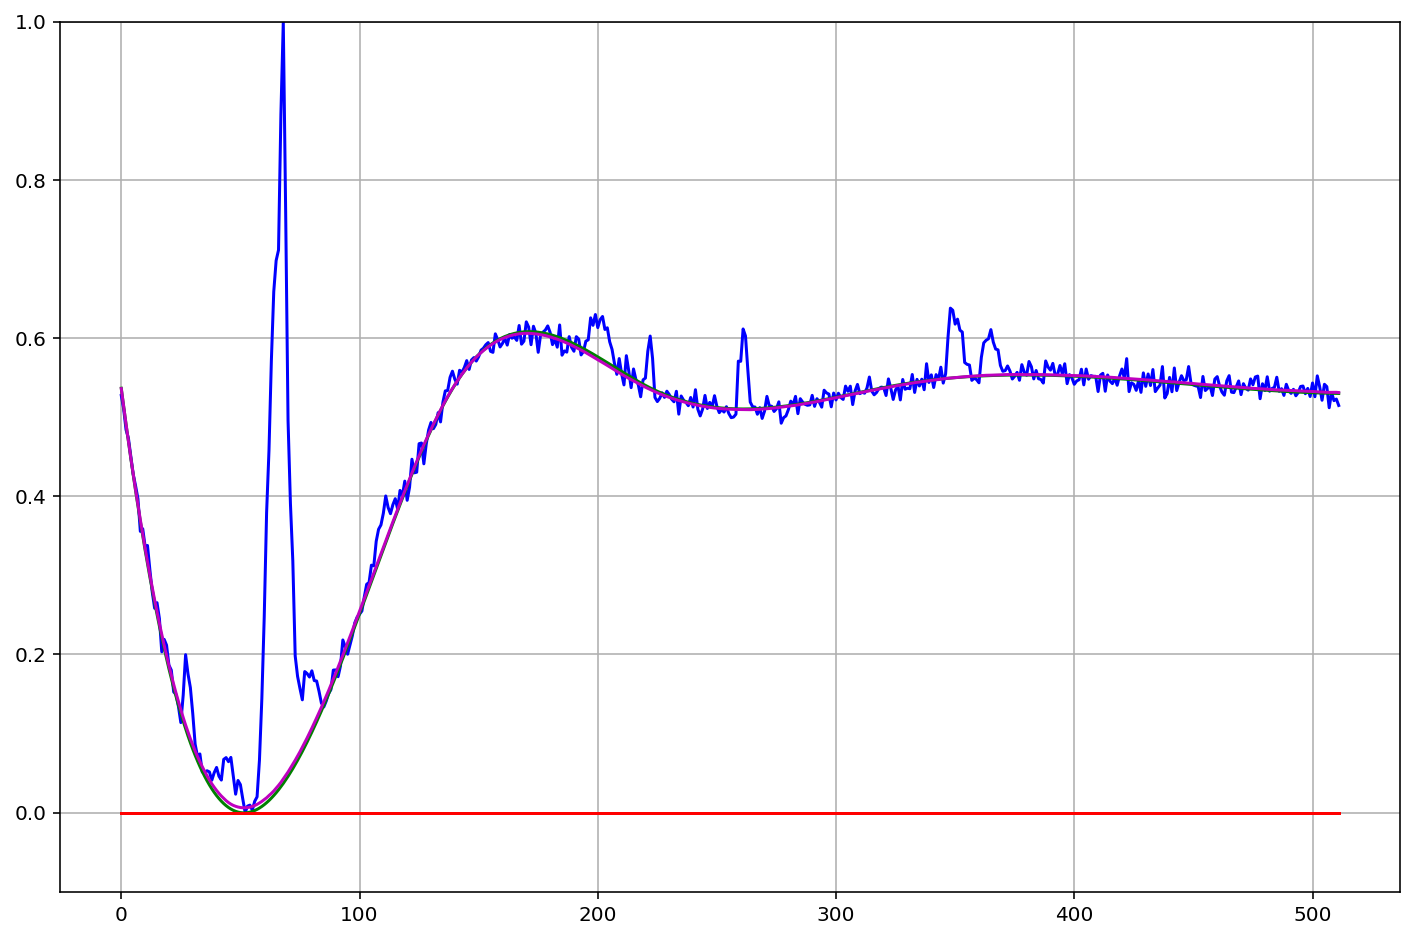

error=0.0019204702693969011


In [14]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

#%matplotlib tk
#%matplotlib inline

#plt.rcParams["figure.figsize"] = (8,6)
orderScore_valid=np.flip(np.argsort(outScore_valid))
for idx in orderScore_valid[:13]:
    print(idx)
    dataZ=validZZ[idx];
    dataY=validYY[idx];
    plt.figure(figsize=(12,8))
    plt.ylim(-0.1,1)
    plt.plot(dataZ,'b')
    plt.plot(dataY,'g')            # draw the real baseline 
    #plt.plot(dataX-outputData[idx,:],'c')      # draw peaks
    plt.plot(np.zeros((len(dataZ),1)),'r')
    plt.plot(outData_valid[idx],'m')  # draw the output baseline
    plt.grid(True)    
    plt.show()
    print(f'error={ np.mean(np.abs(dataY-outData_valid[idx])) }')


2455


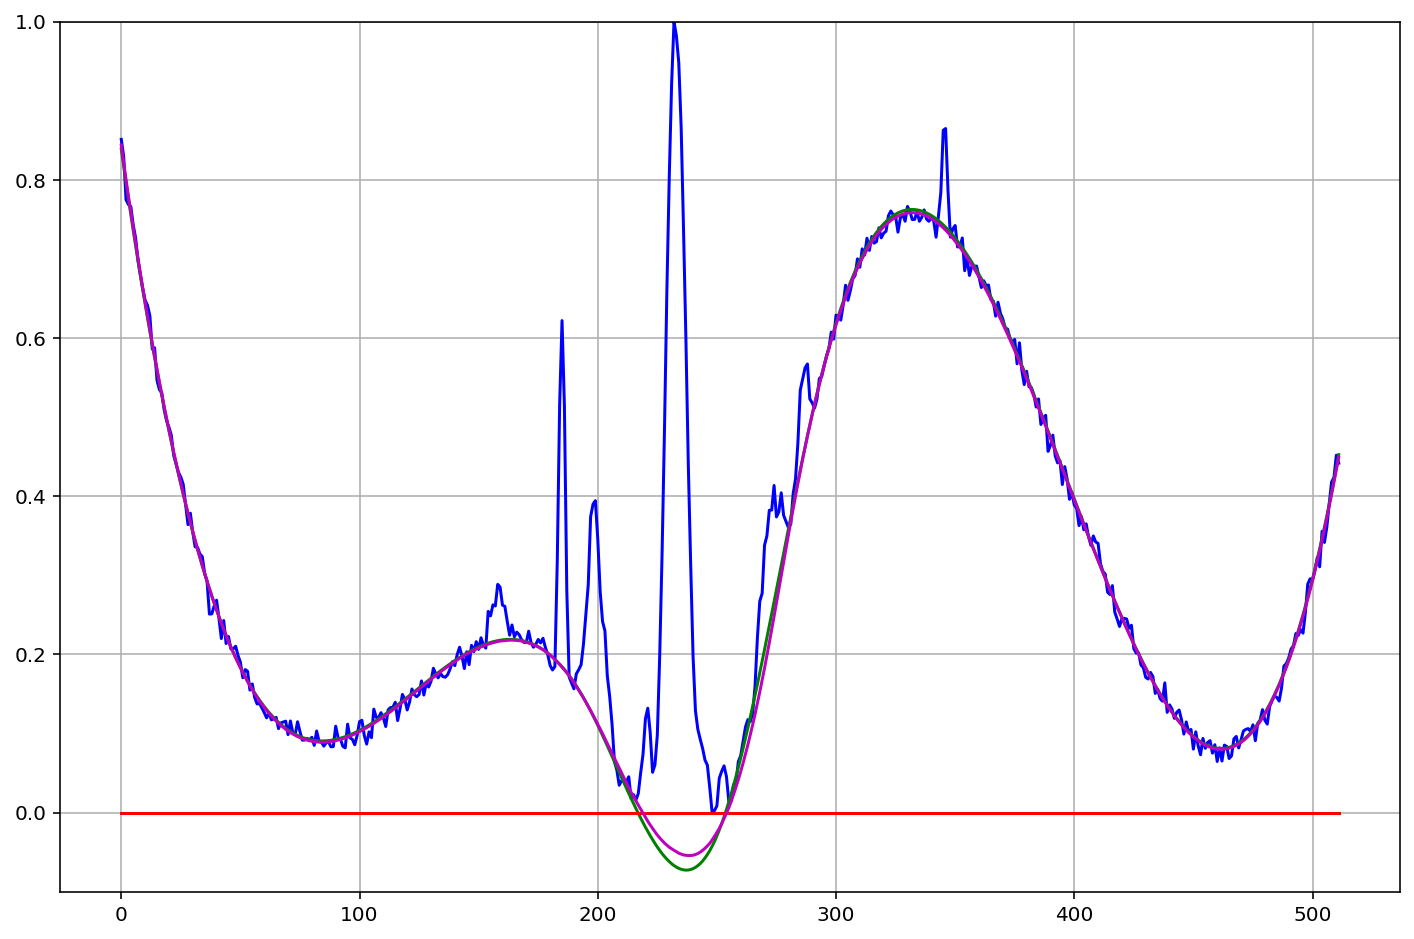

error=0.0034267224837094545
65834


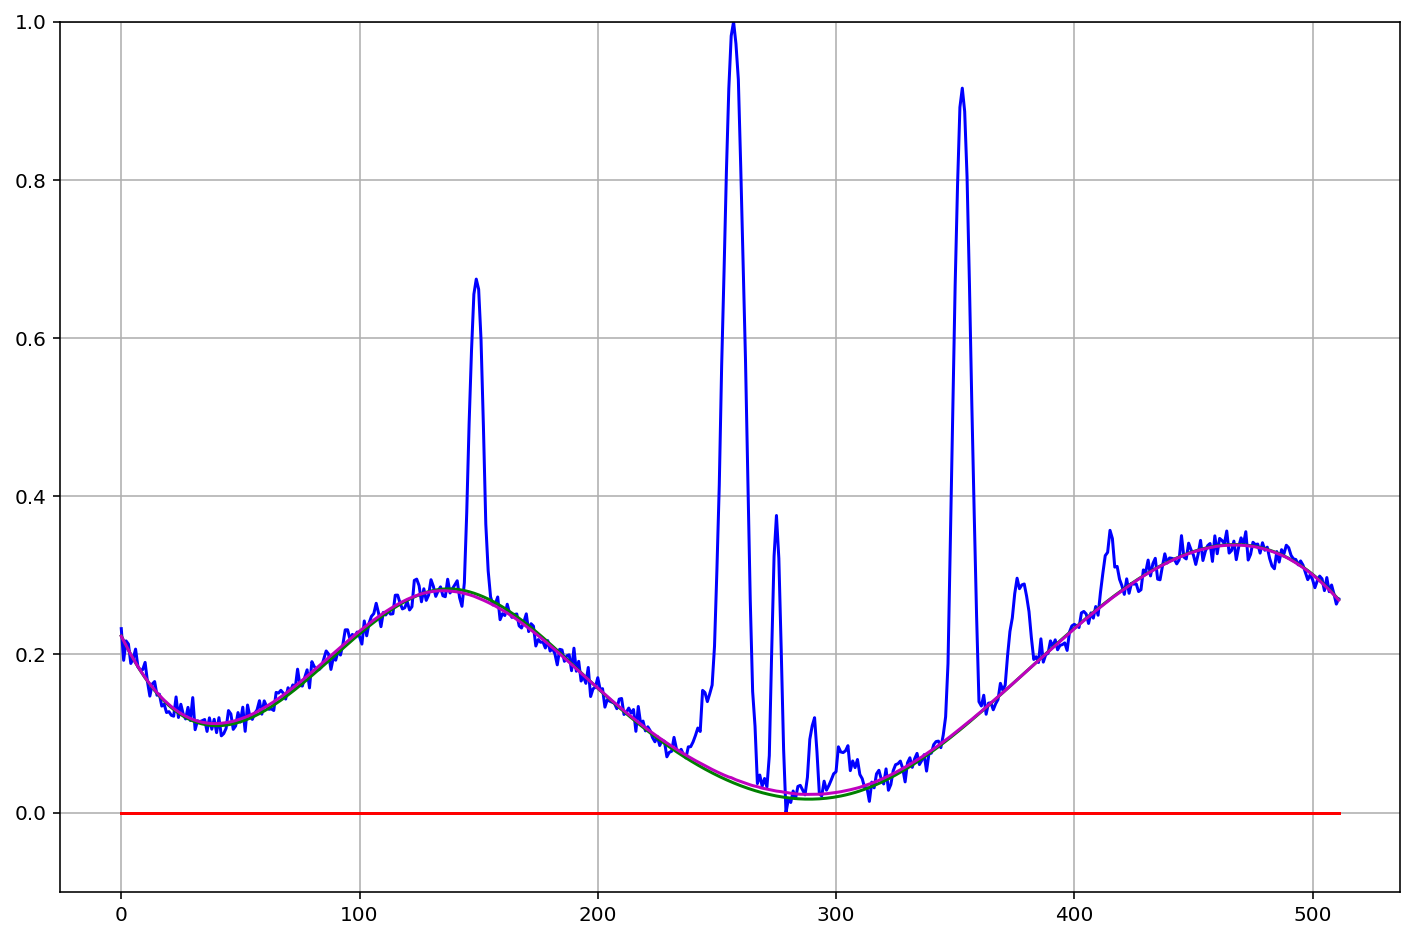

error=0.002291732933372259
48445


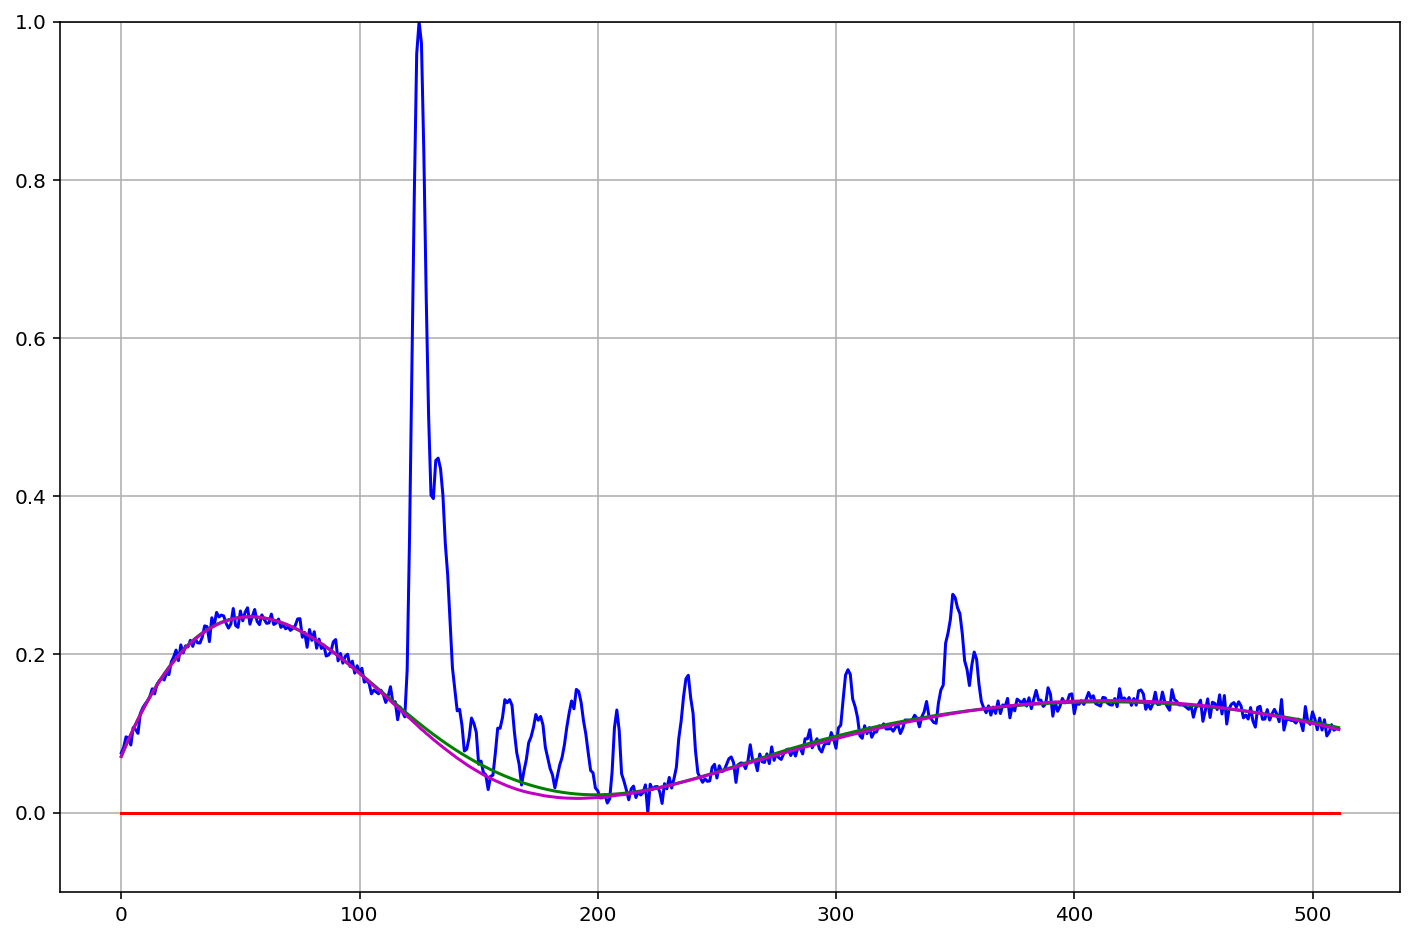

error=0.0022810993250459433
14656


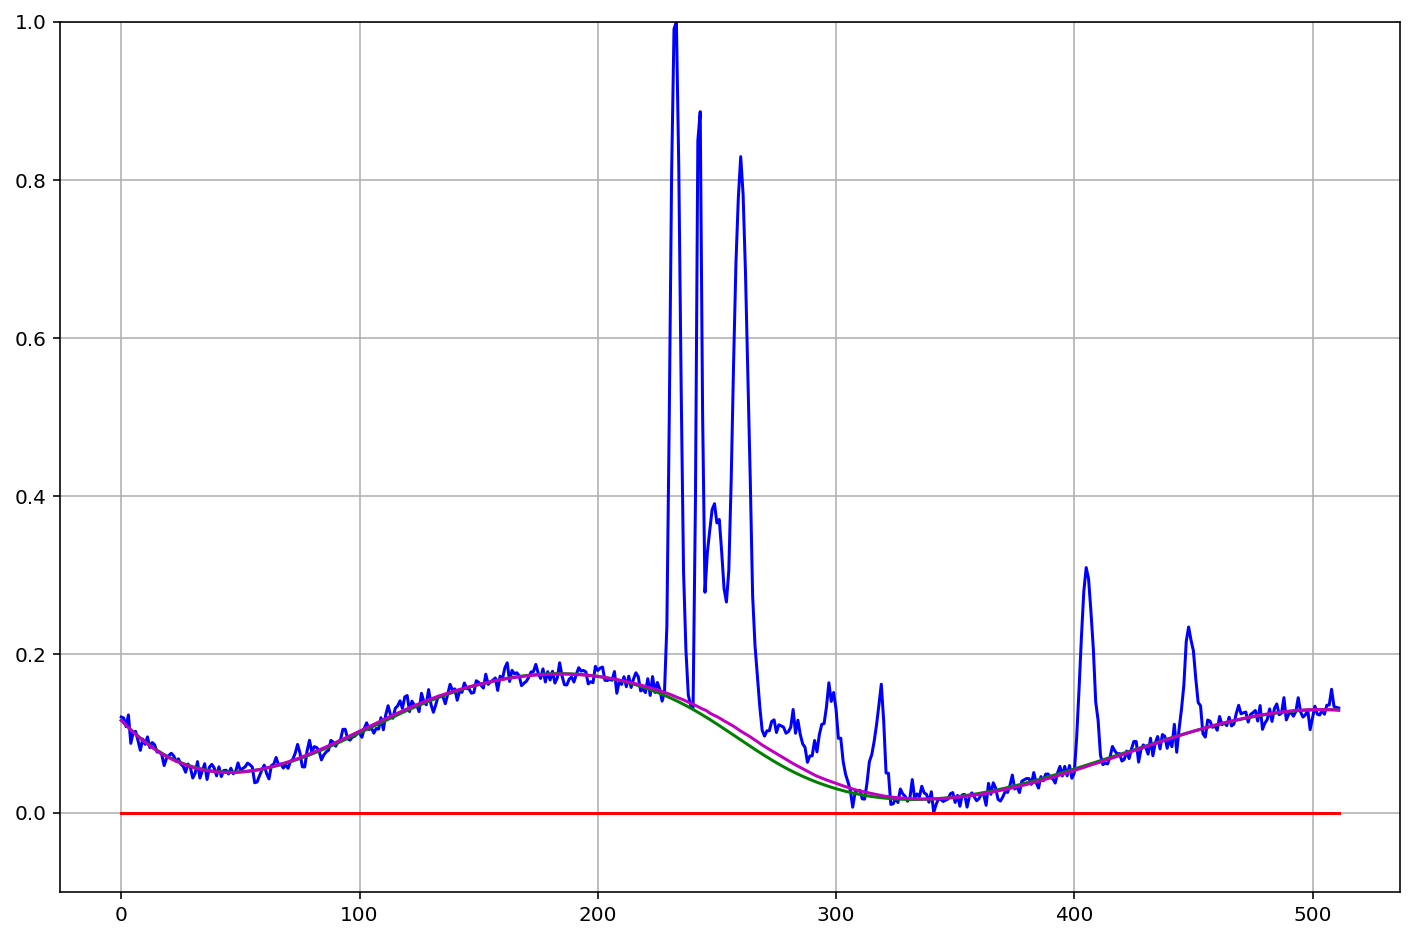

error=0.0022565722465515137
37580


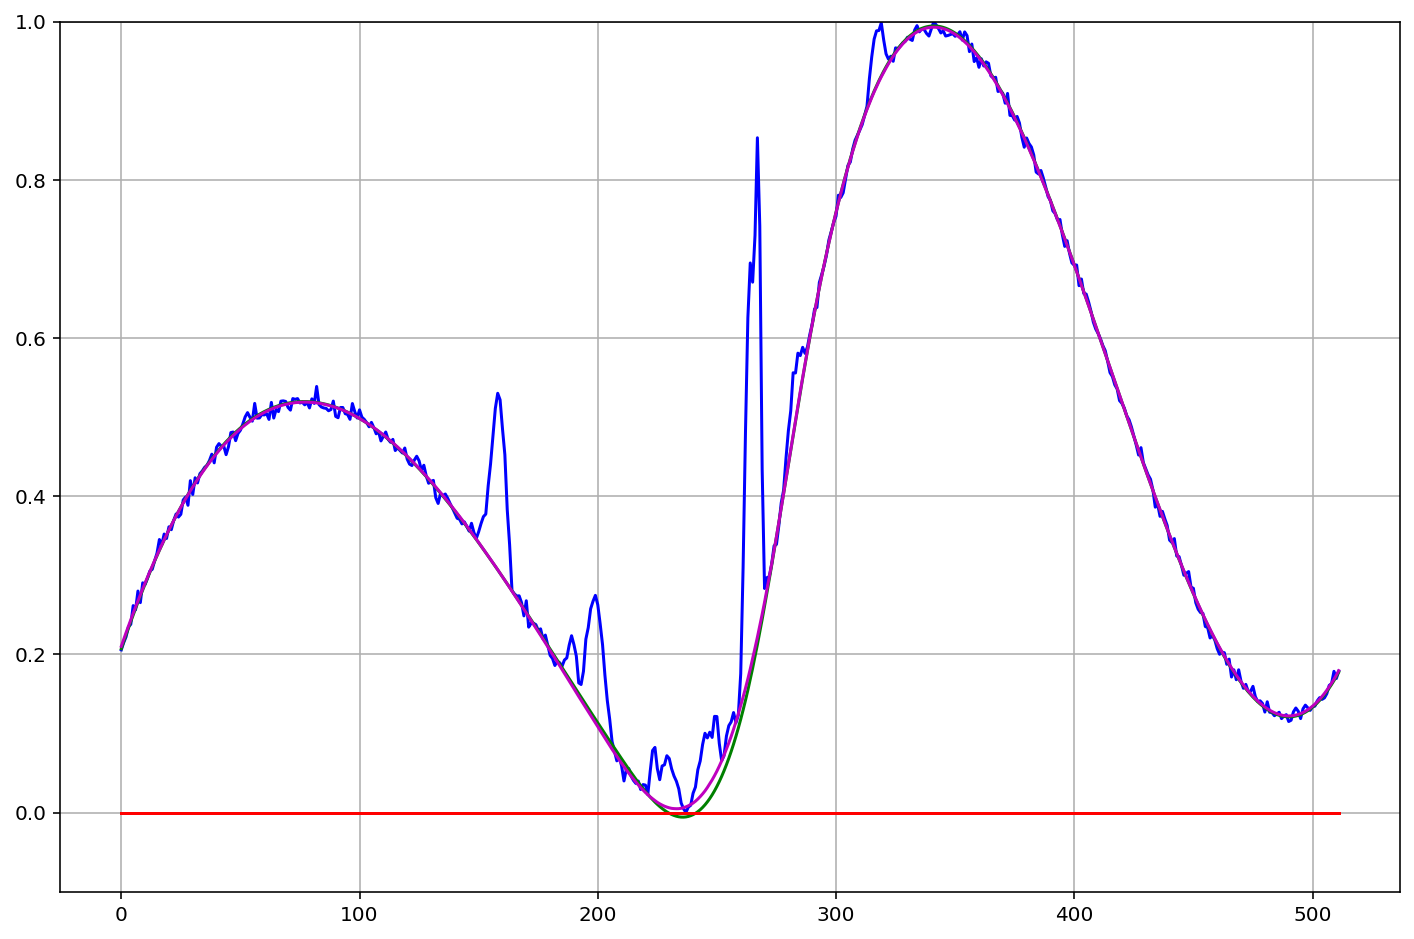

error=0.0021946558263152838
39589


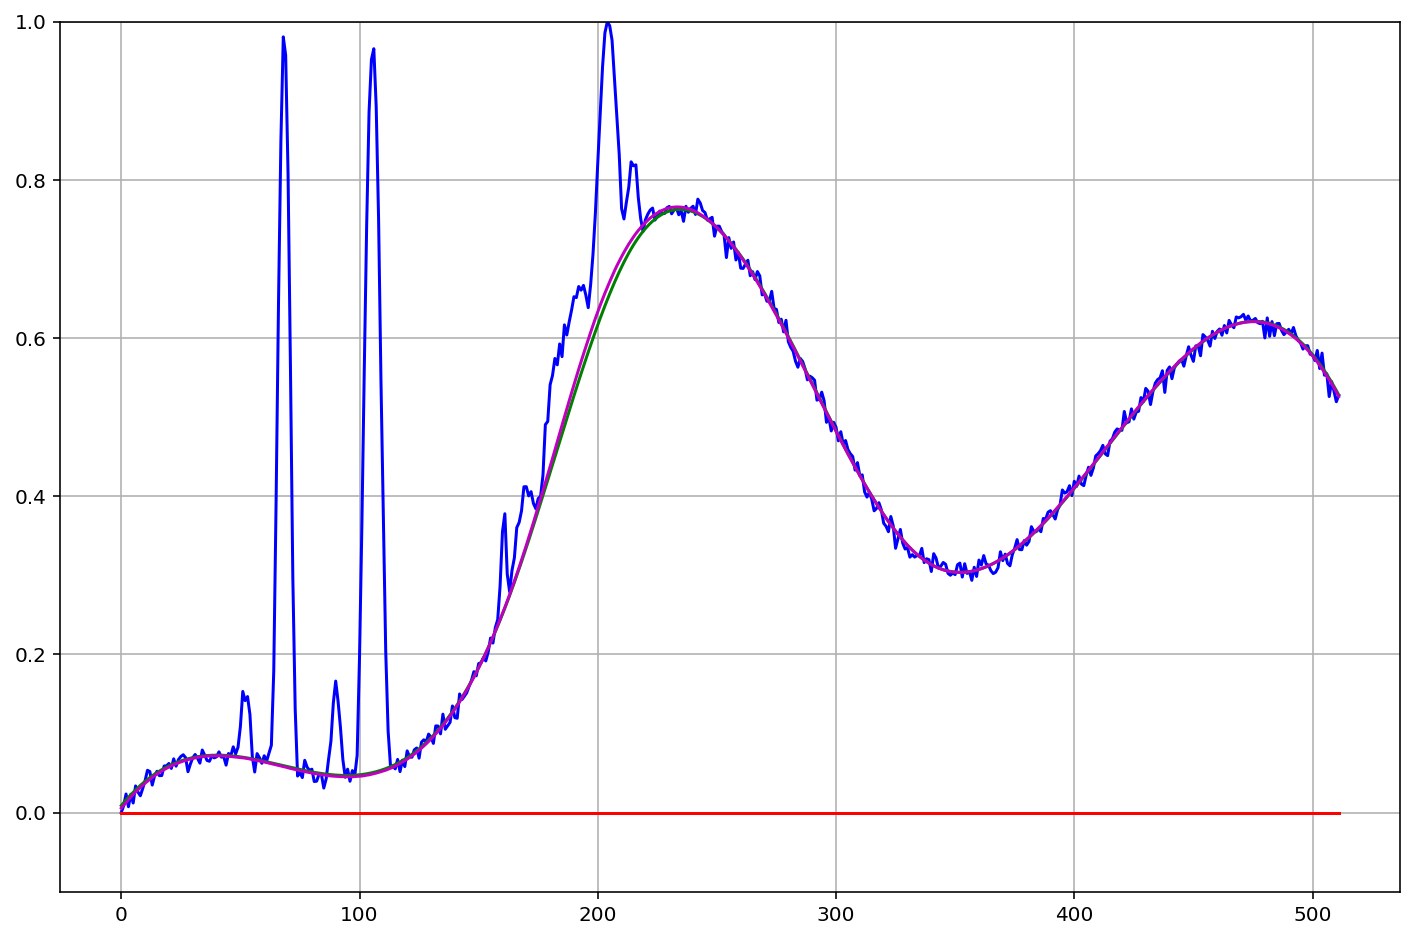

error=0.0021378793753683567
47249


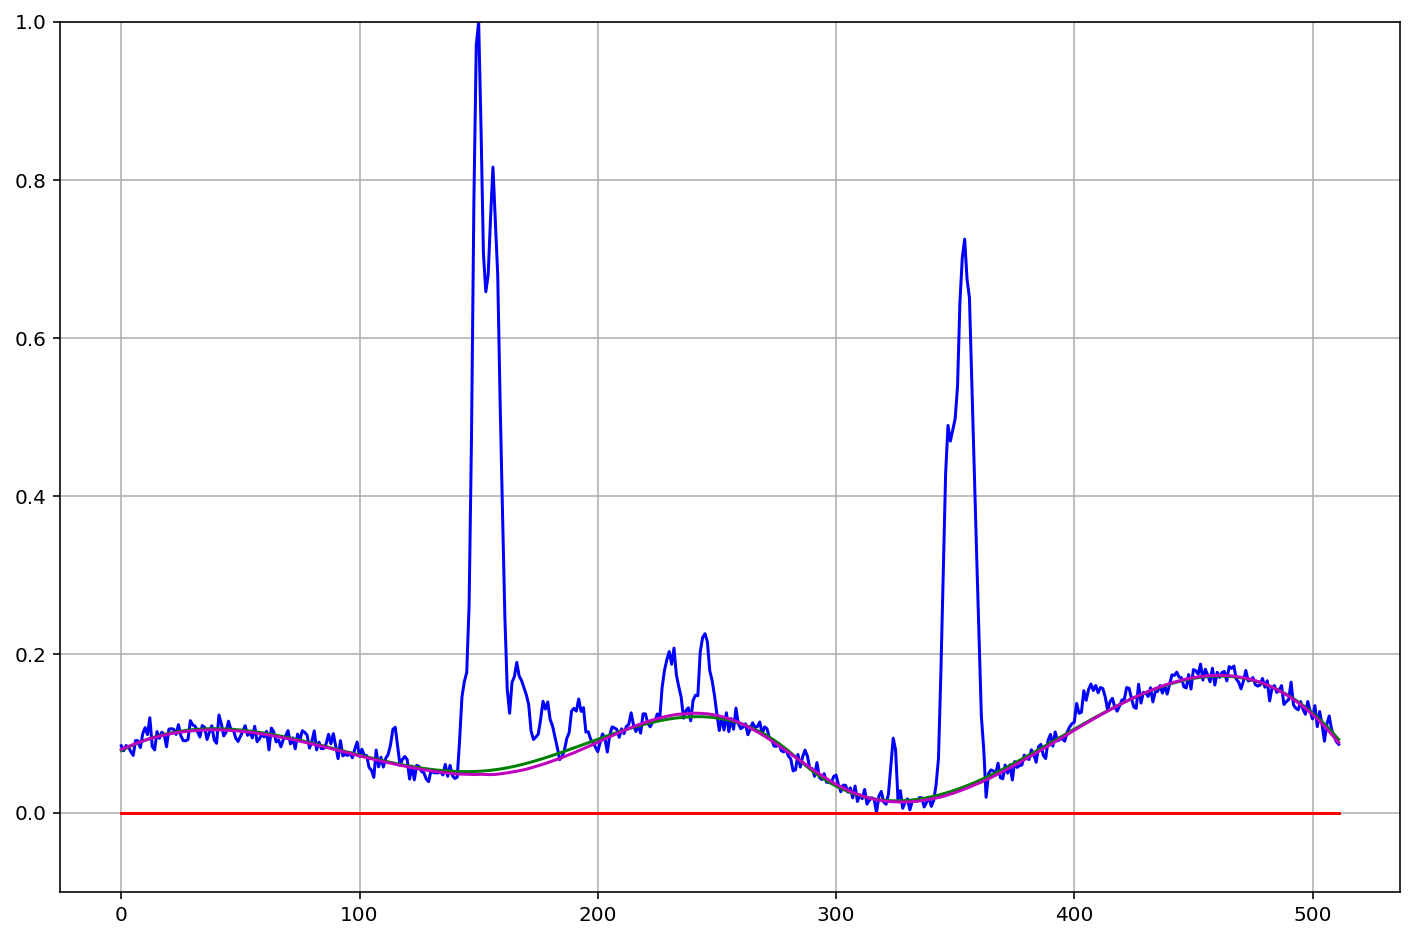

error=0.0020975882653146982
69974


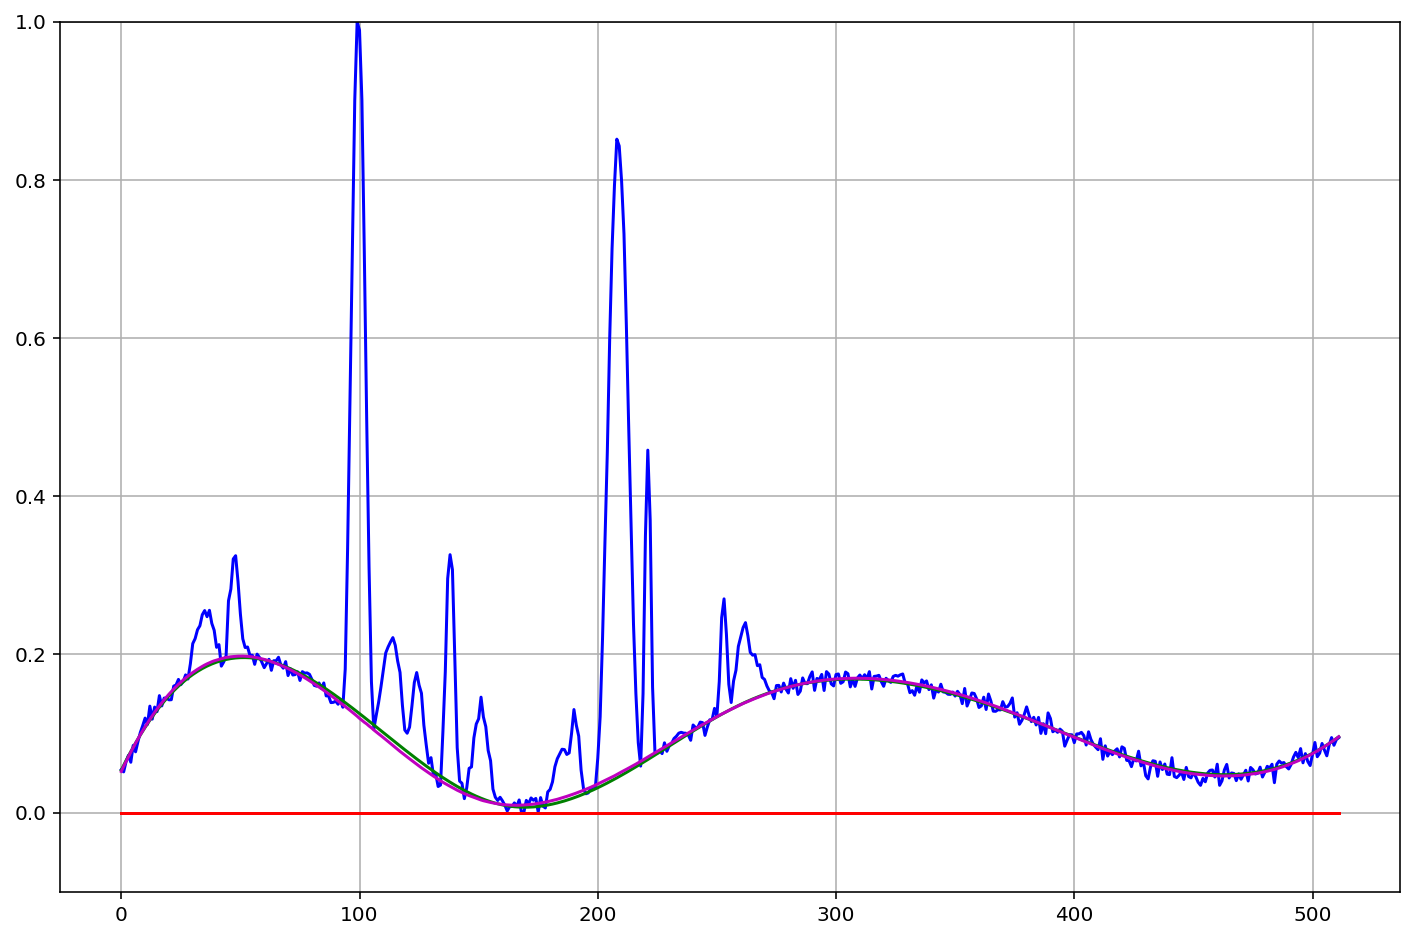

error=0.0020729335956275463
55618


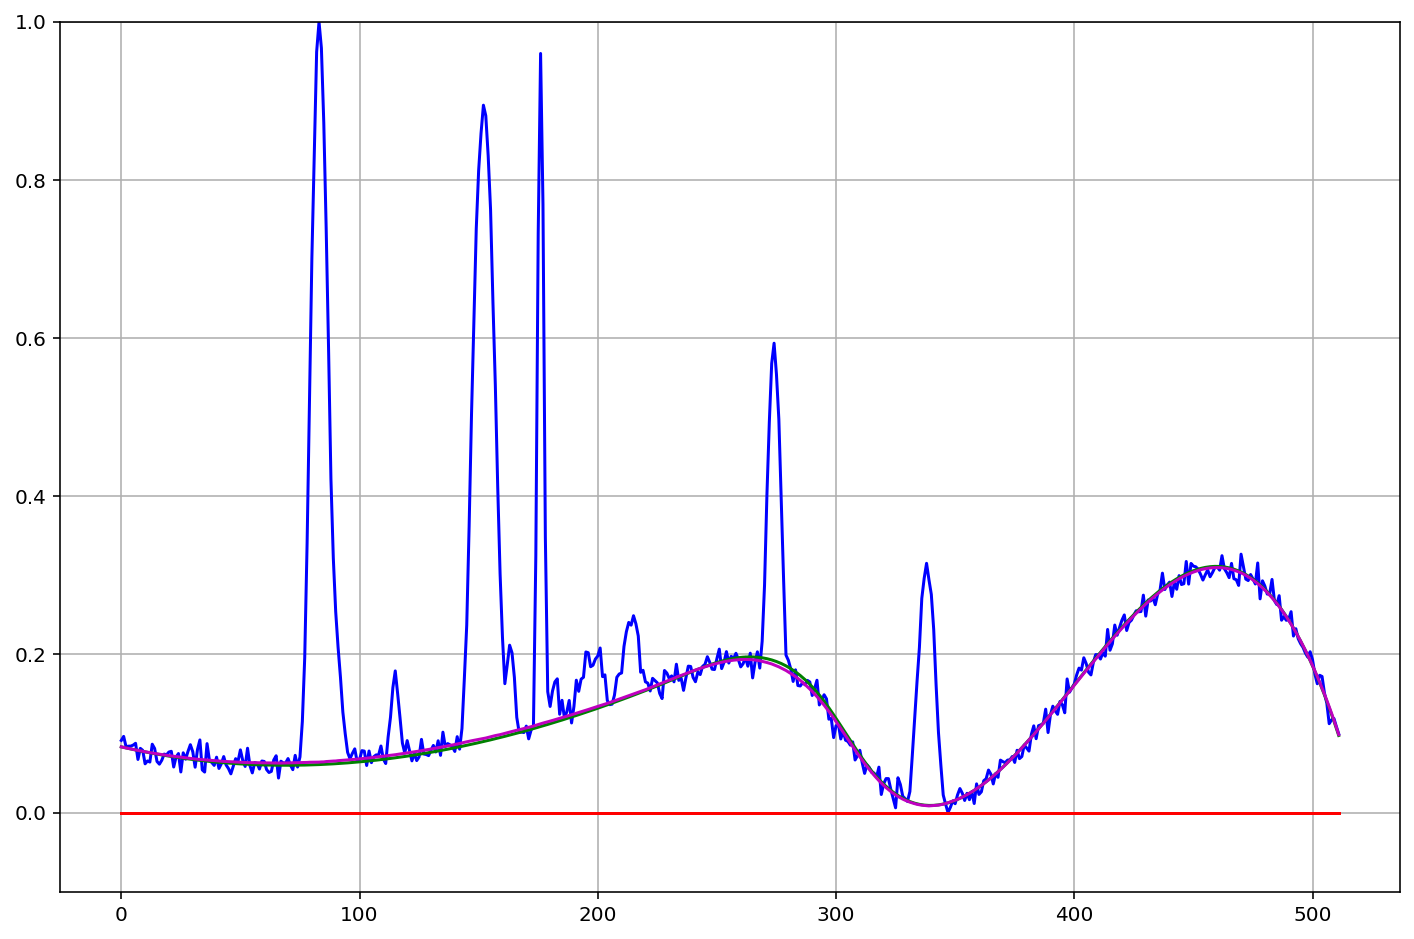

error=0.002046822104603052
30846


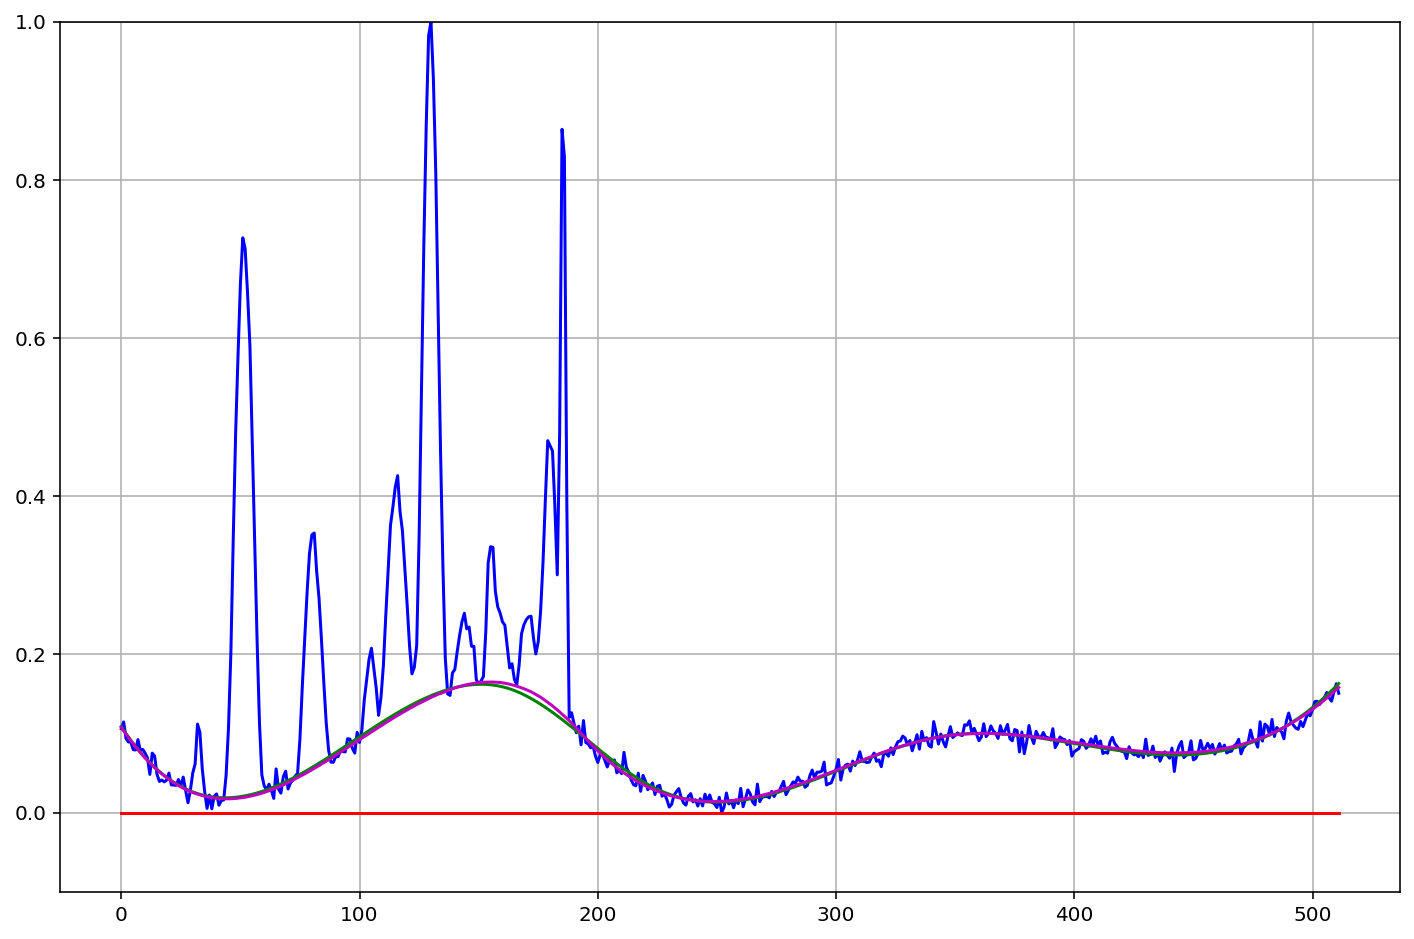

error=0.0020390748977661133
60218


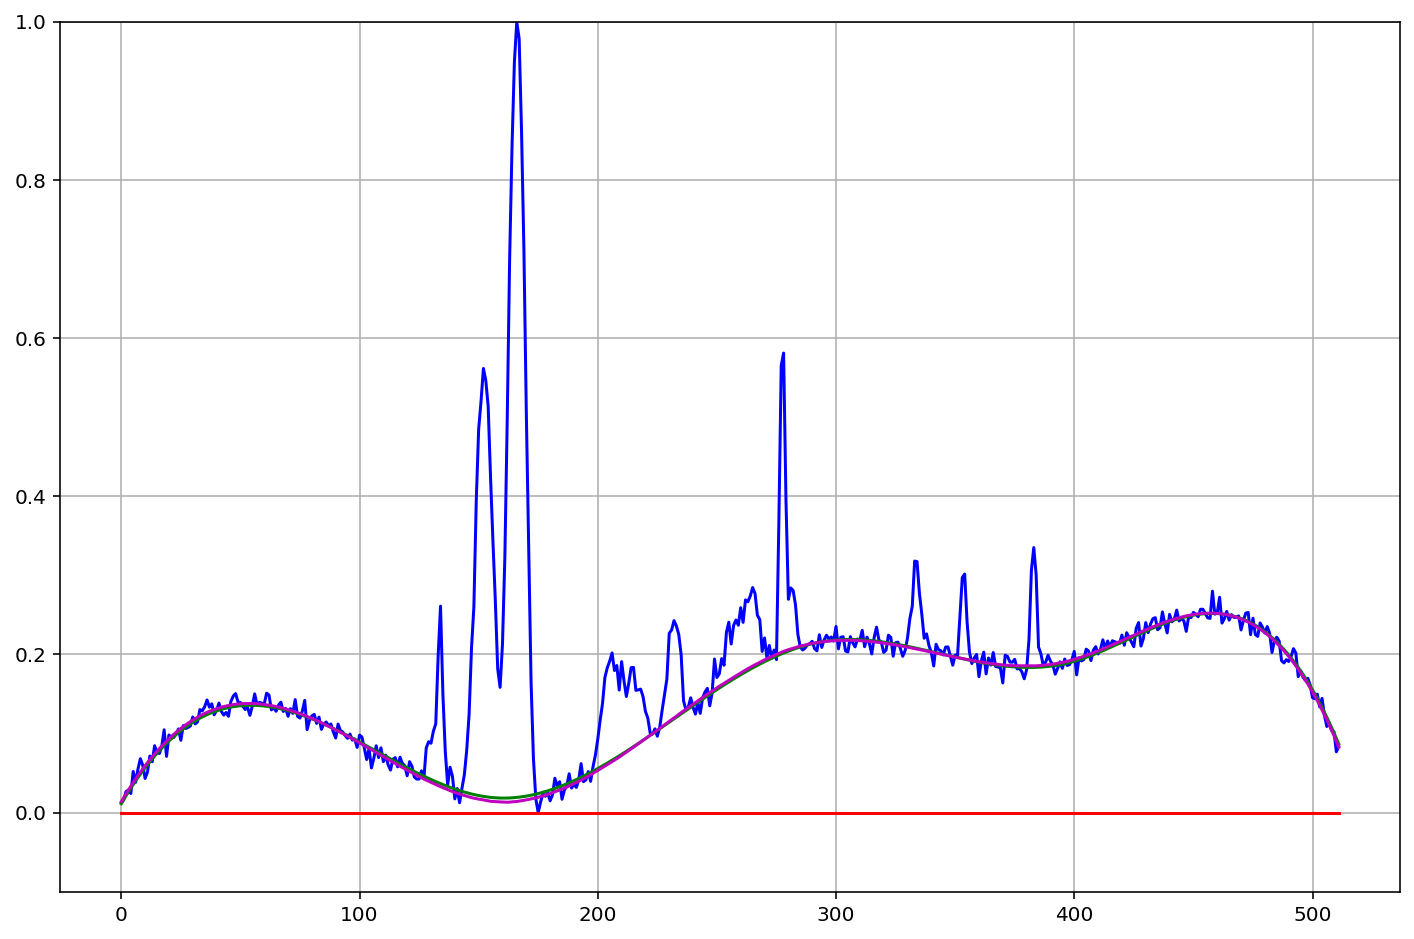

error=0.0019976869225502014
35346


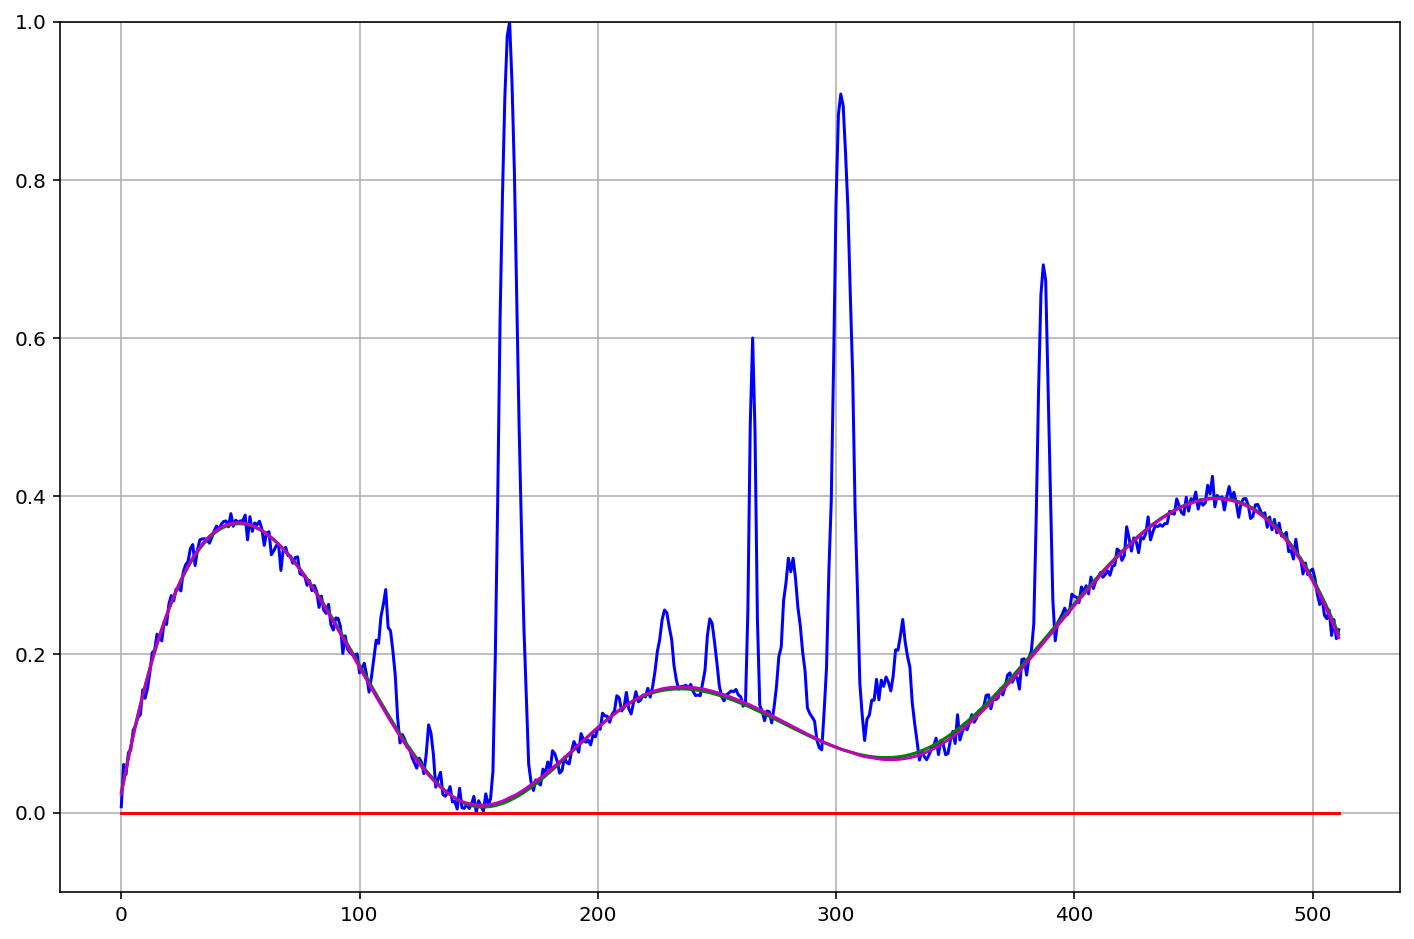

error=0.0019922167994081974
49447


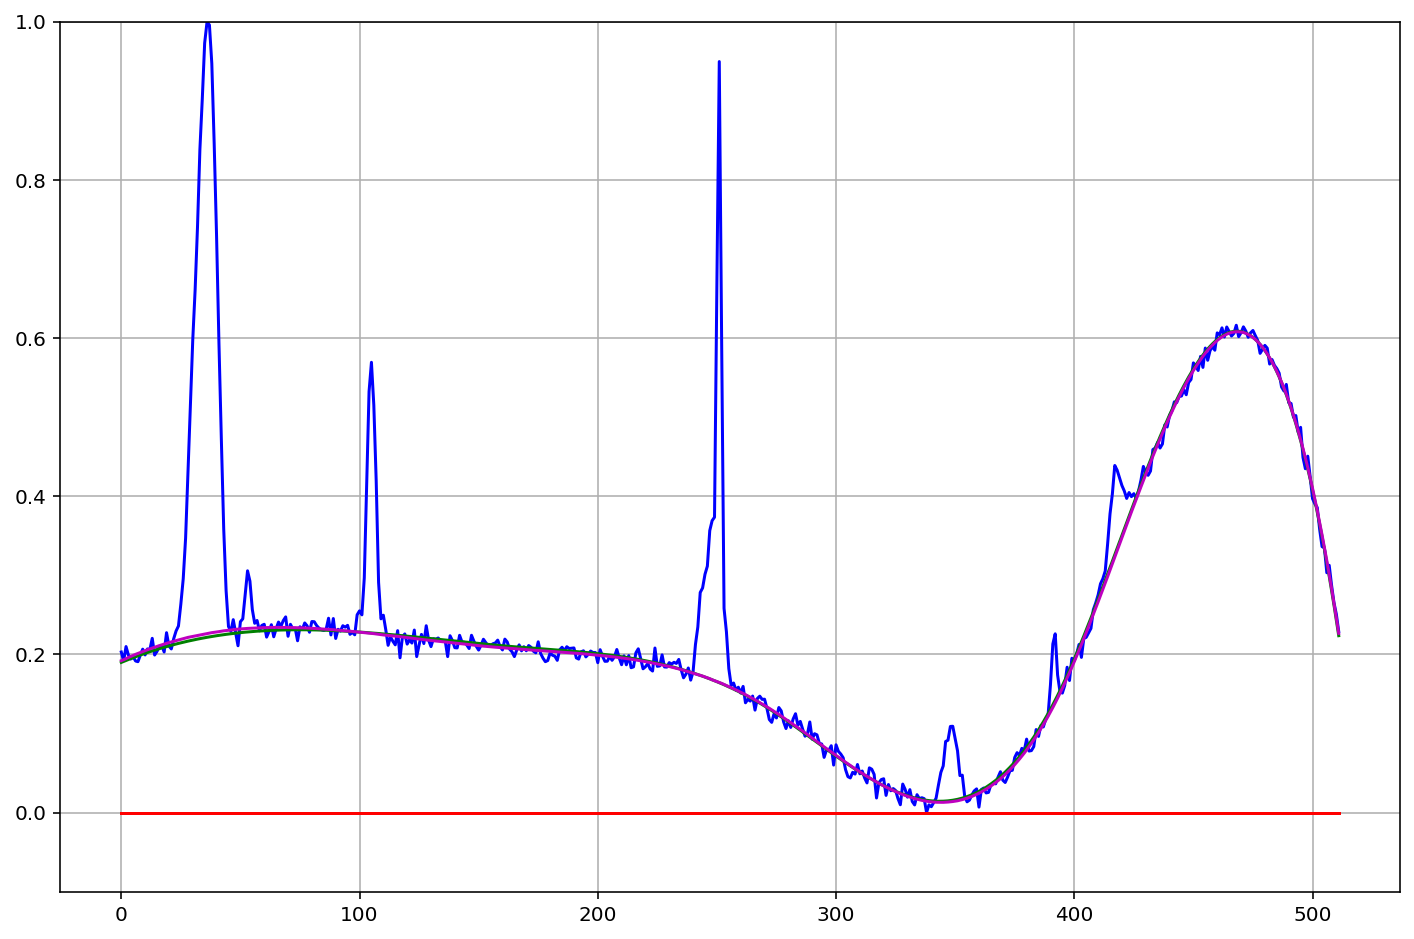

error=0.0019848505035042763


In [15]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

#%matplotlib tk
#%matplotlib inline

#plt.rcParams["figure.figsize"] = (8,6)
orderScore=np.flip(np.argsort(outScore))
for idx in orderScore[:13]:
    print(idx)
    dataZ=testZZ[idx];
    dataY=testYY[idx];
    plt.figure(figsize=(12,8))
    plt.ylim(-0.1,1)
    plt.plot(dataZ,'b')
    plt.plot(dataY,'g')            # draw the real baseline 
    #plt.plot(dataX-outputData[idx,:],'c')      # draw peaks
    plt.plot(np.zeros((len(dataZ),1)),'r')
    plt.plot(outData[idx],'m')  # draw the output baseline
    plt.grid(True)    
    plt.show()
    print(f'error={ np.mean(np.abs(dataY-outData[idx])) }')


dataSize : 40, dataLen : 1024


<ipython-input-16-224ebcf5706f>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))


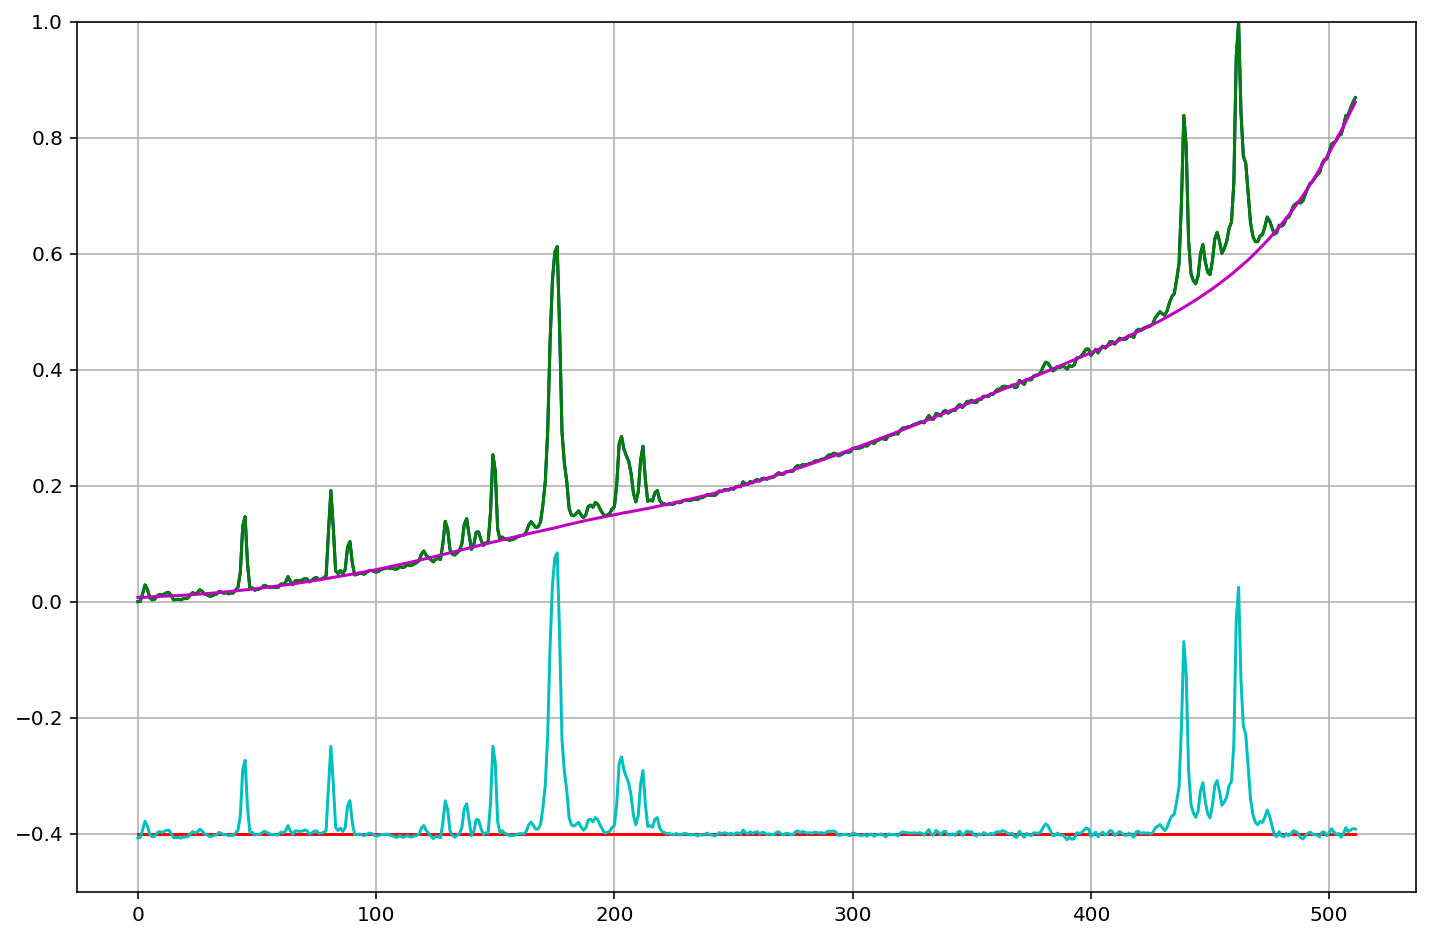

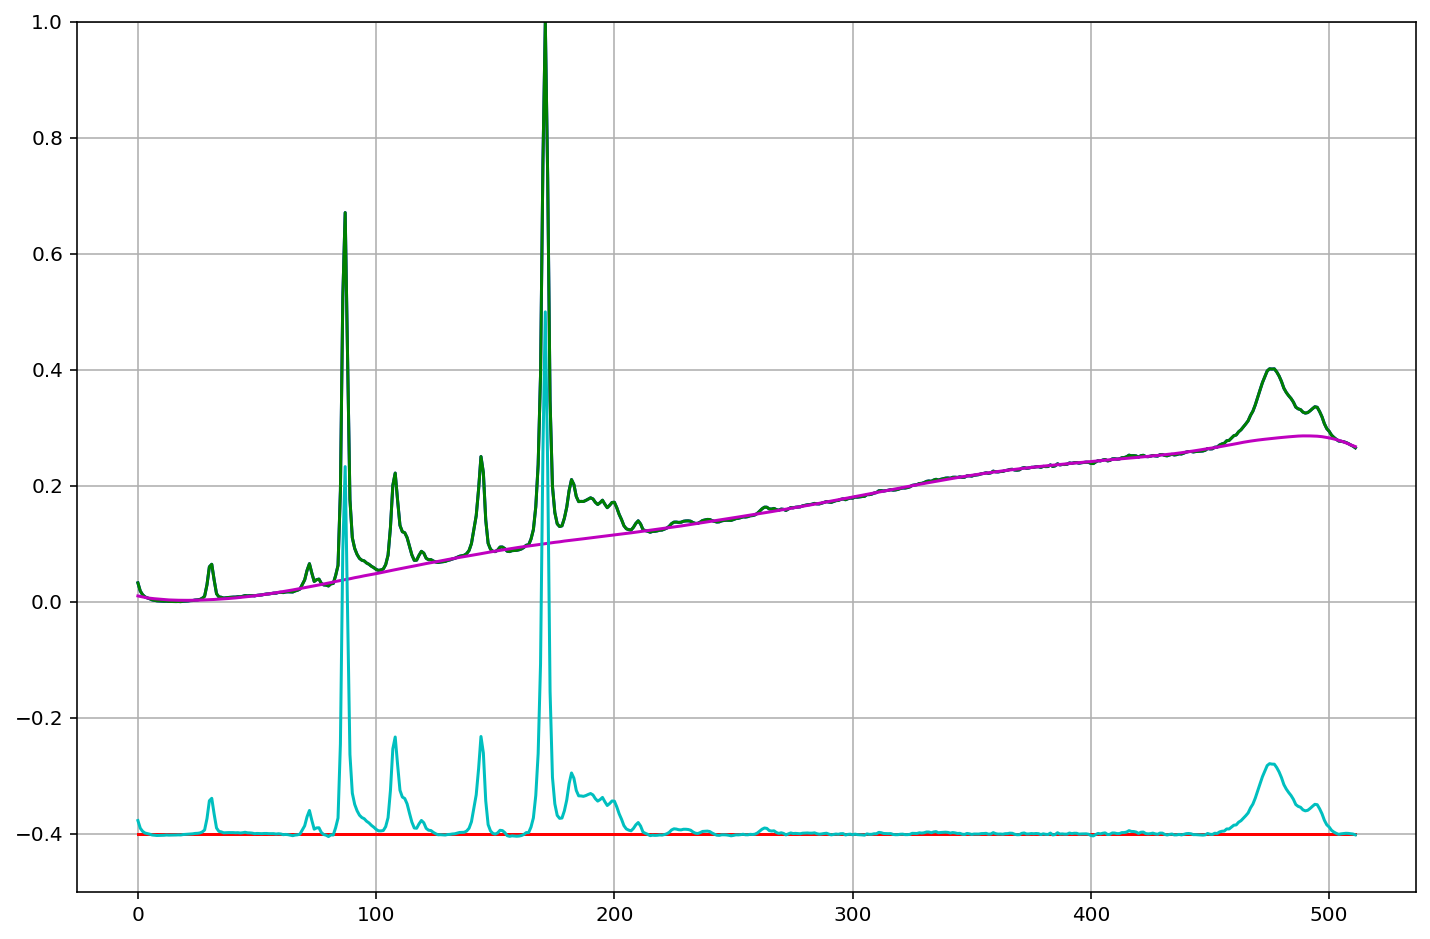

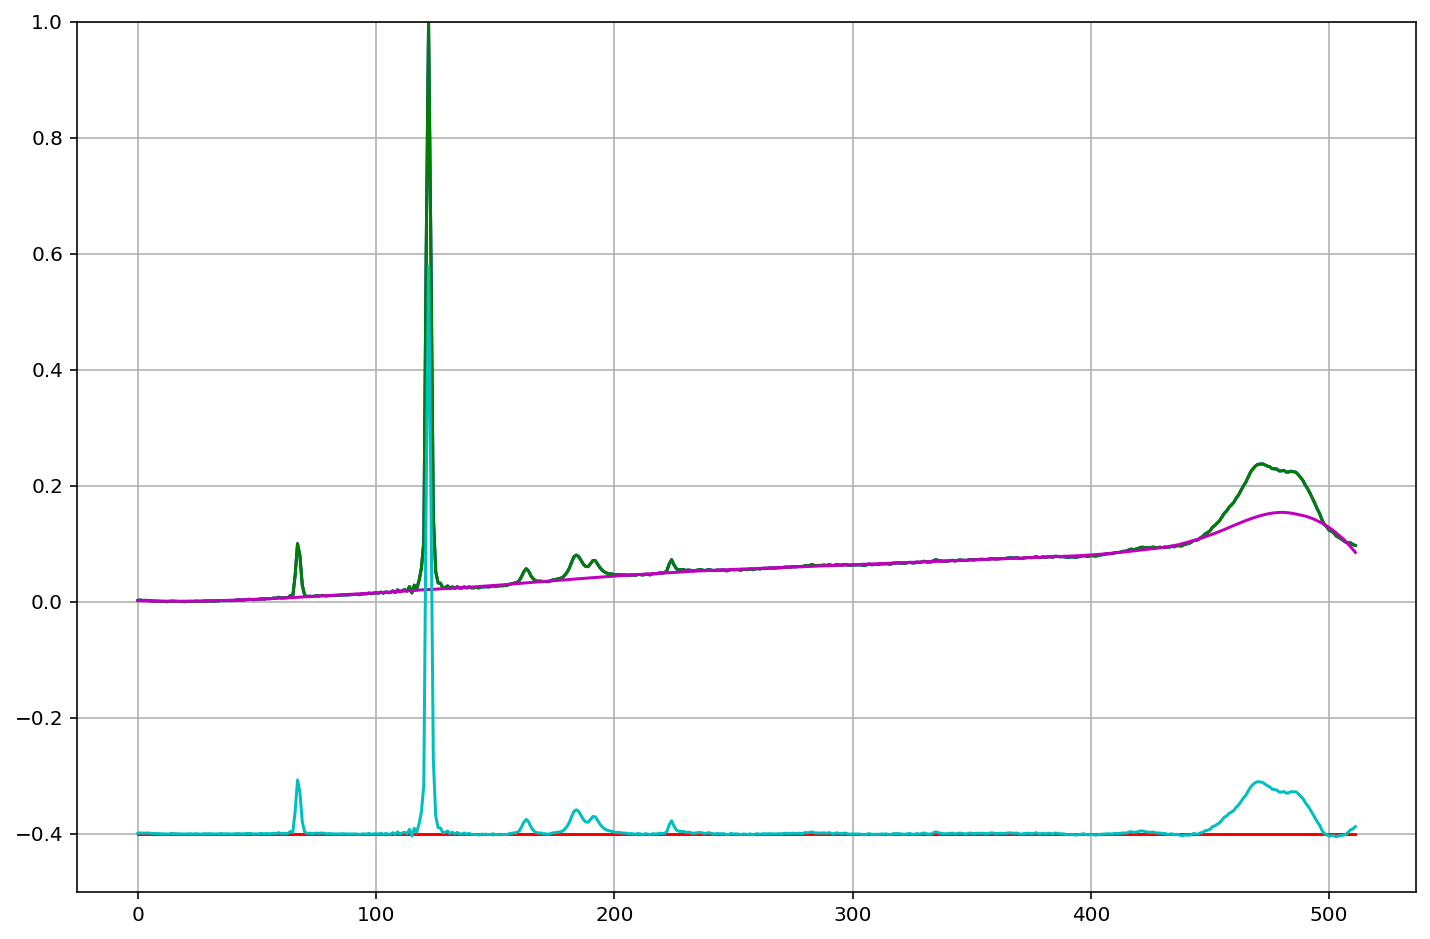

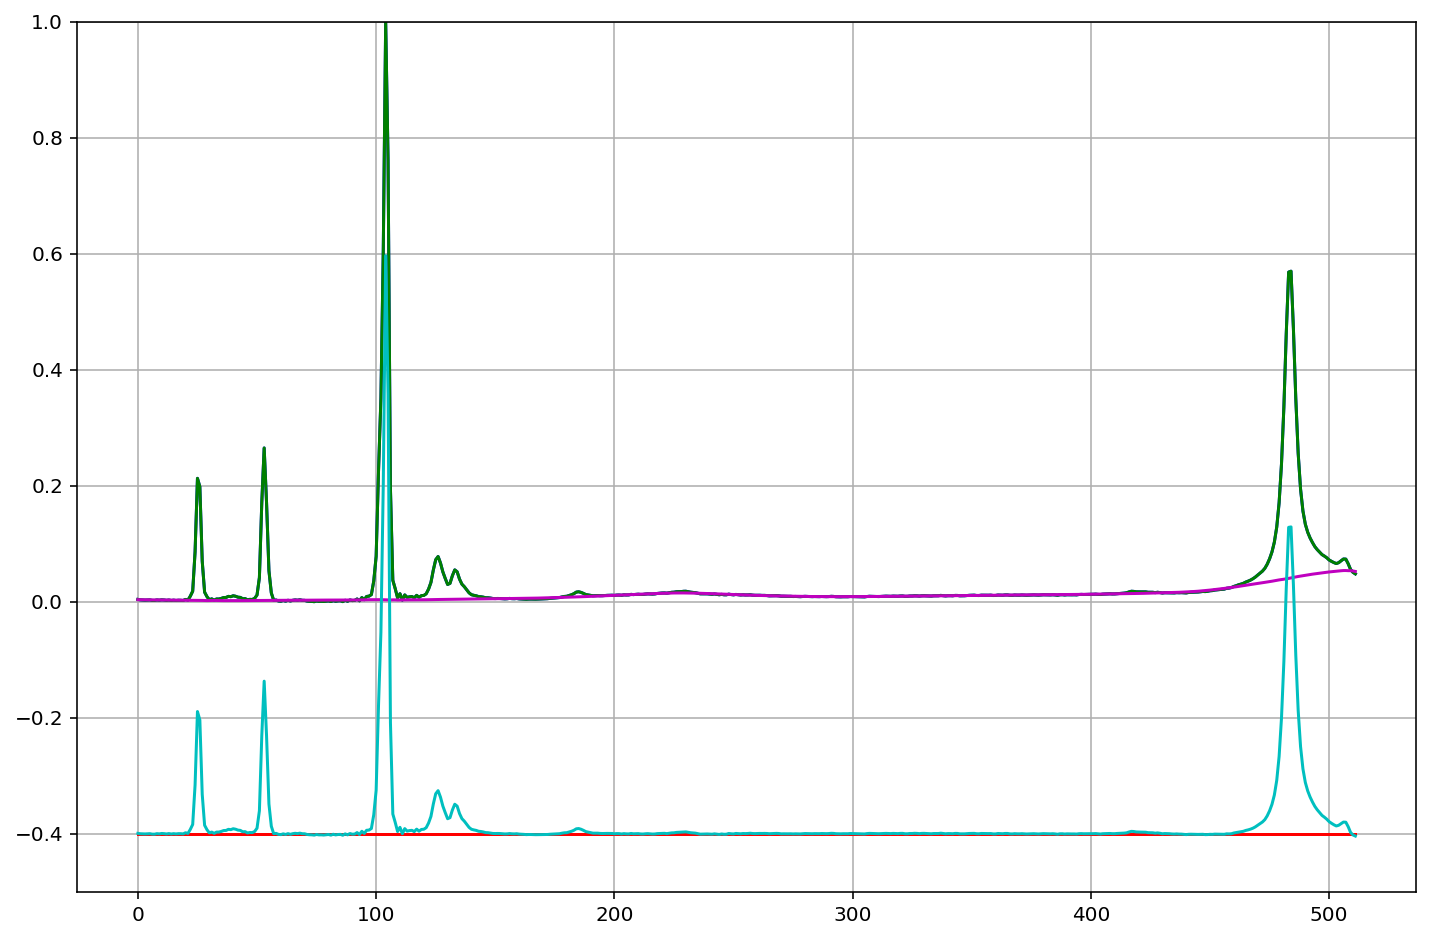

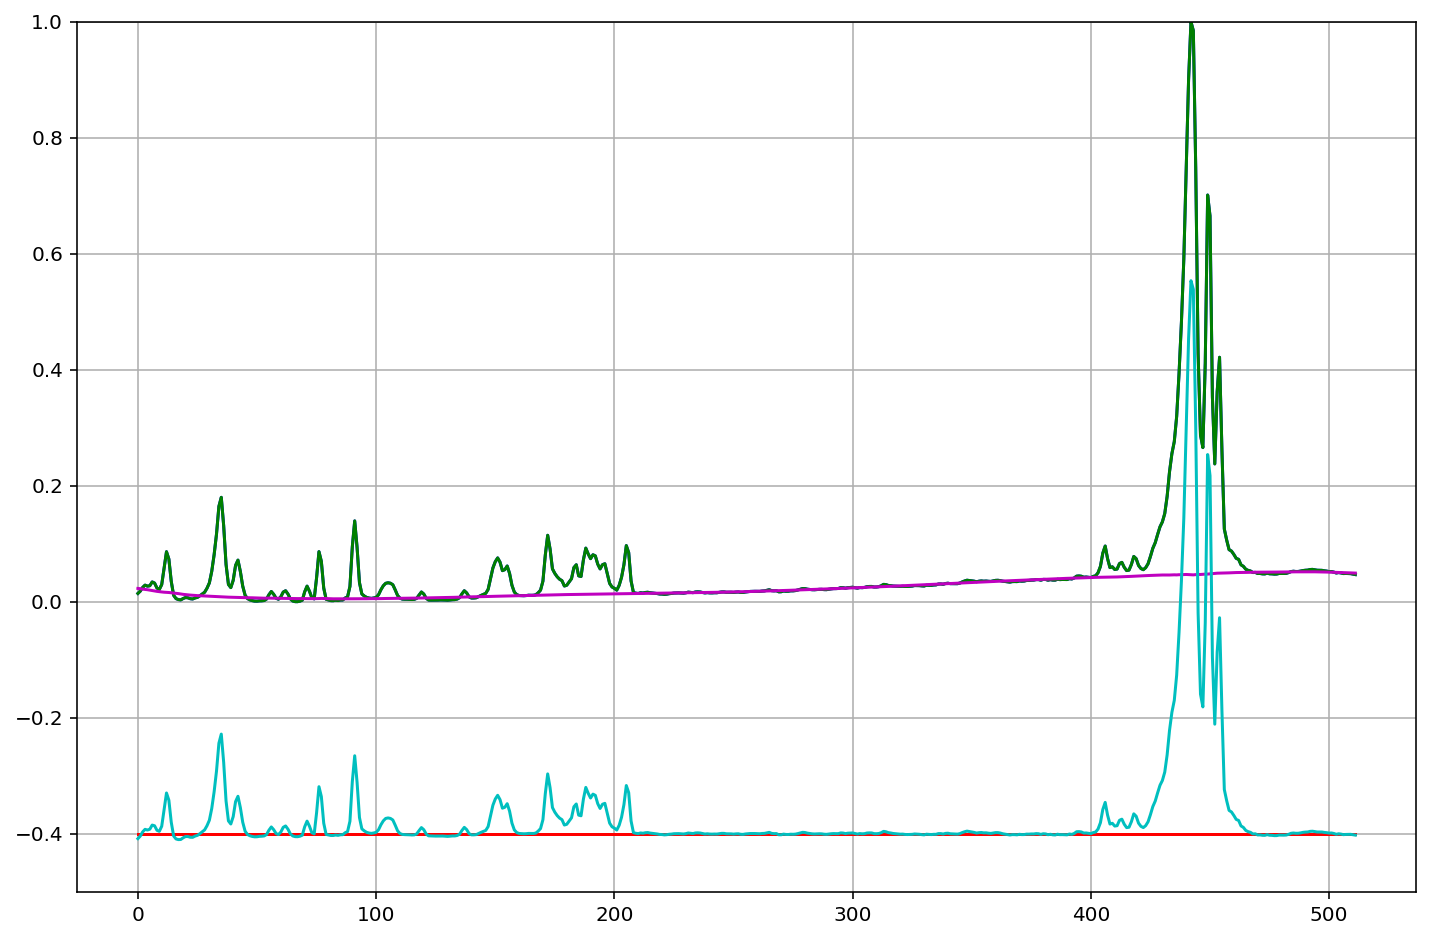

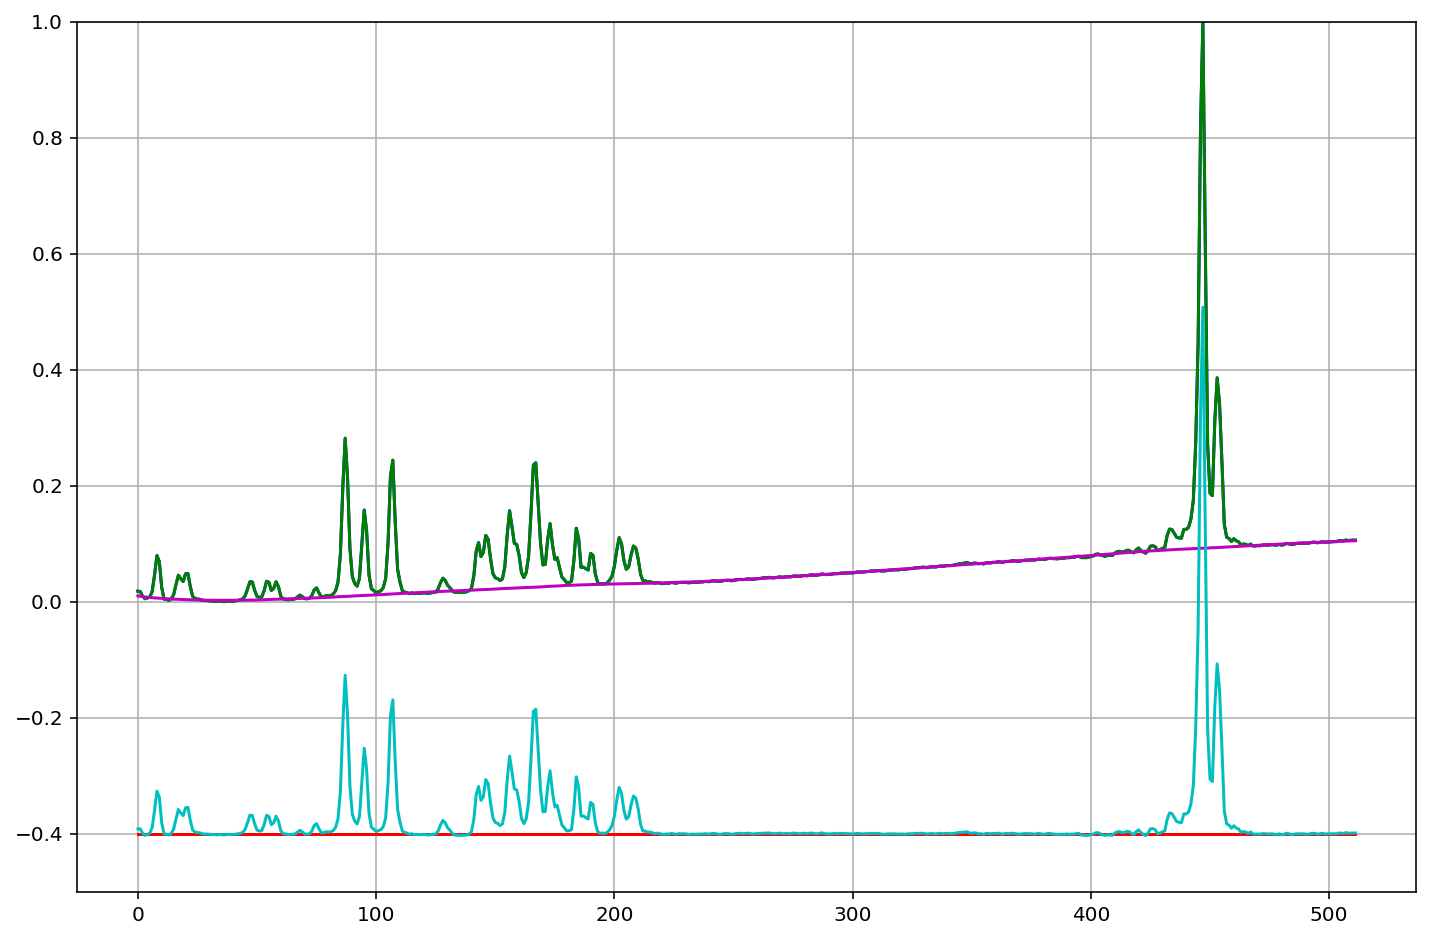

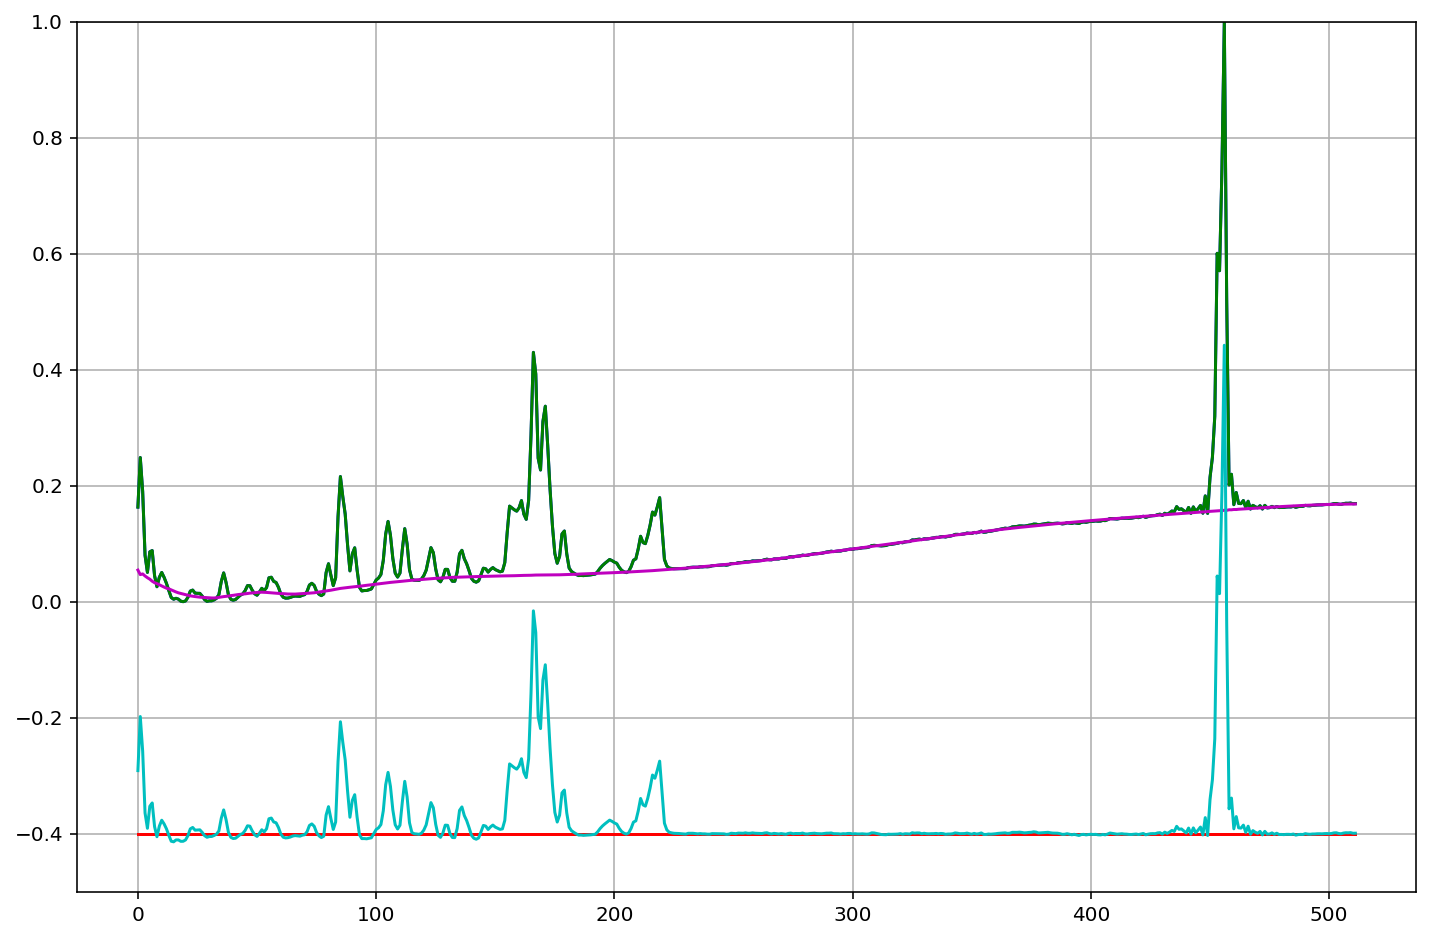

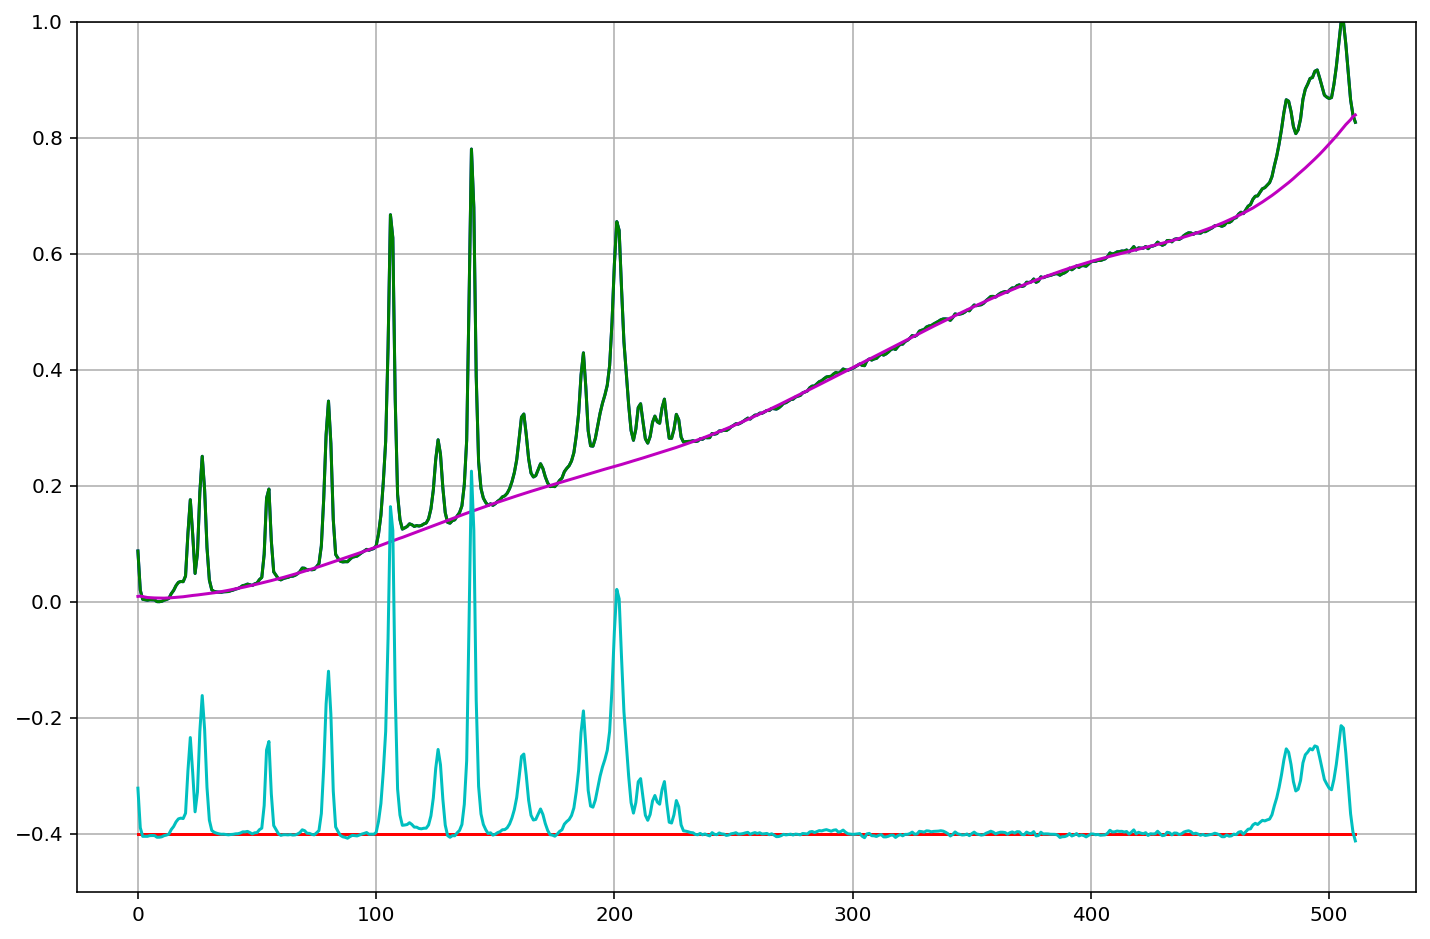

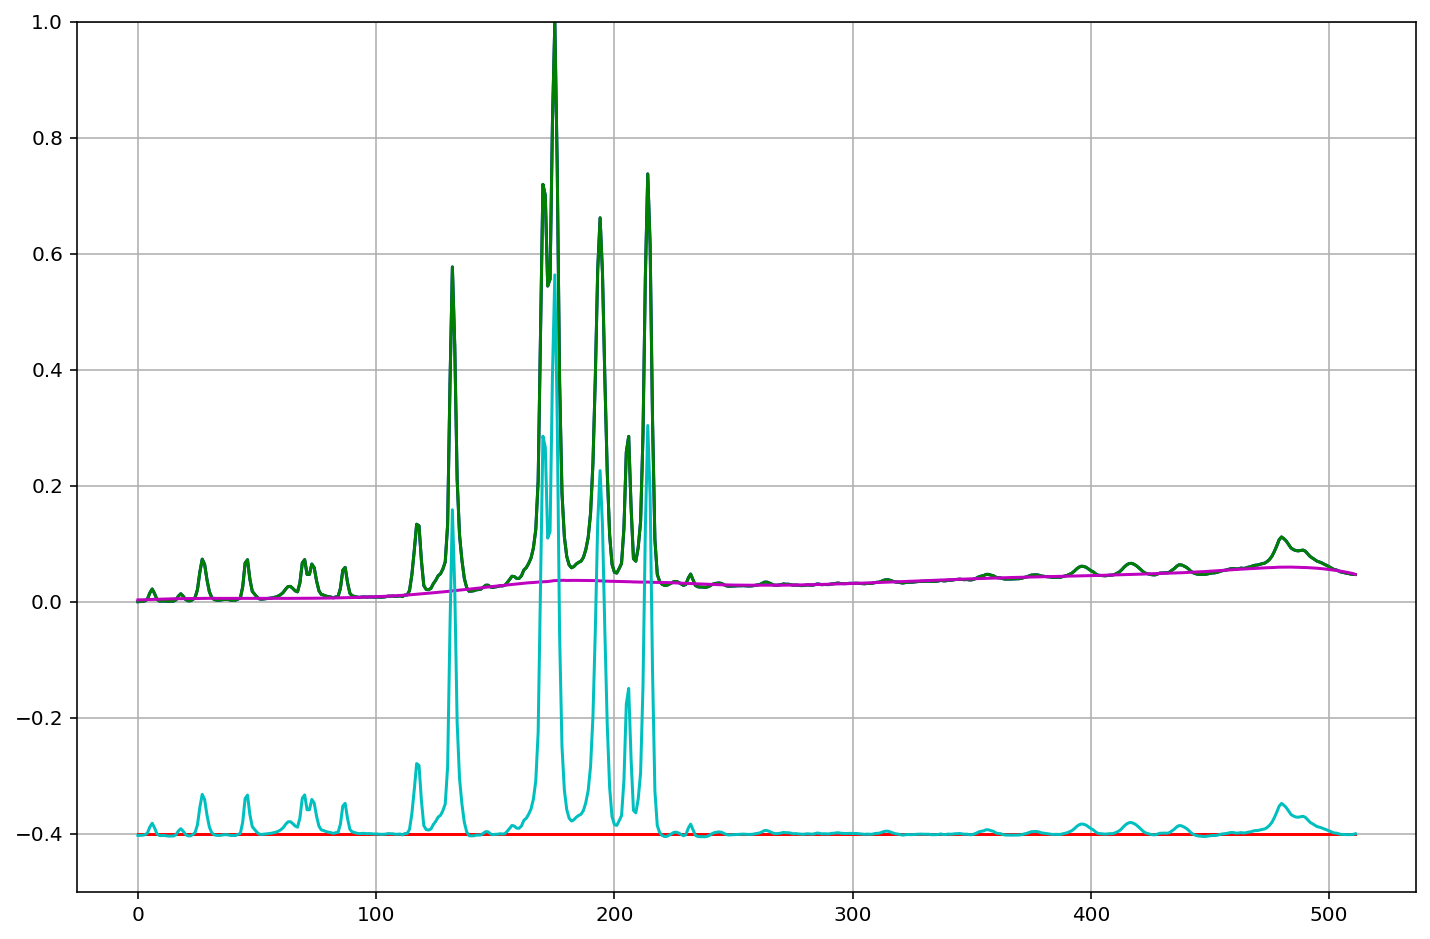

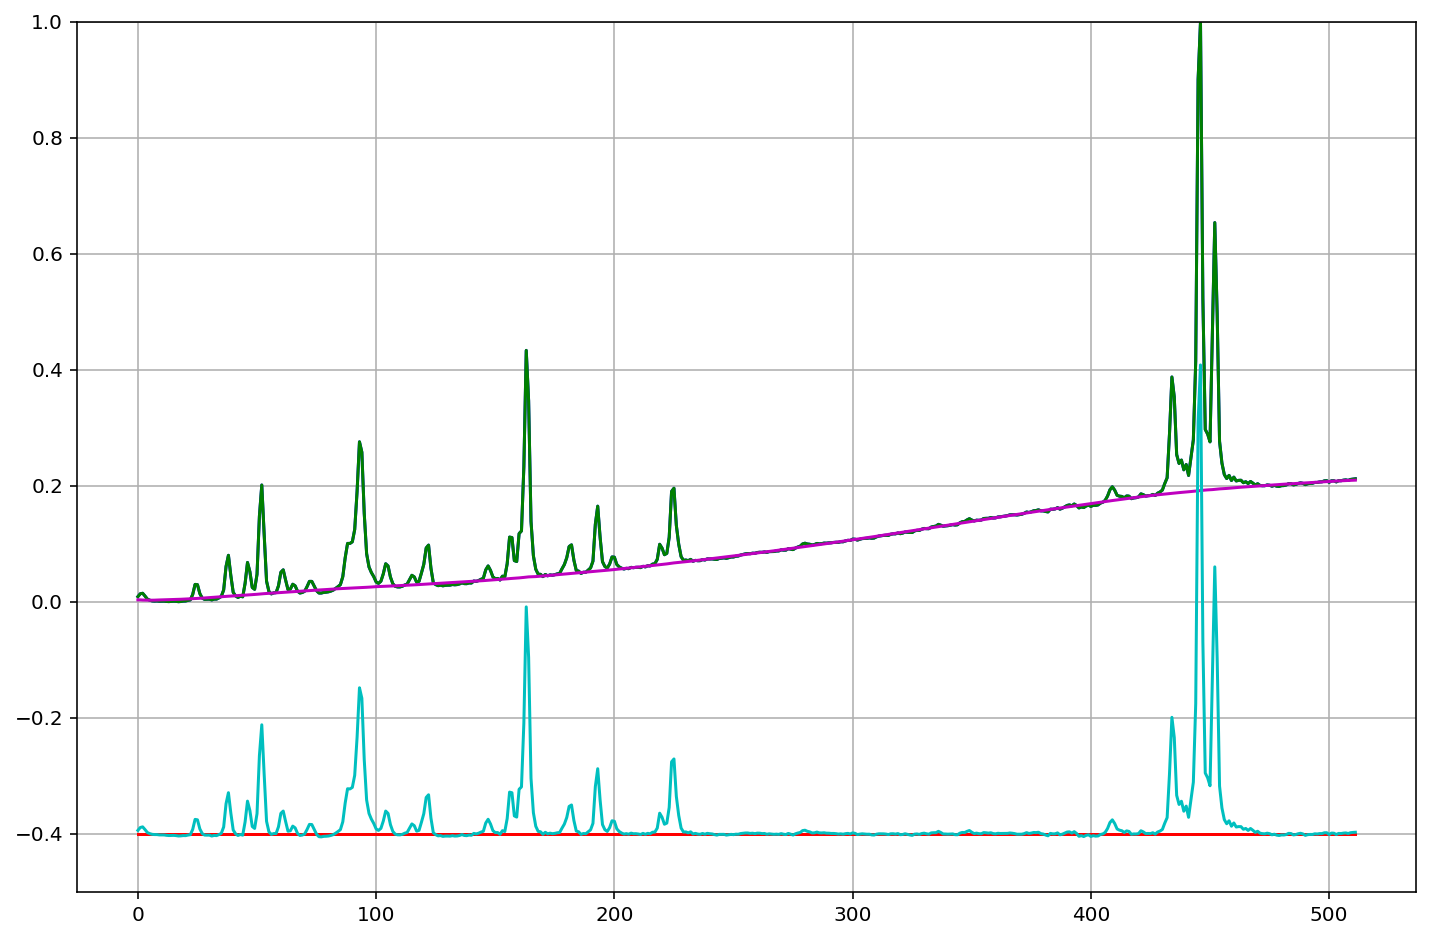

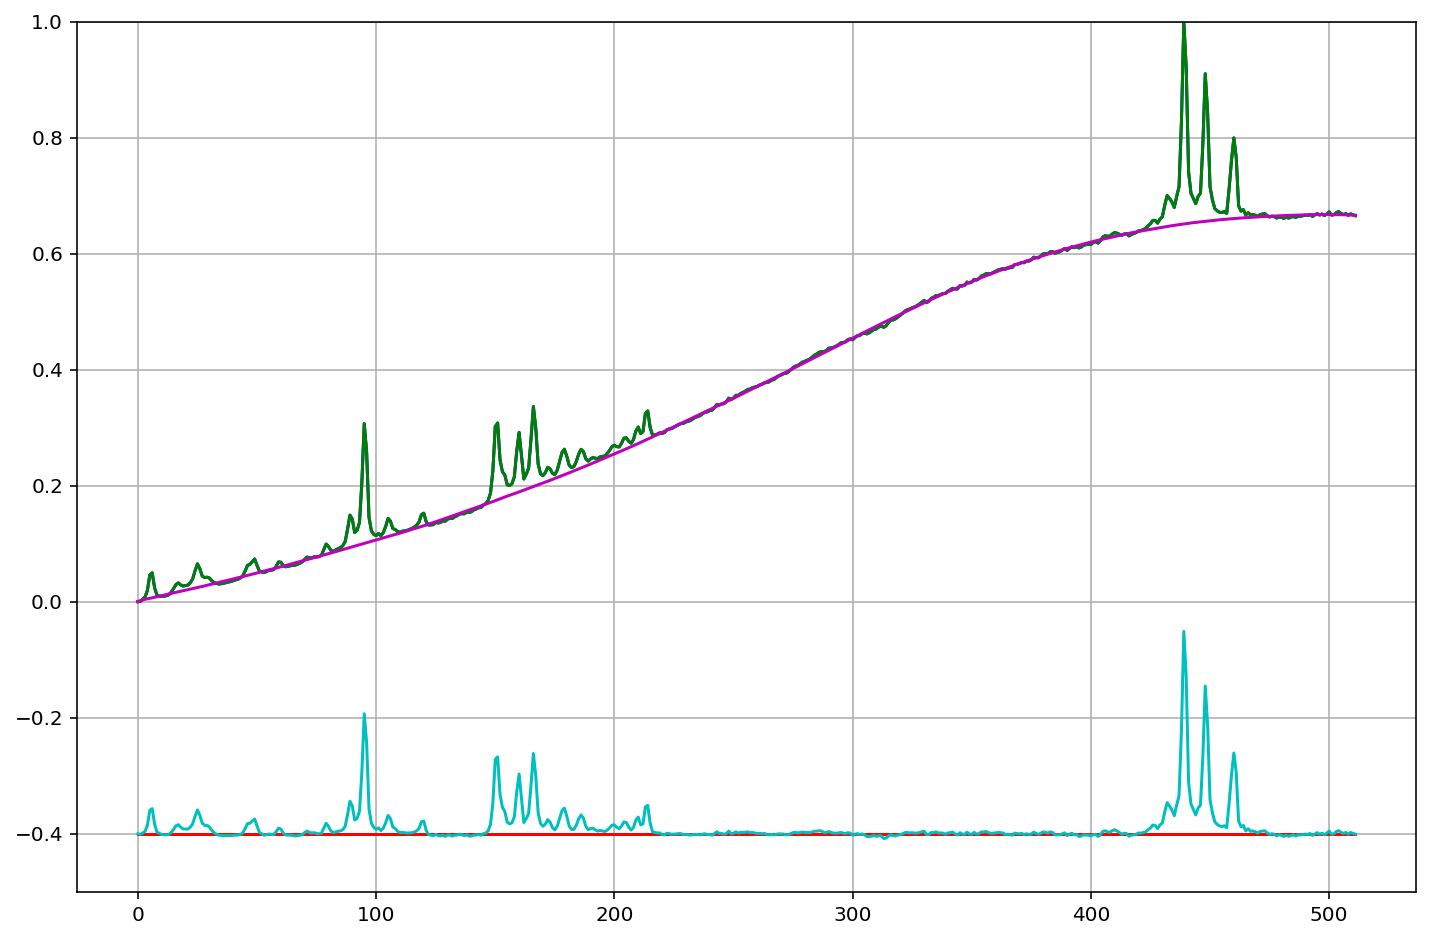

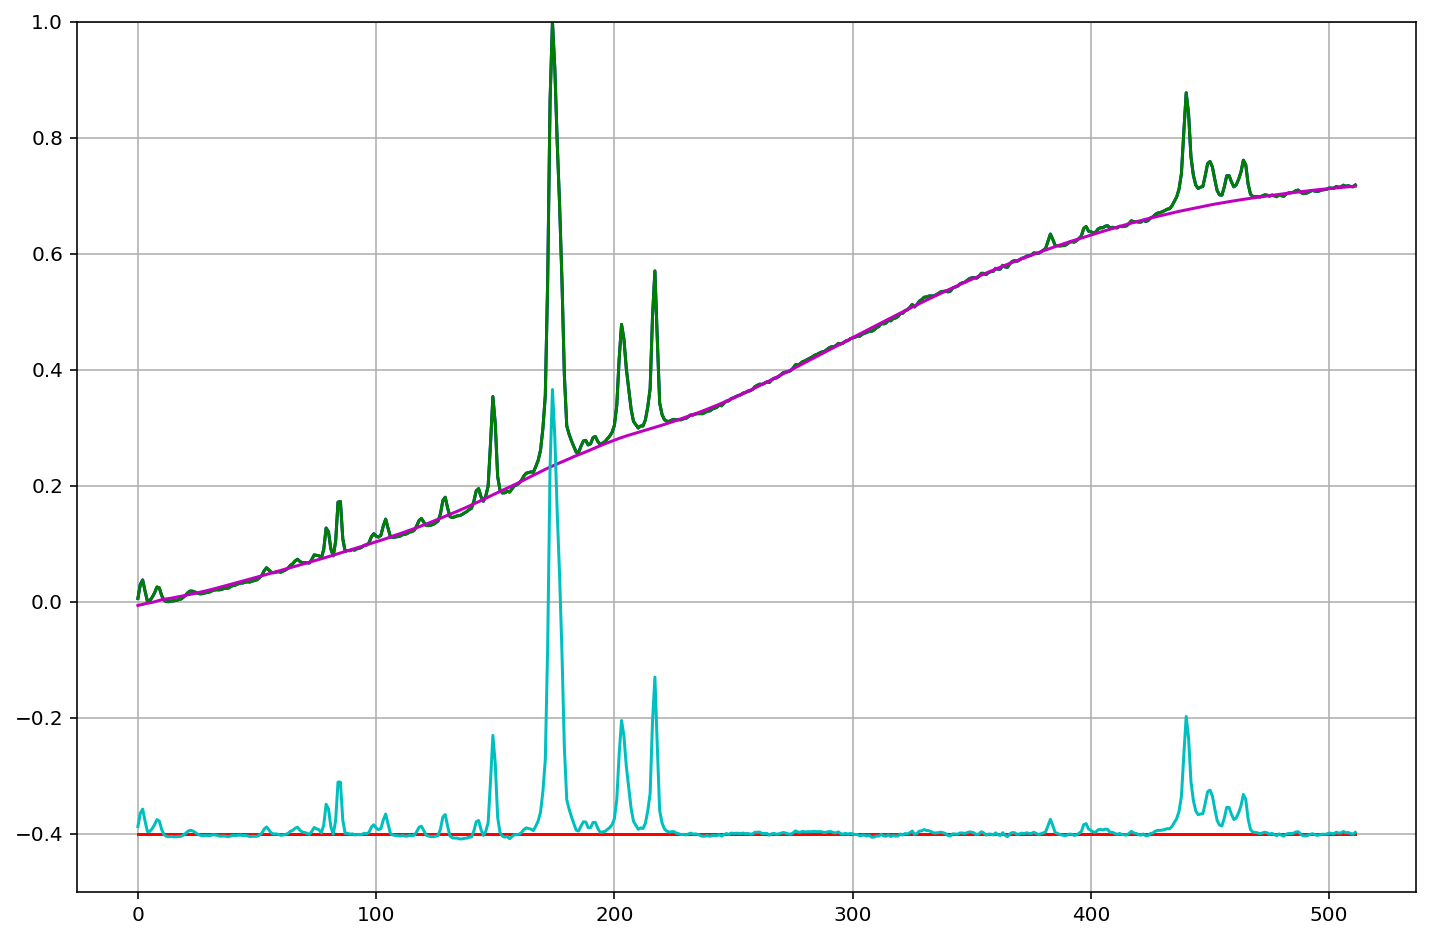

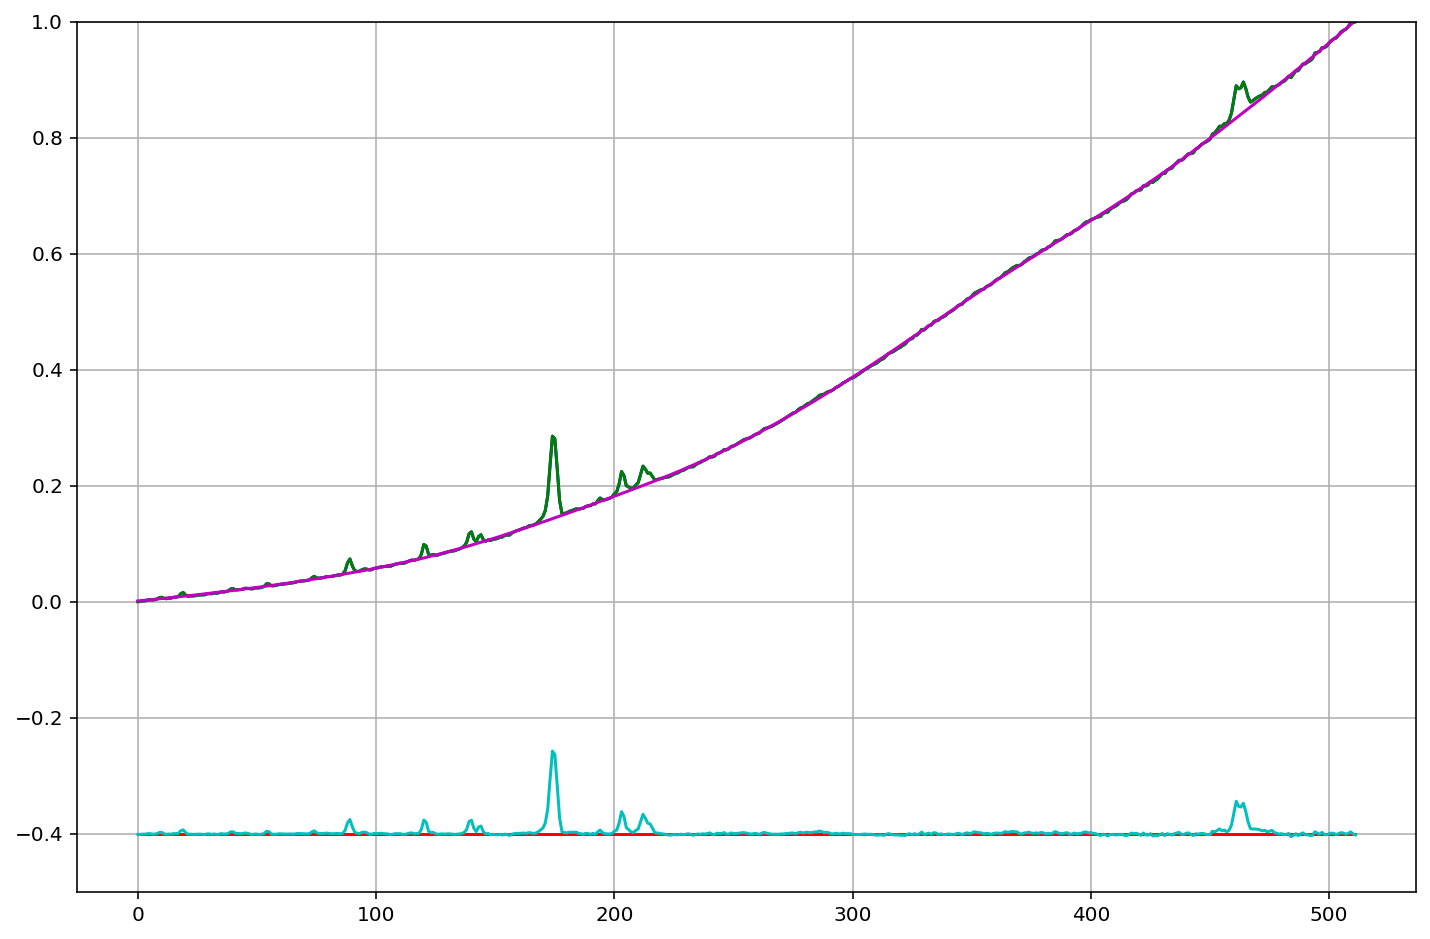

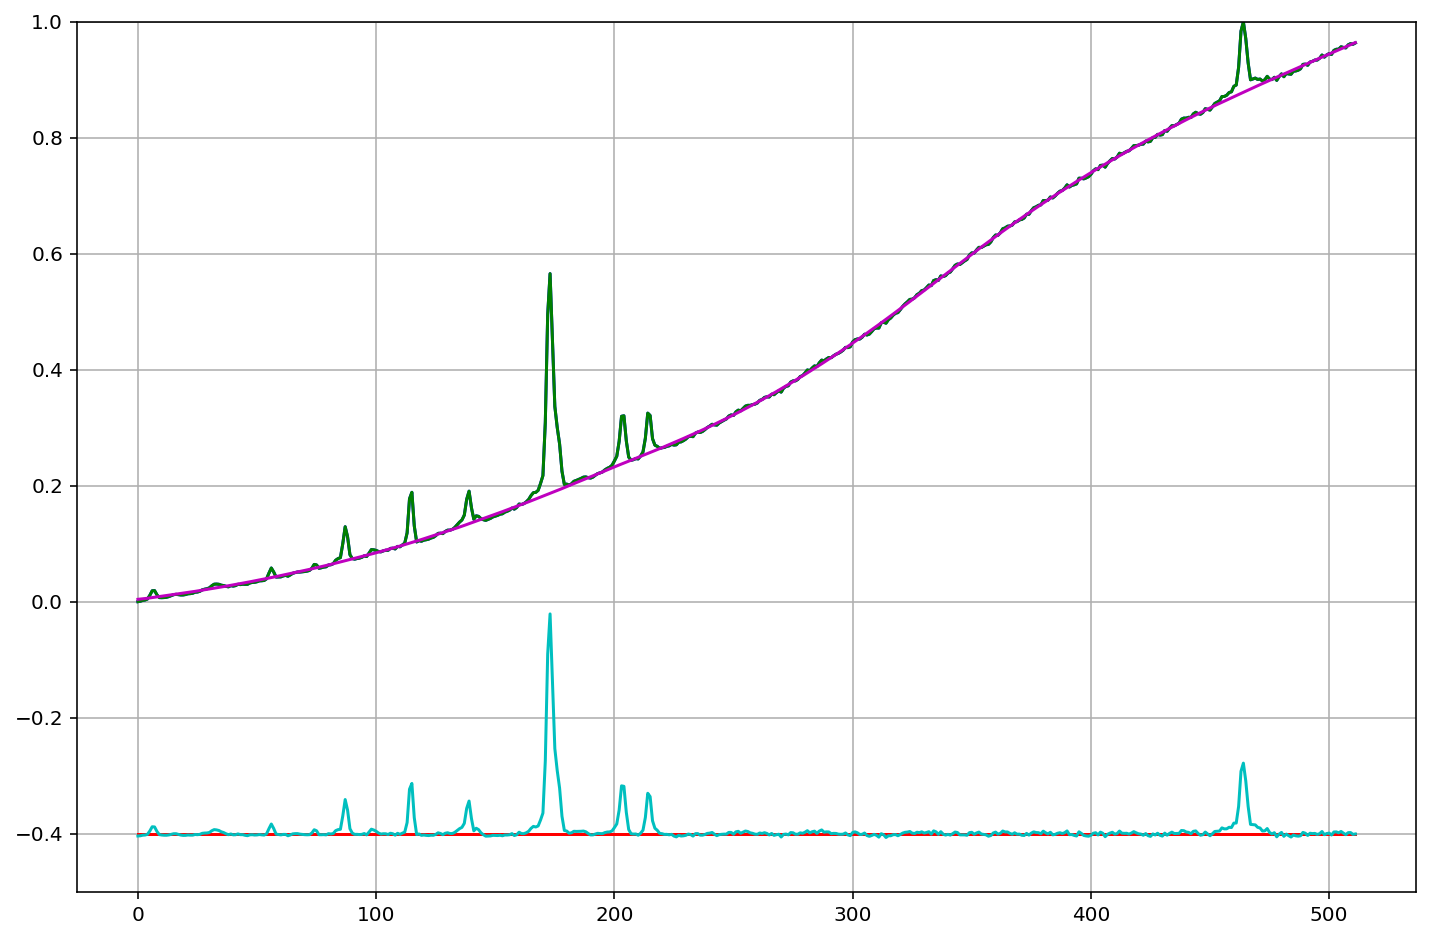

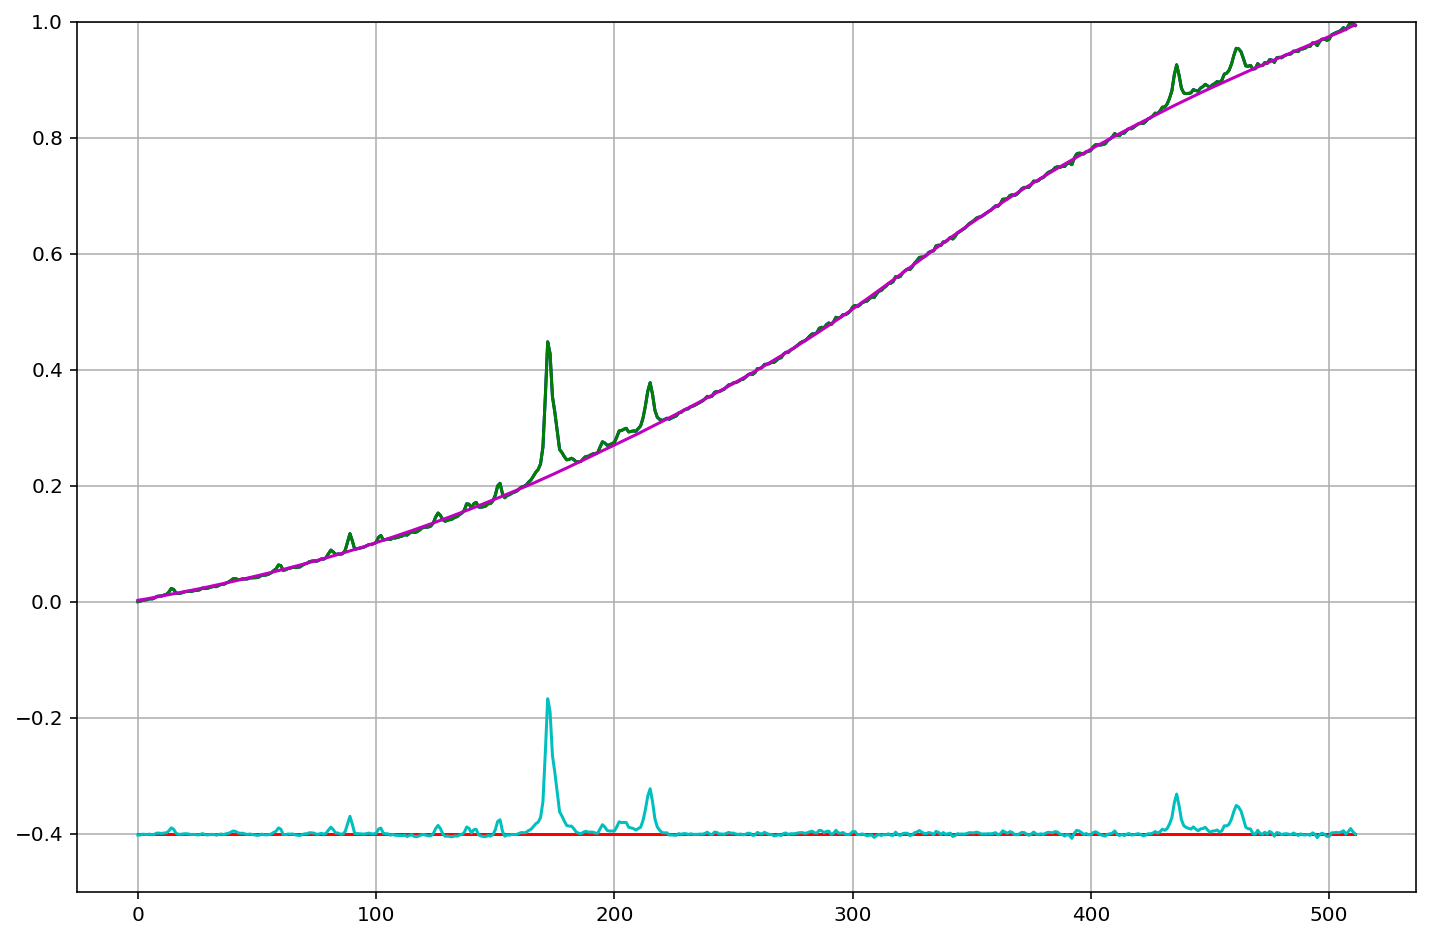

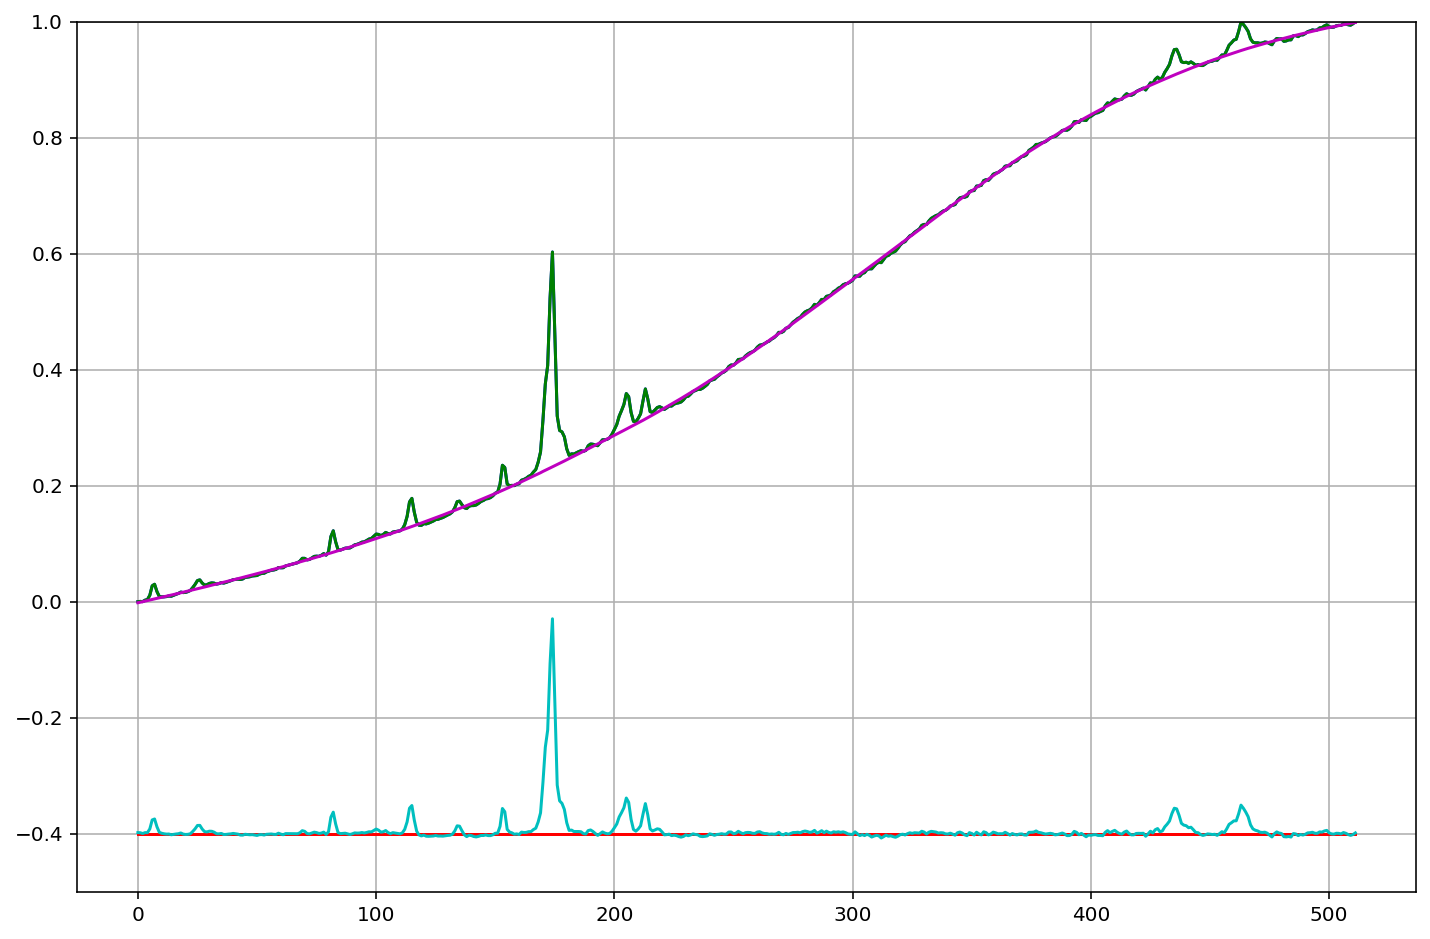

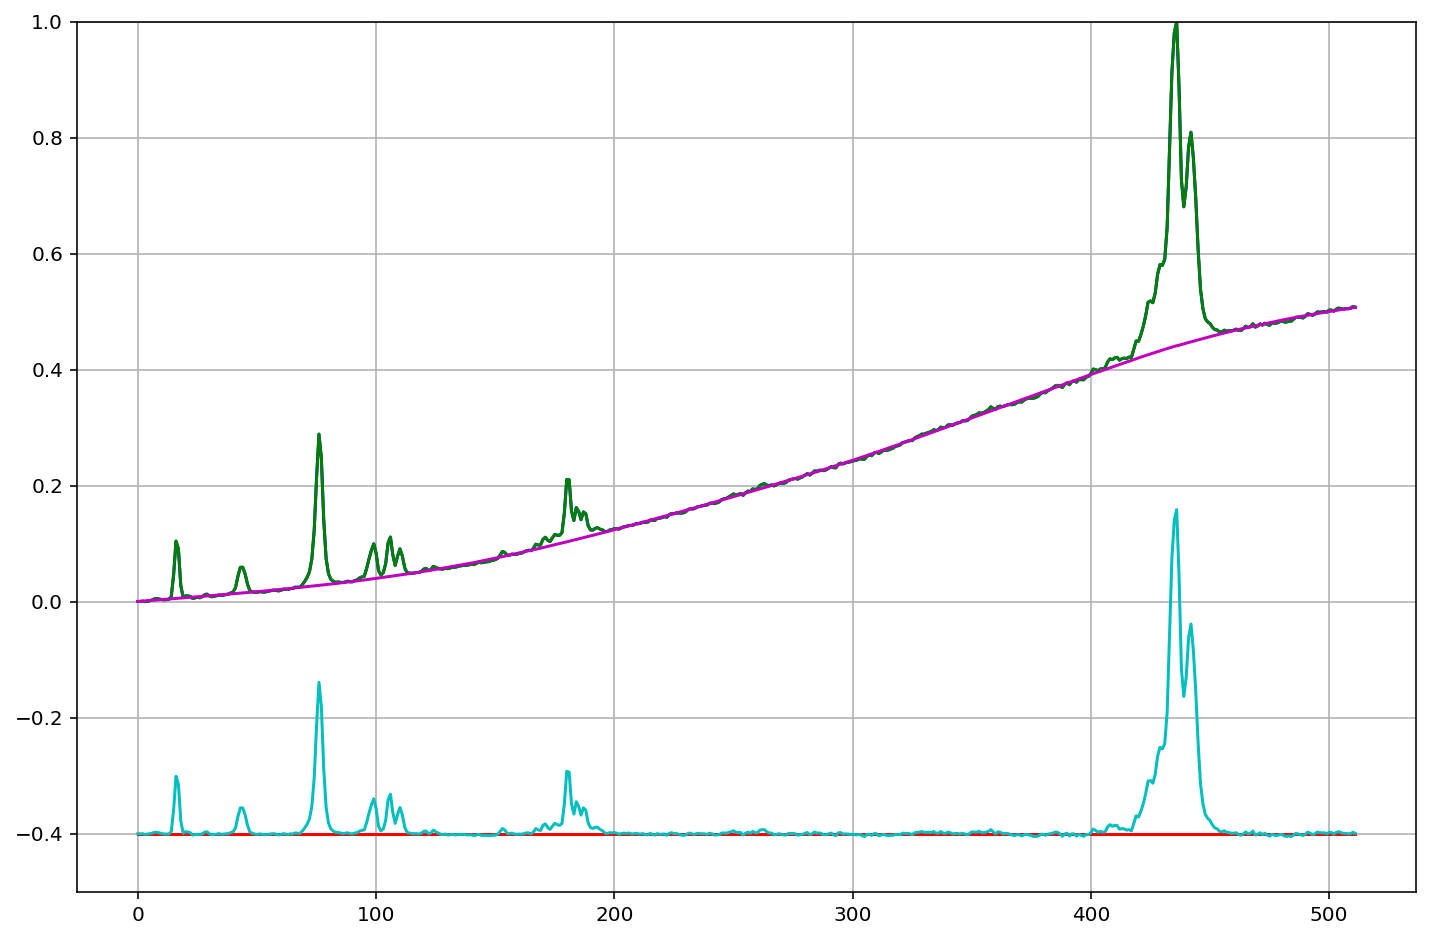

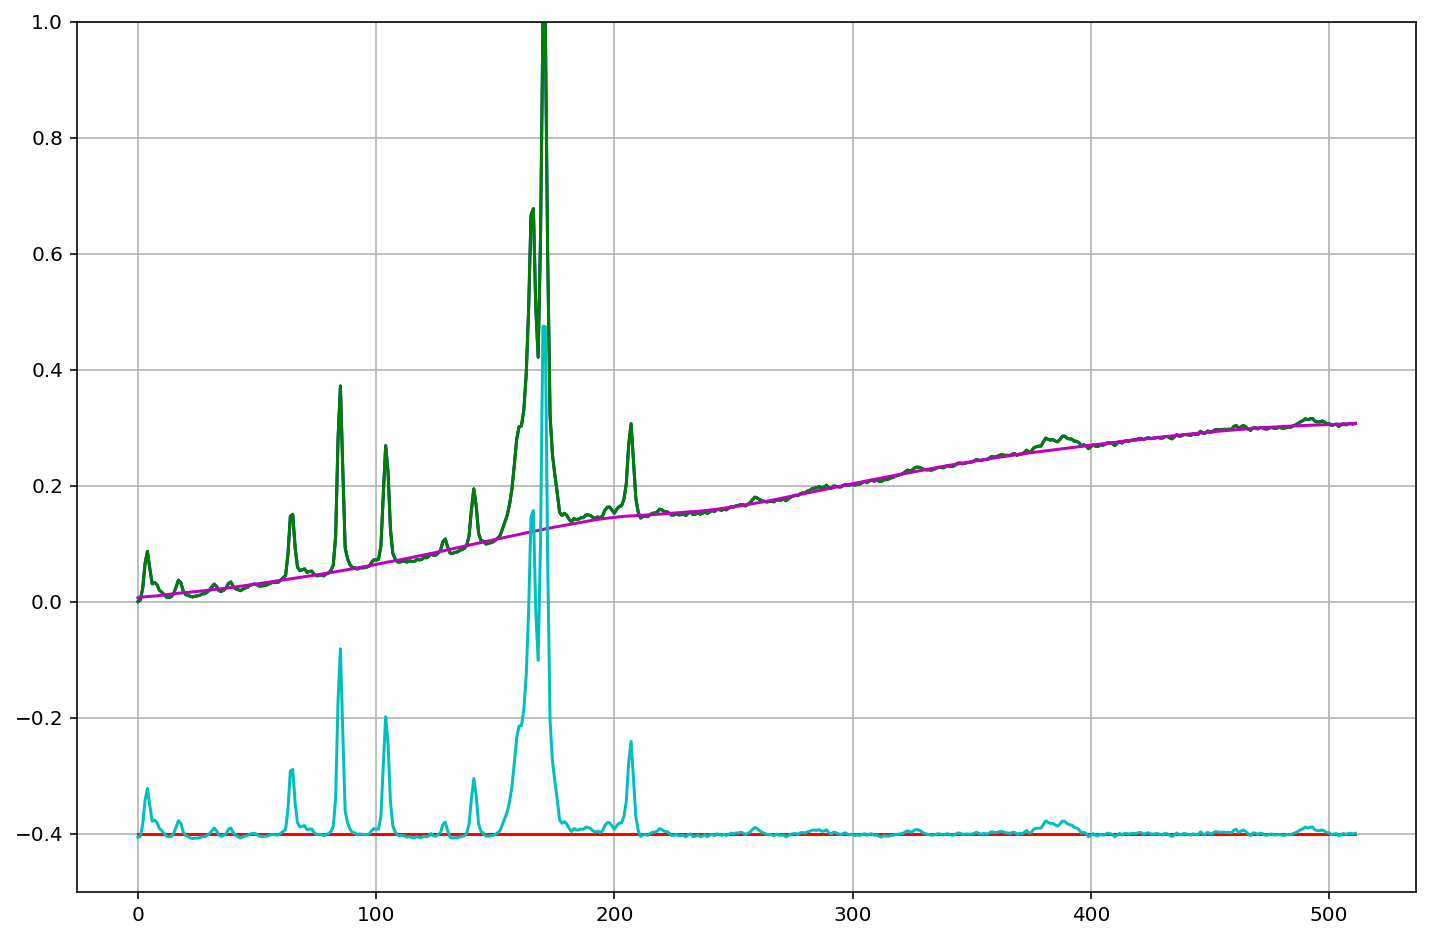

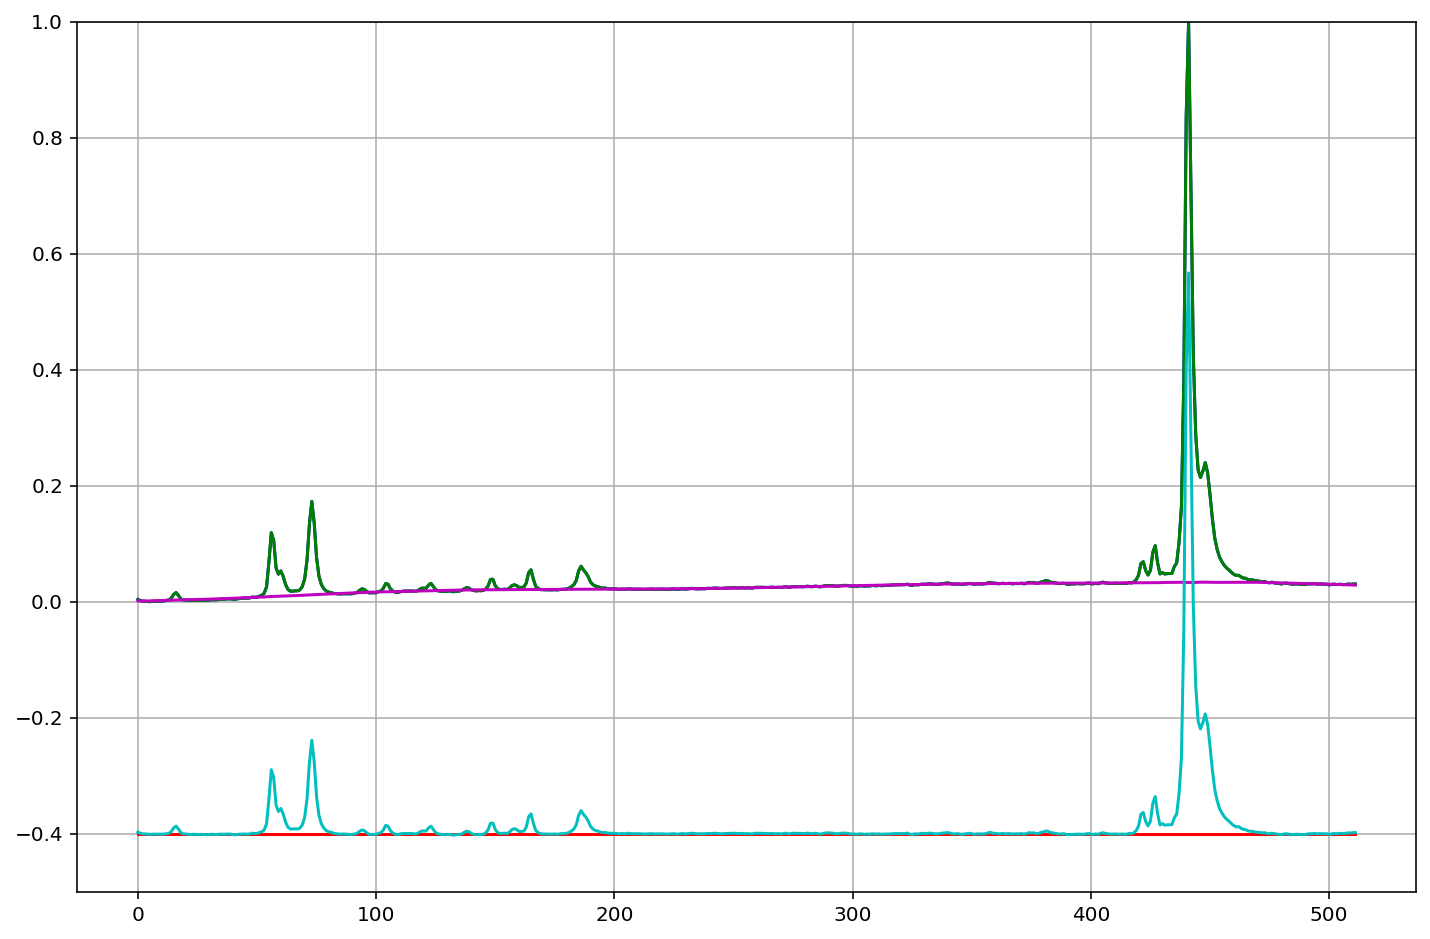

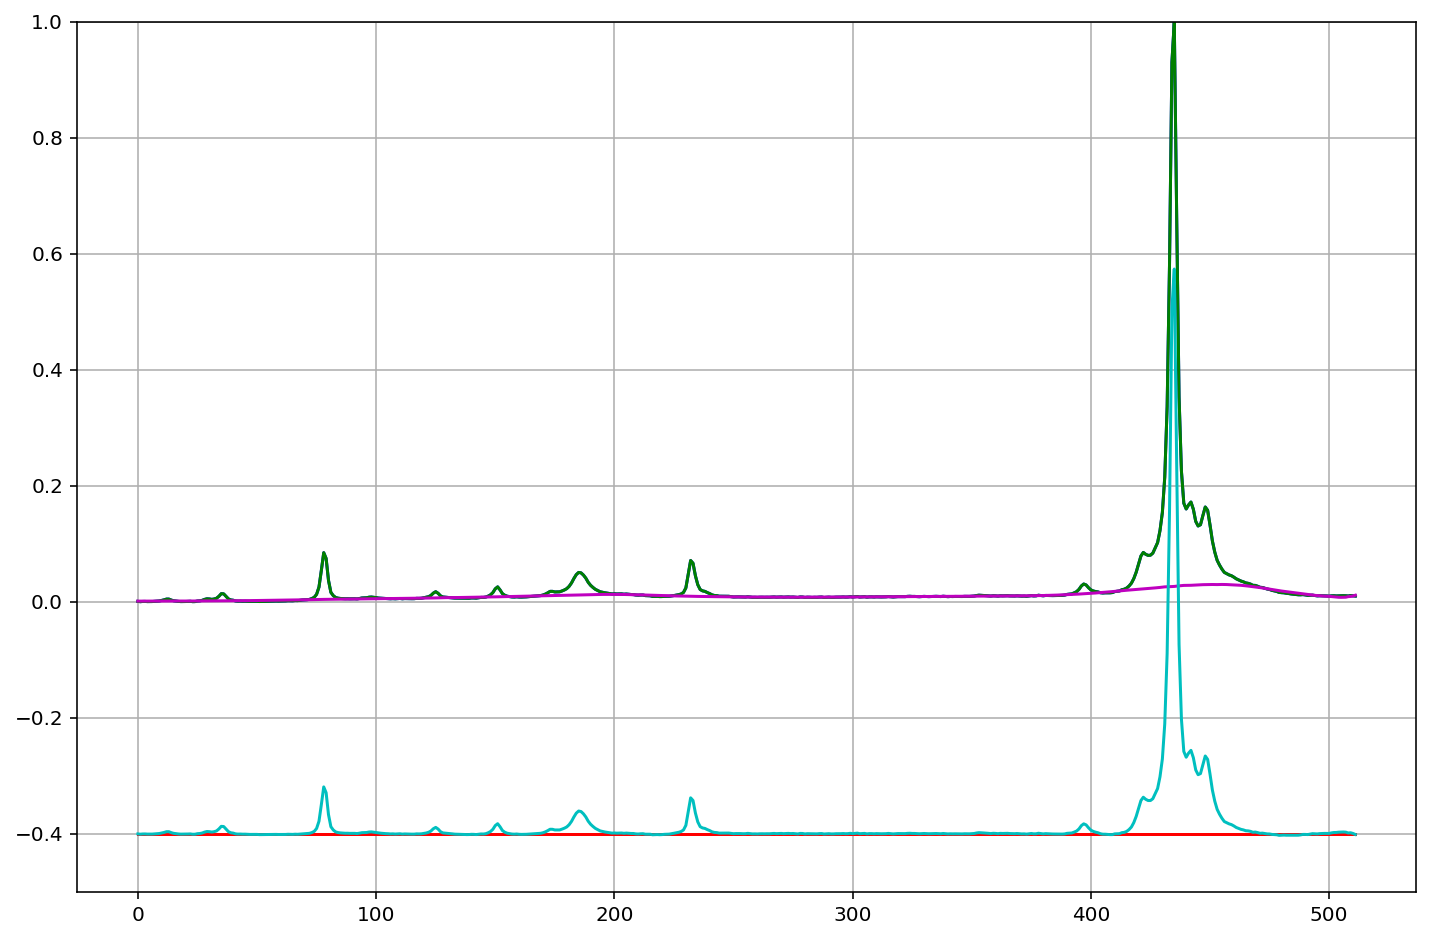

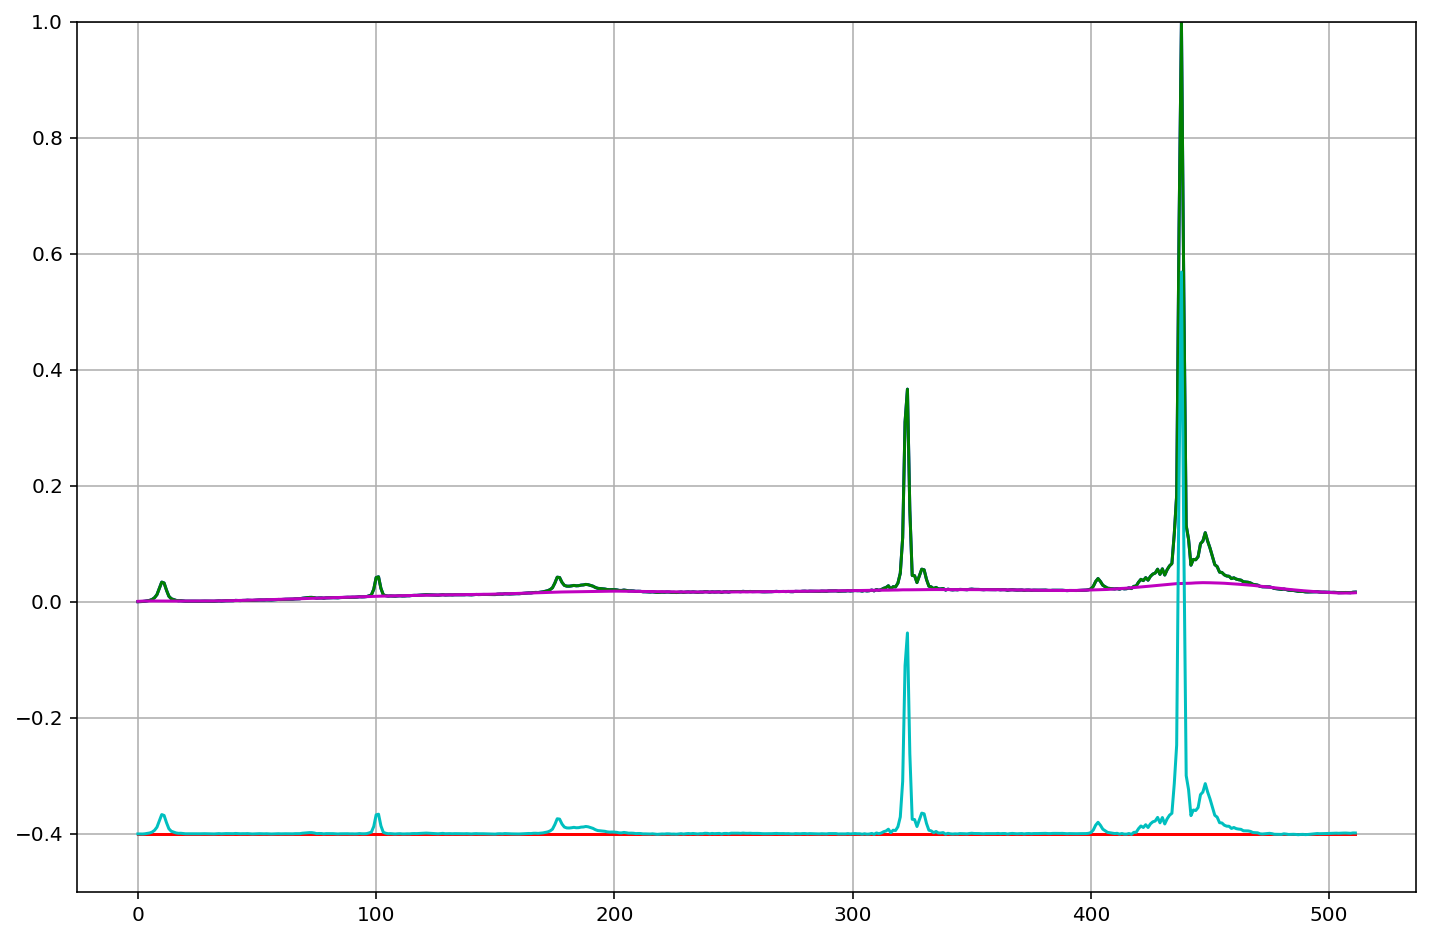

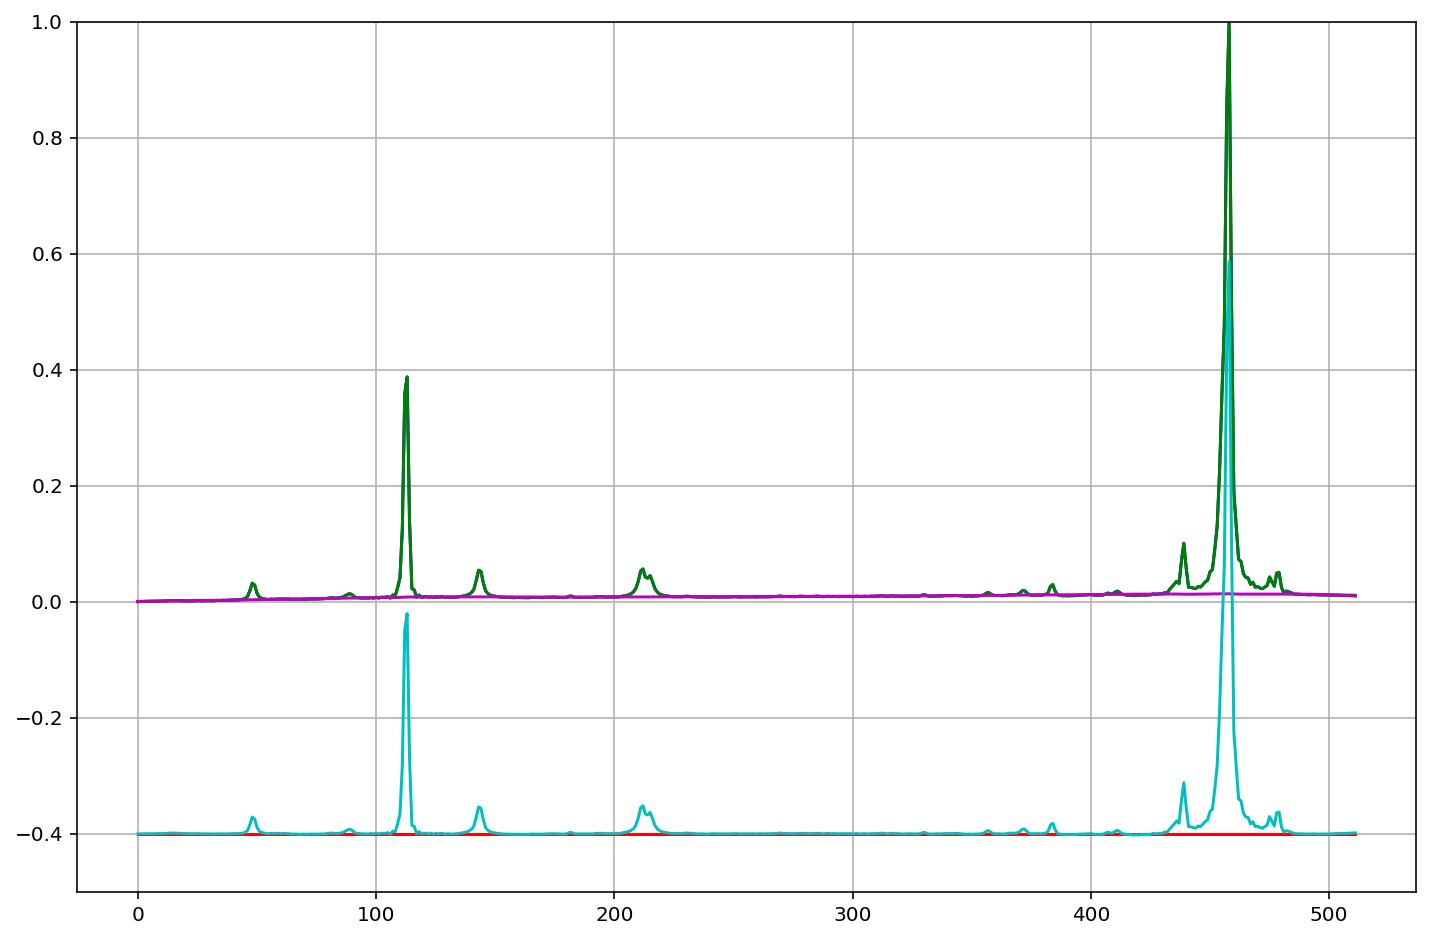

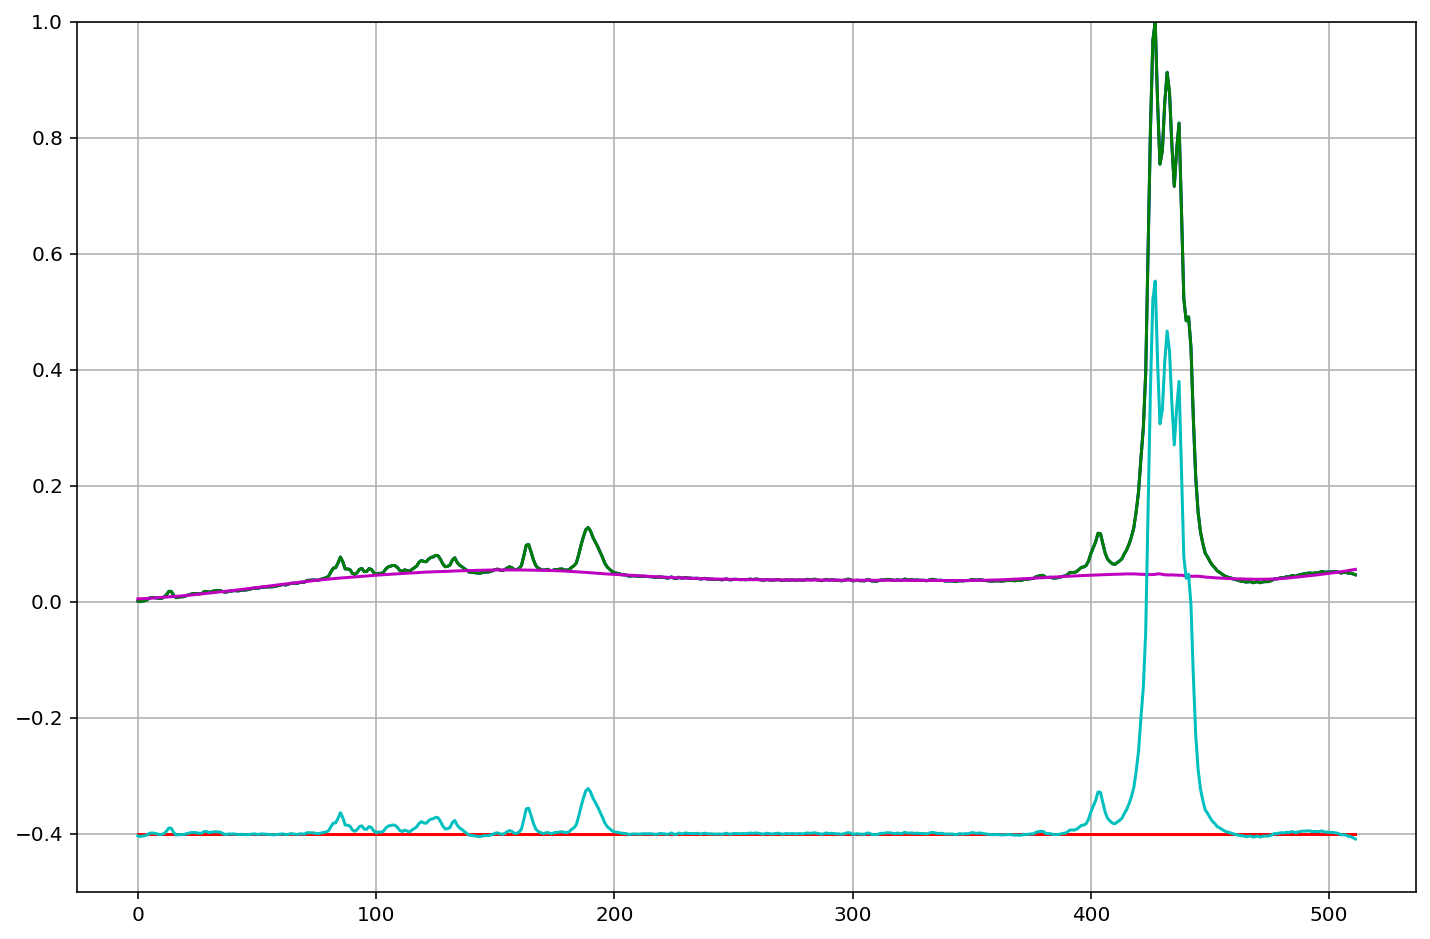

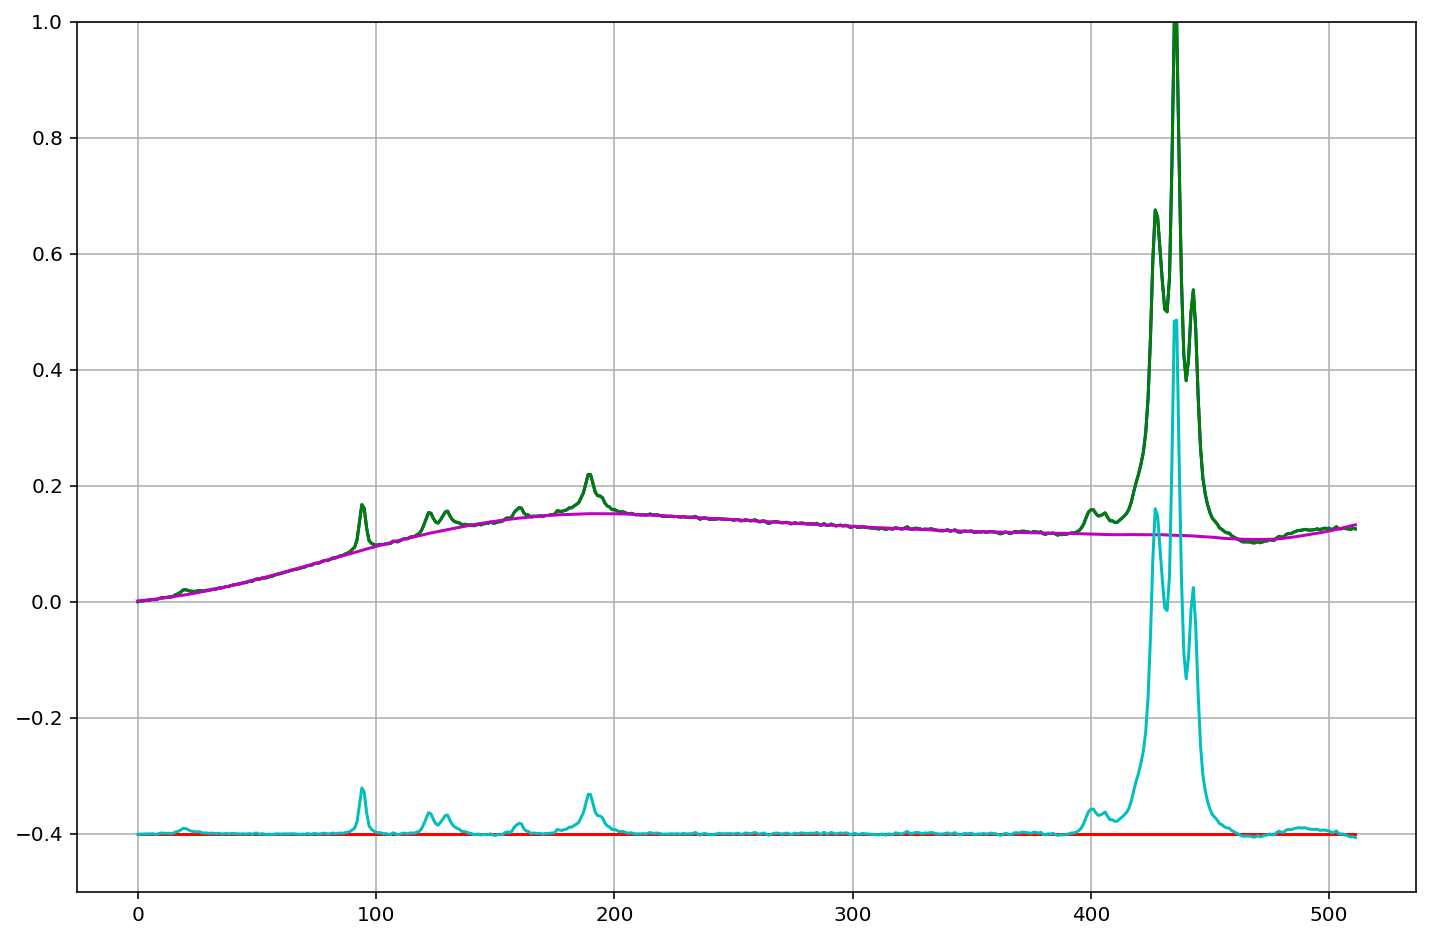

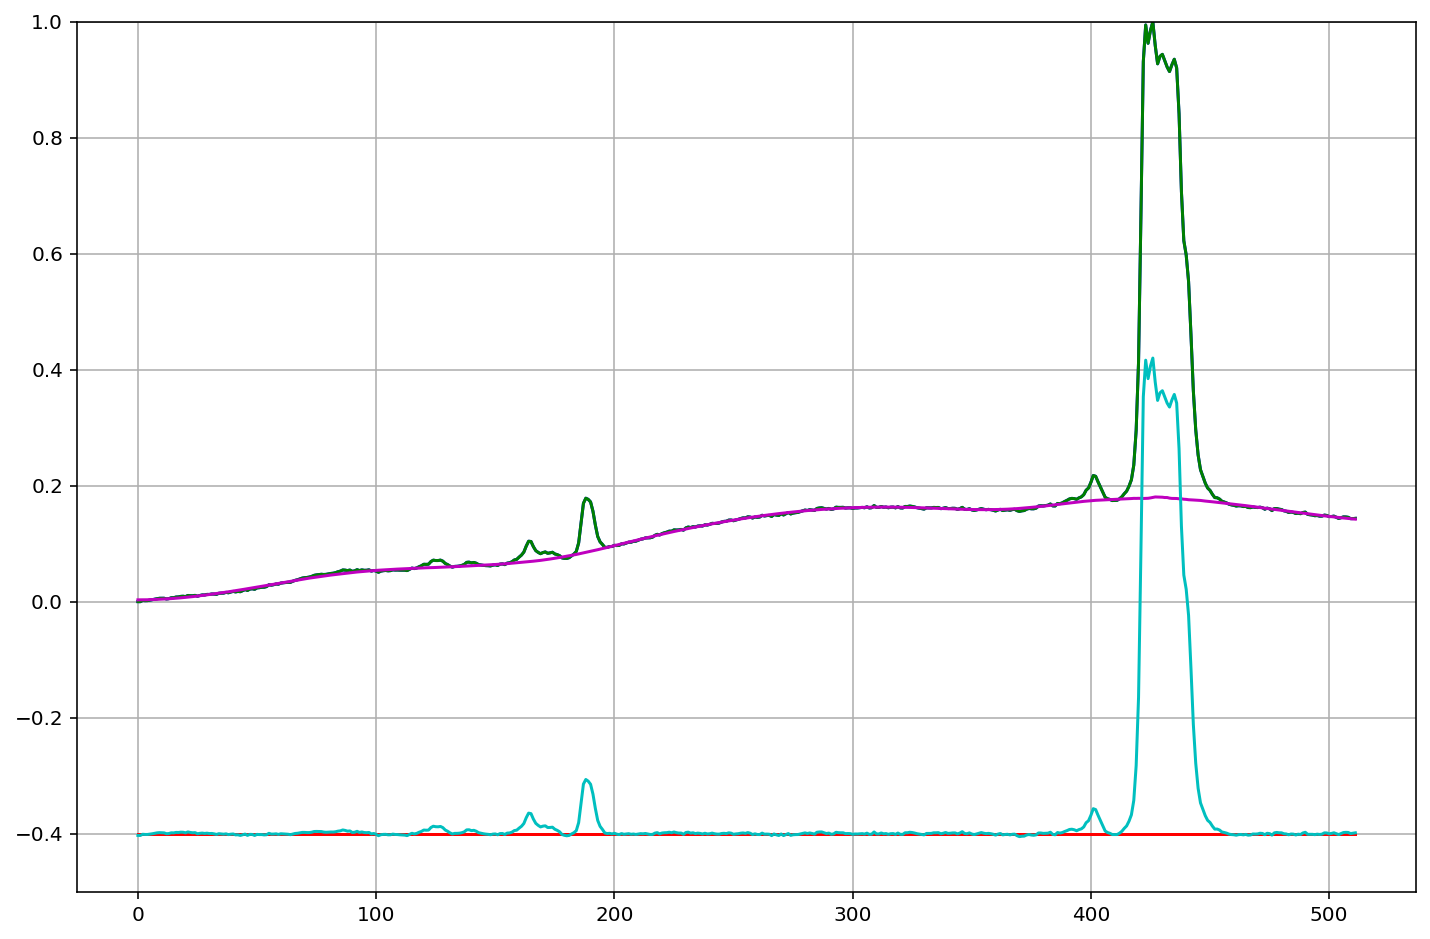

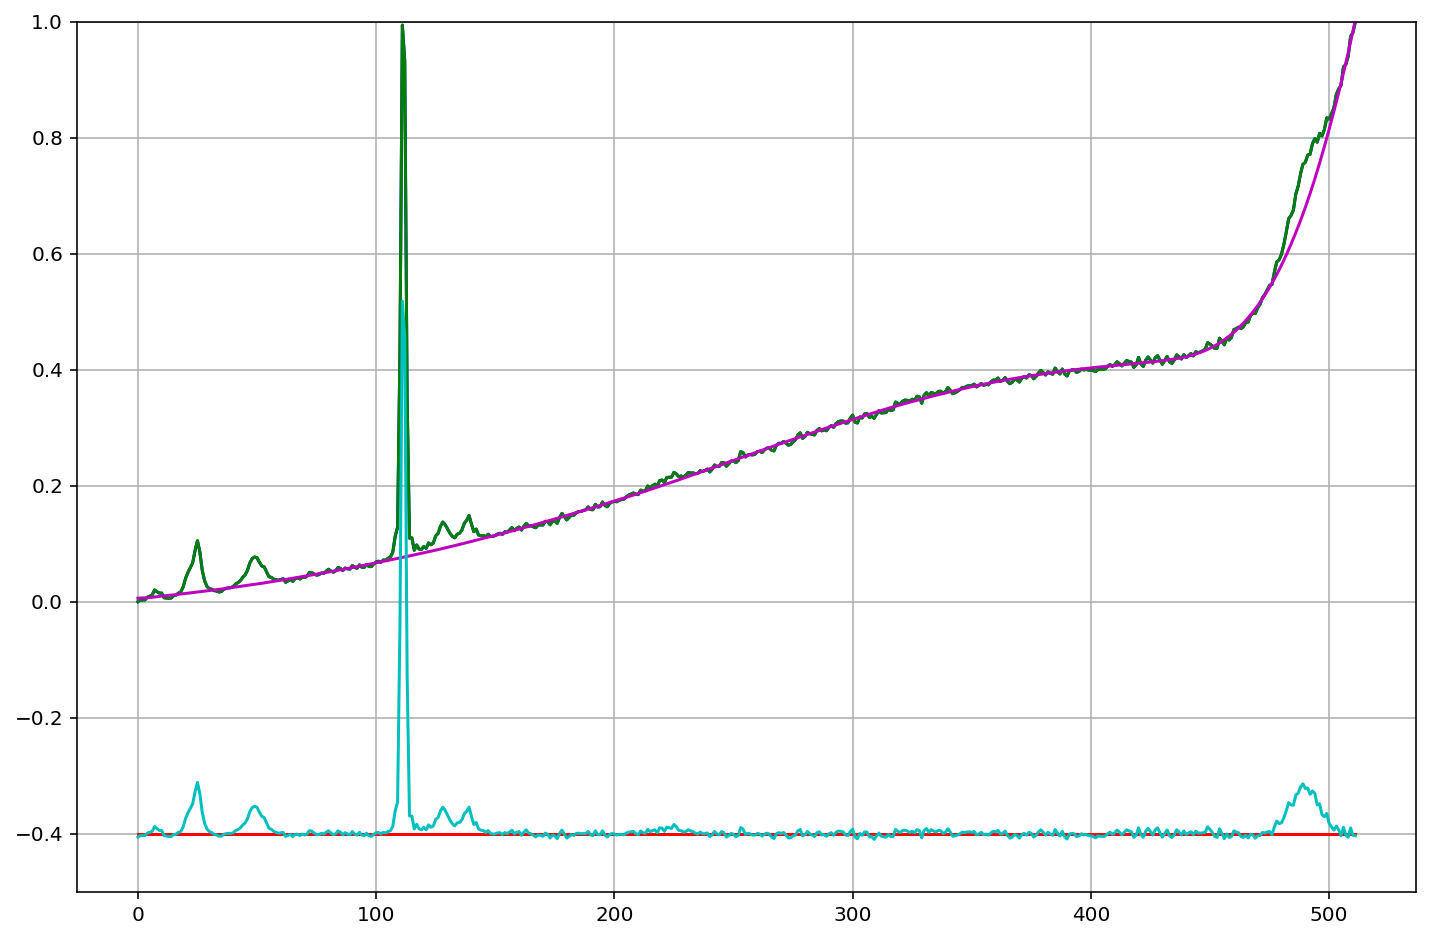

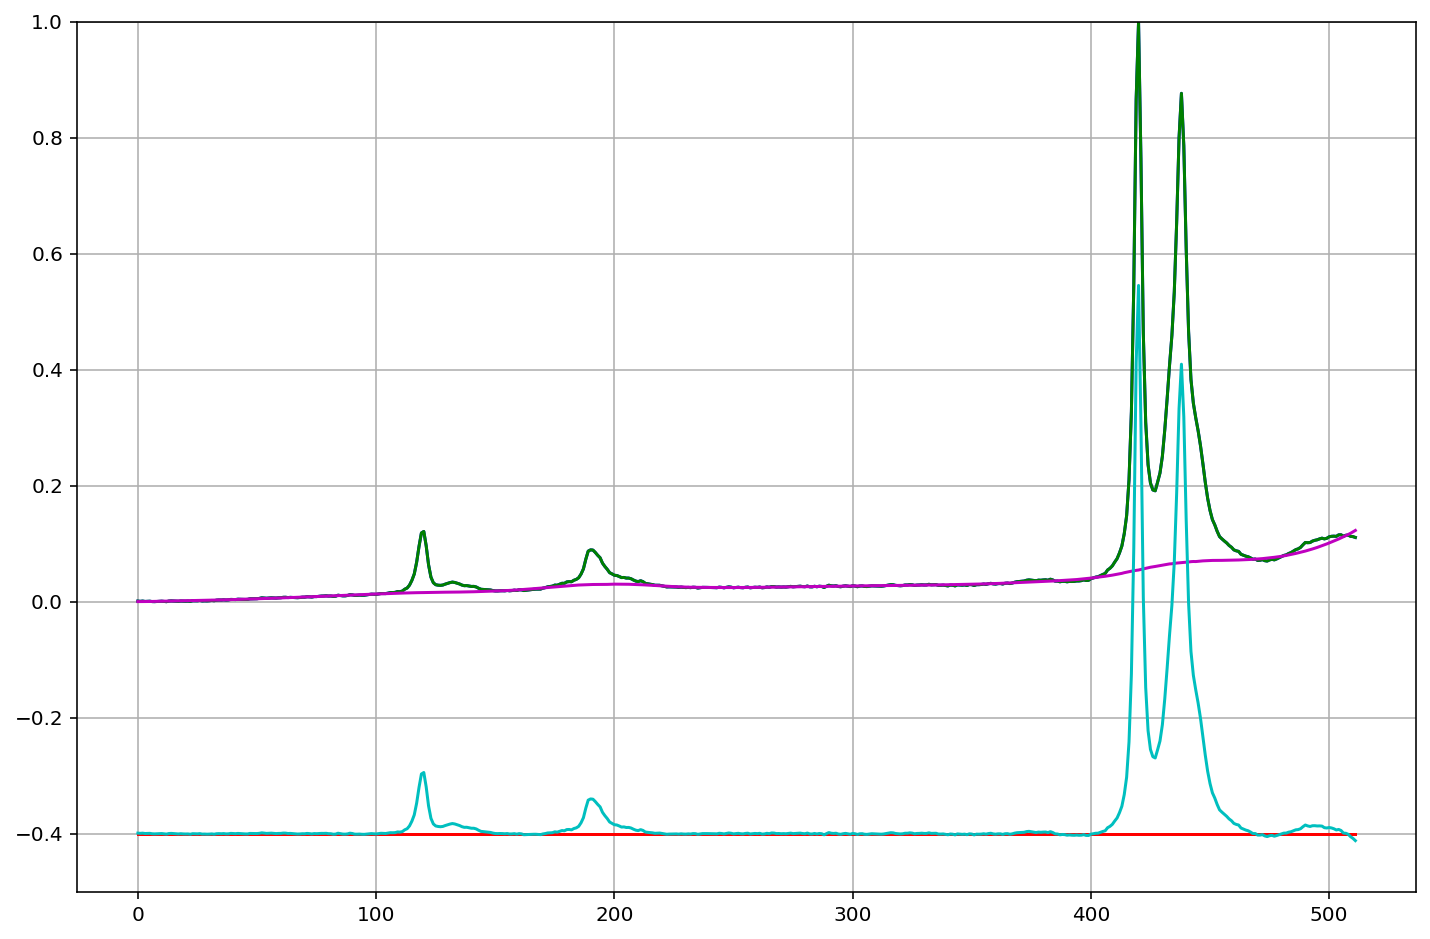

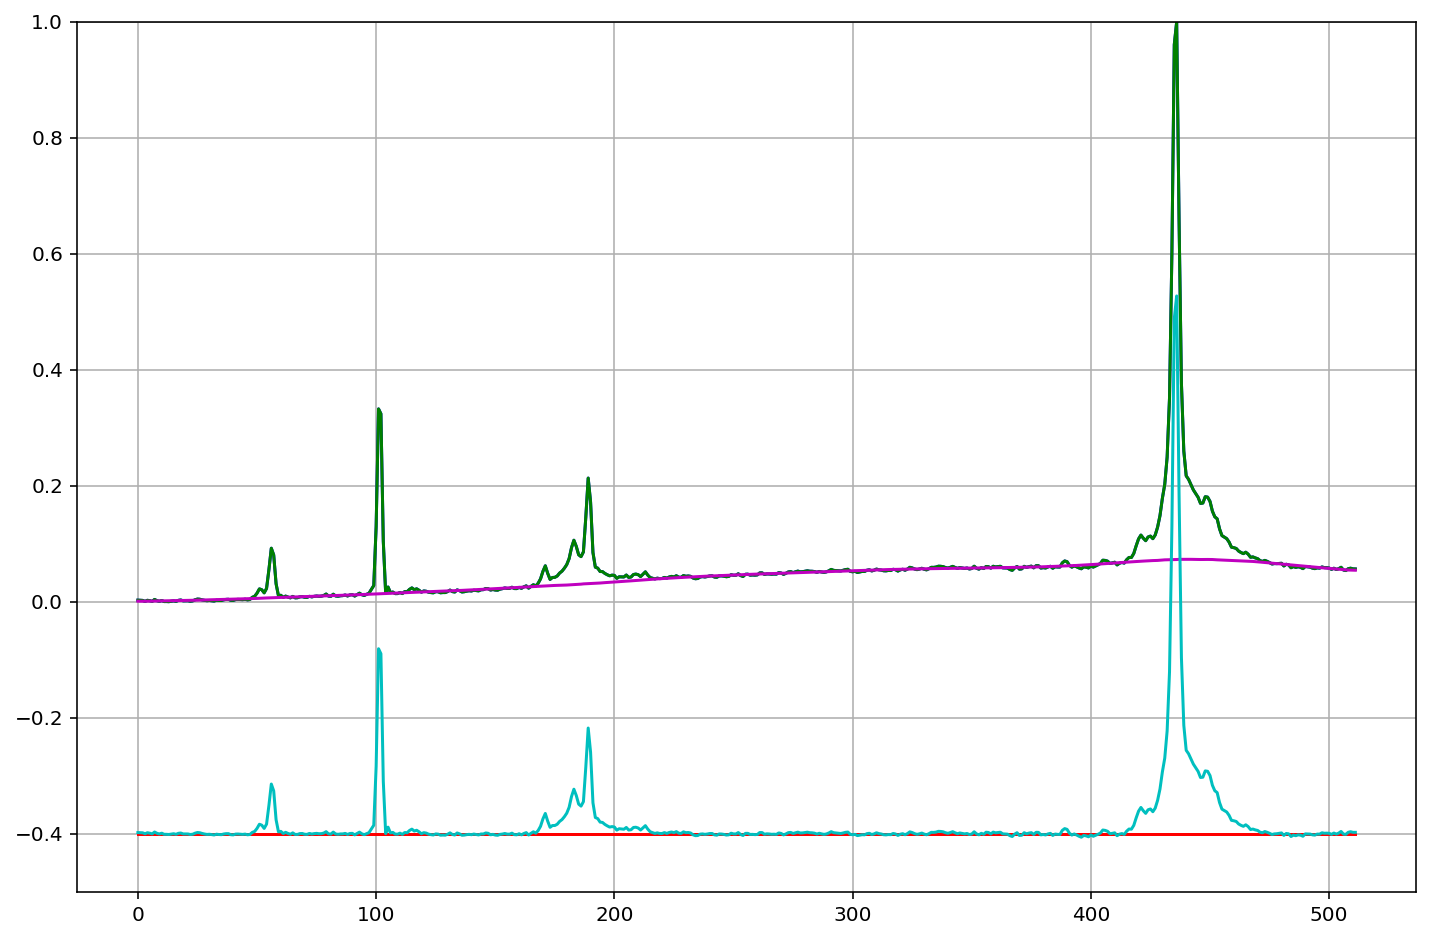

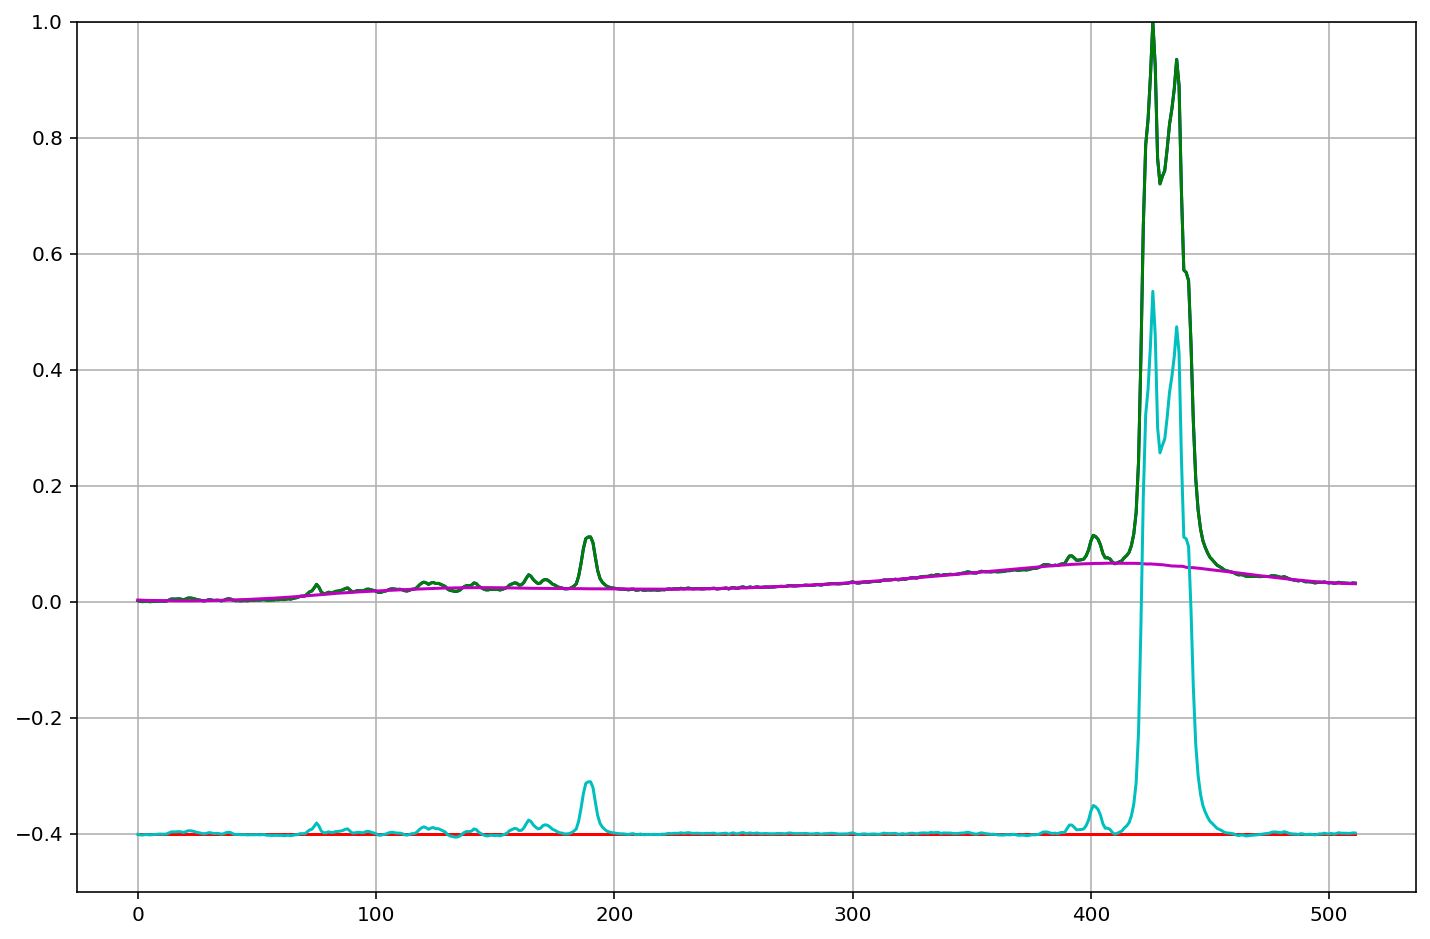

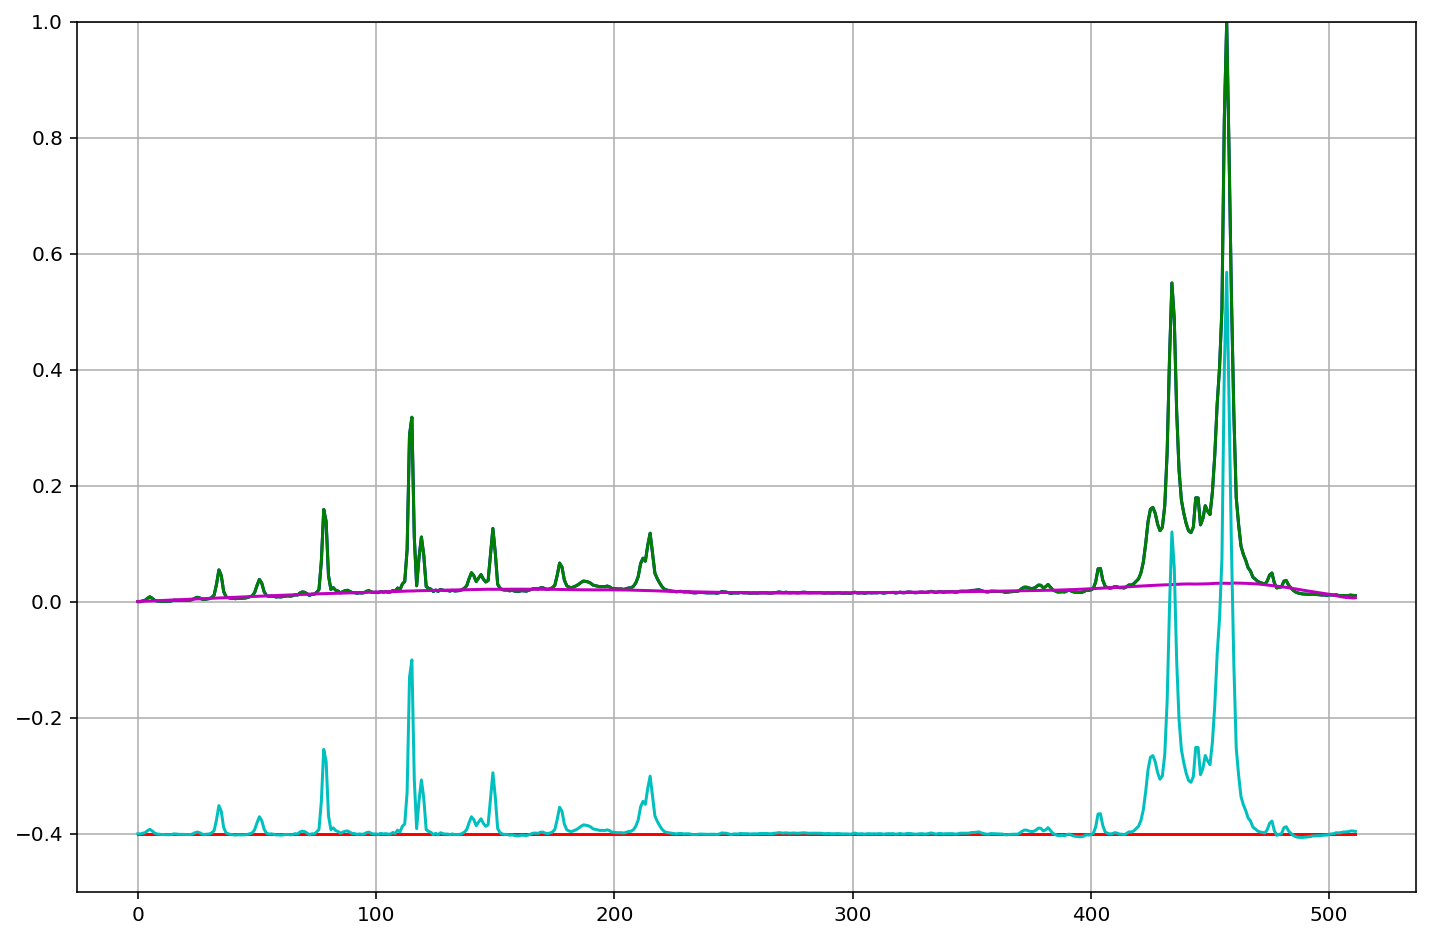

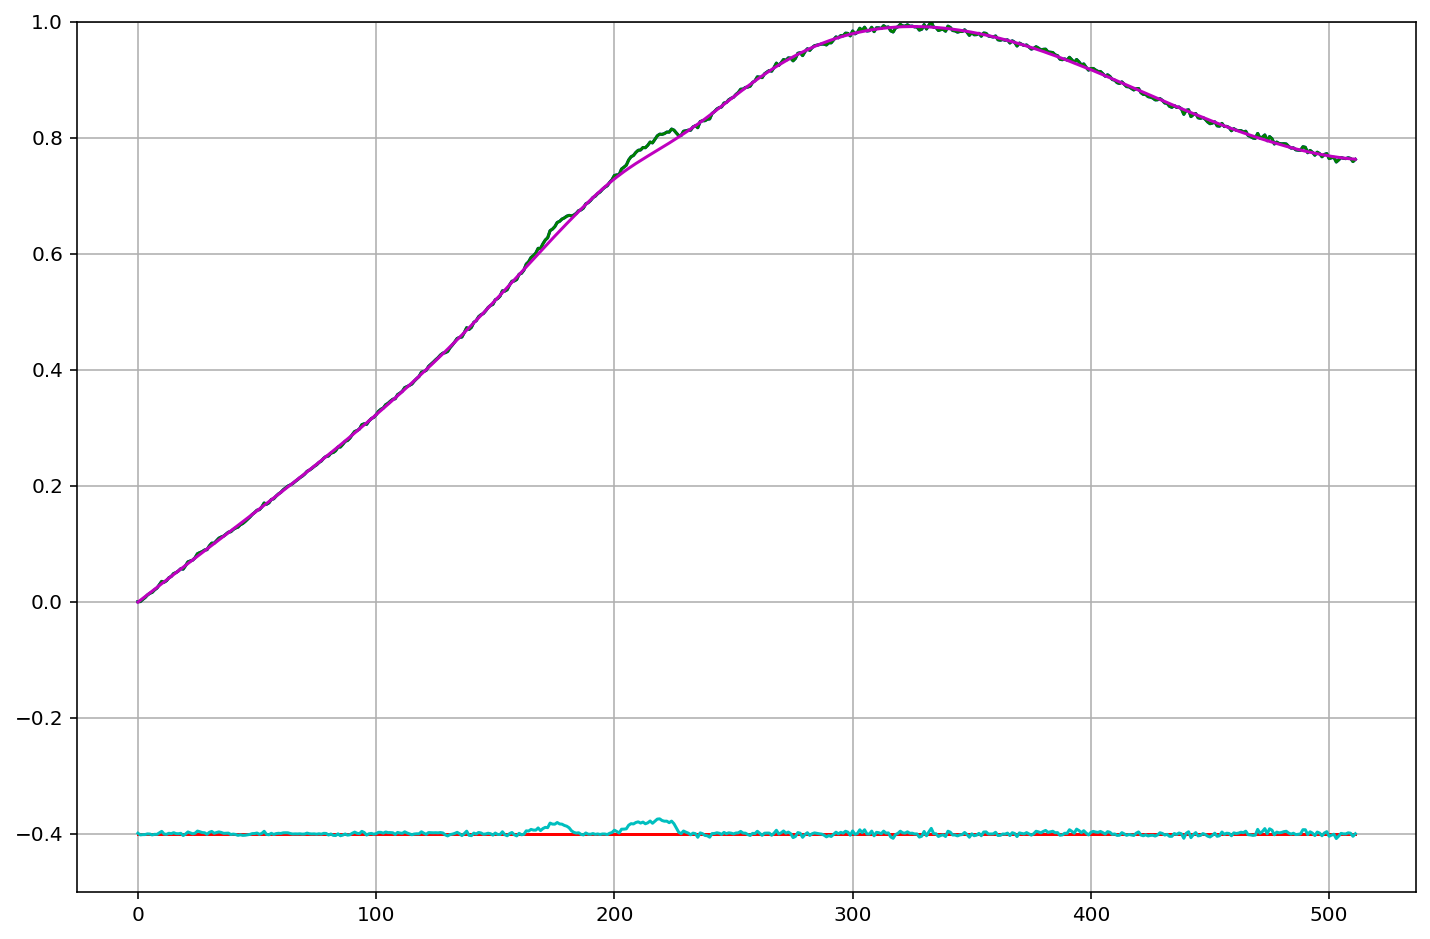

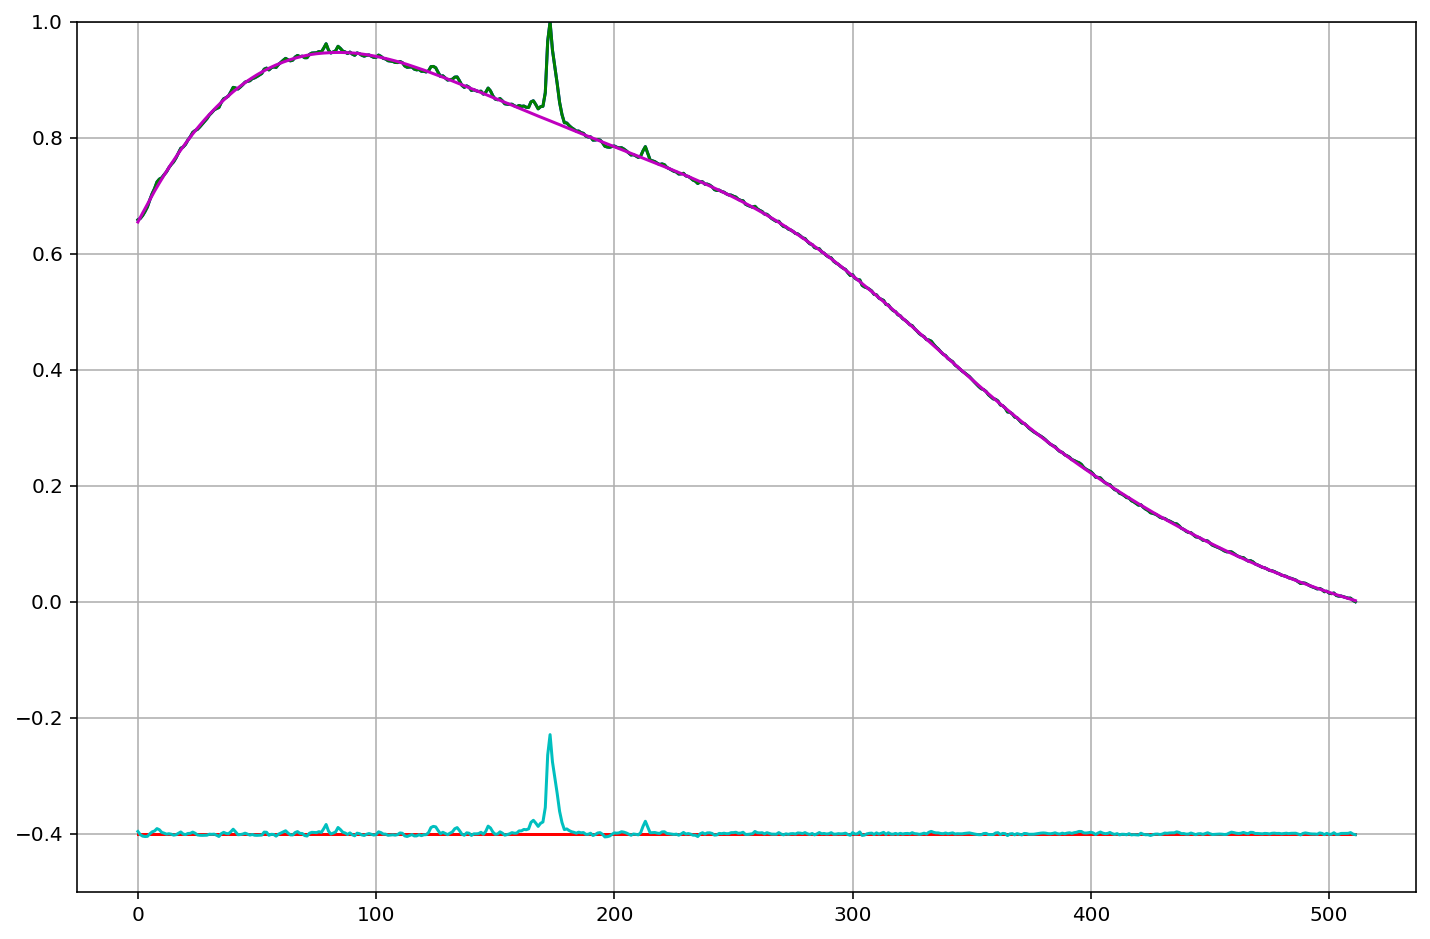

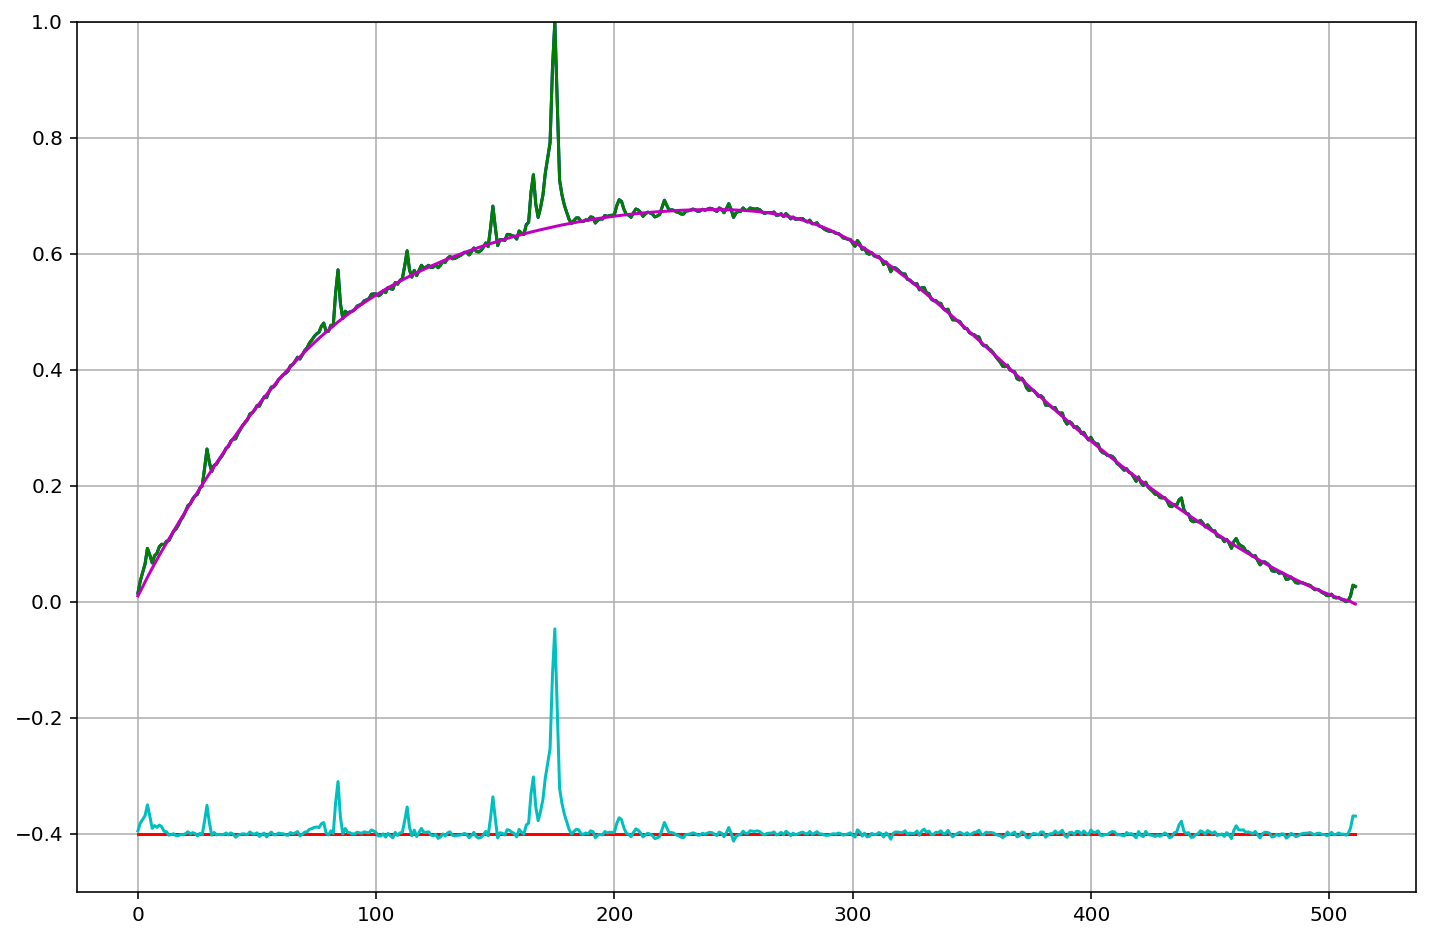

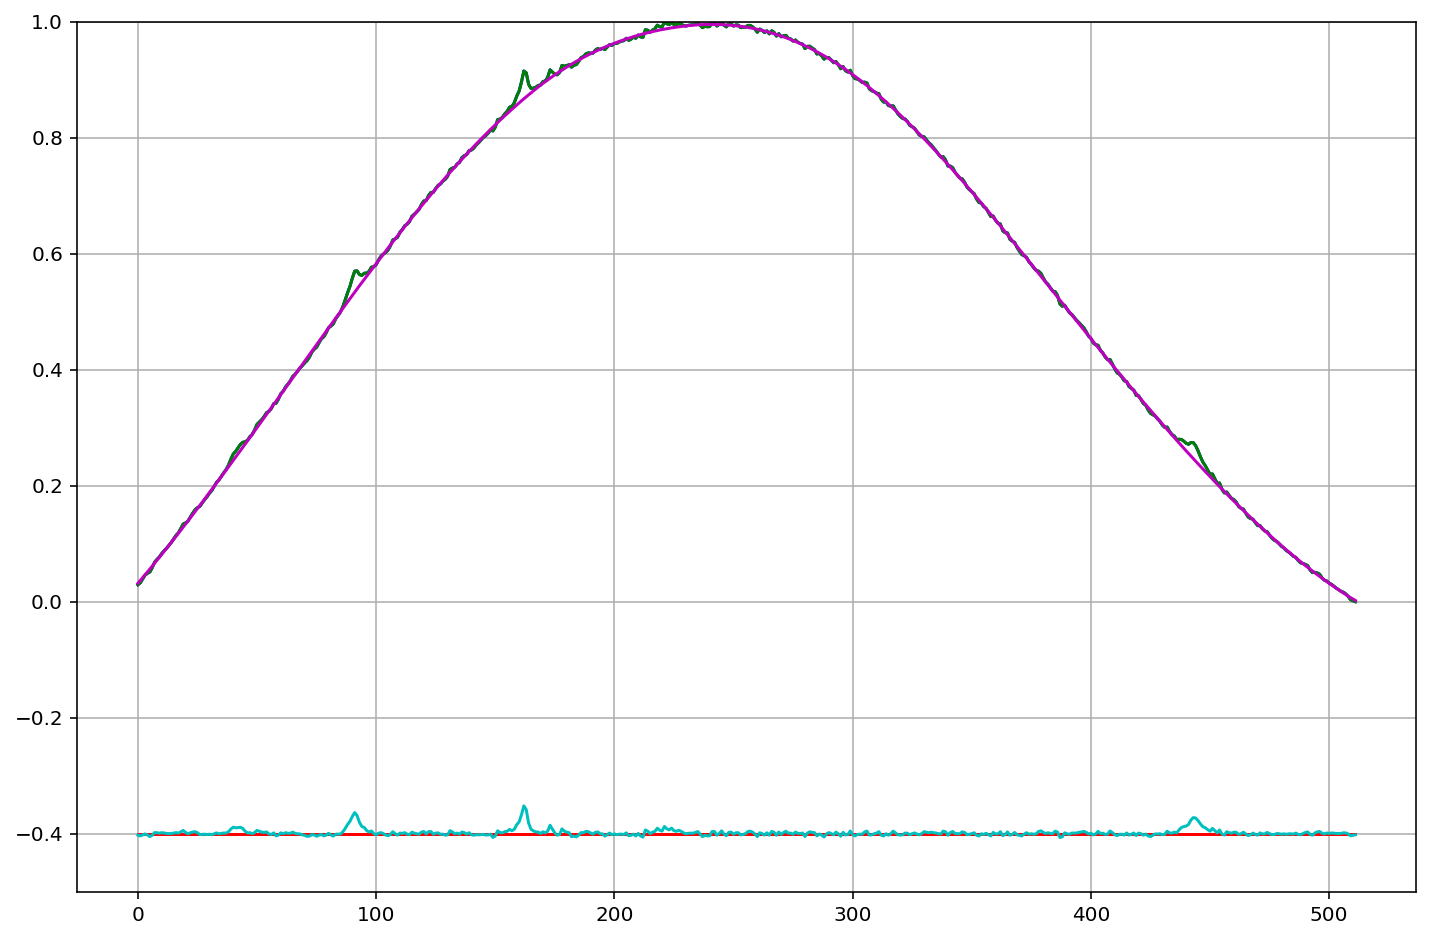

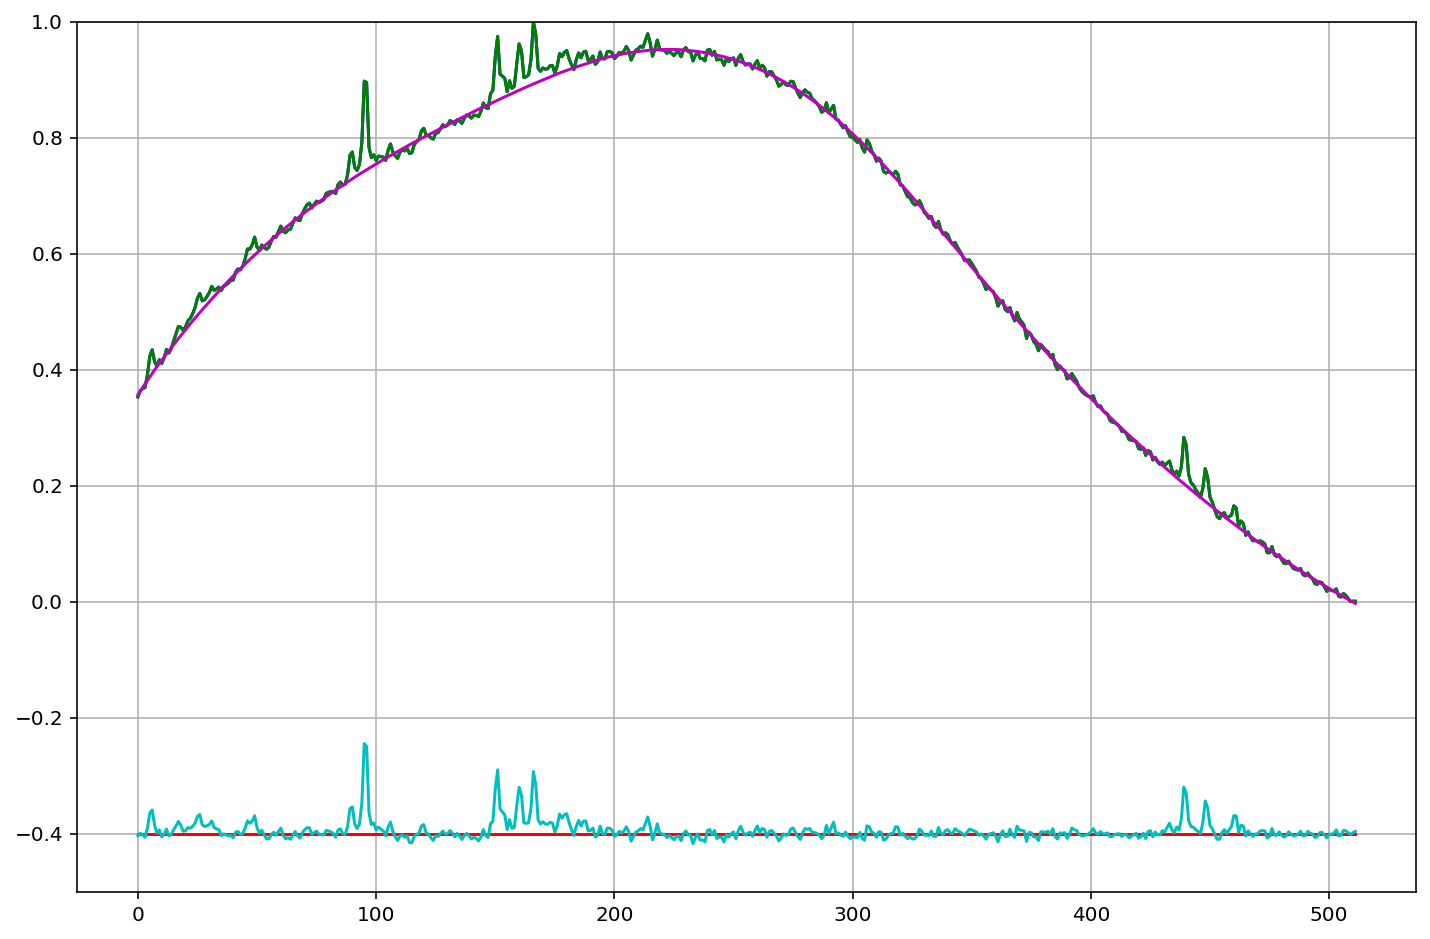

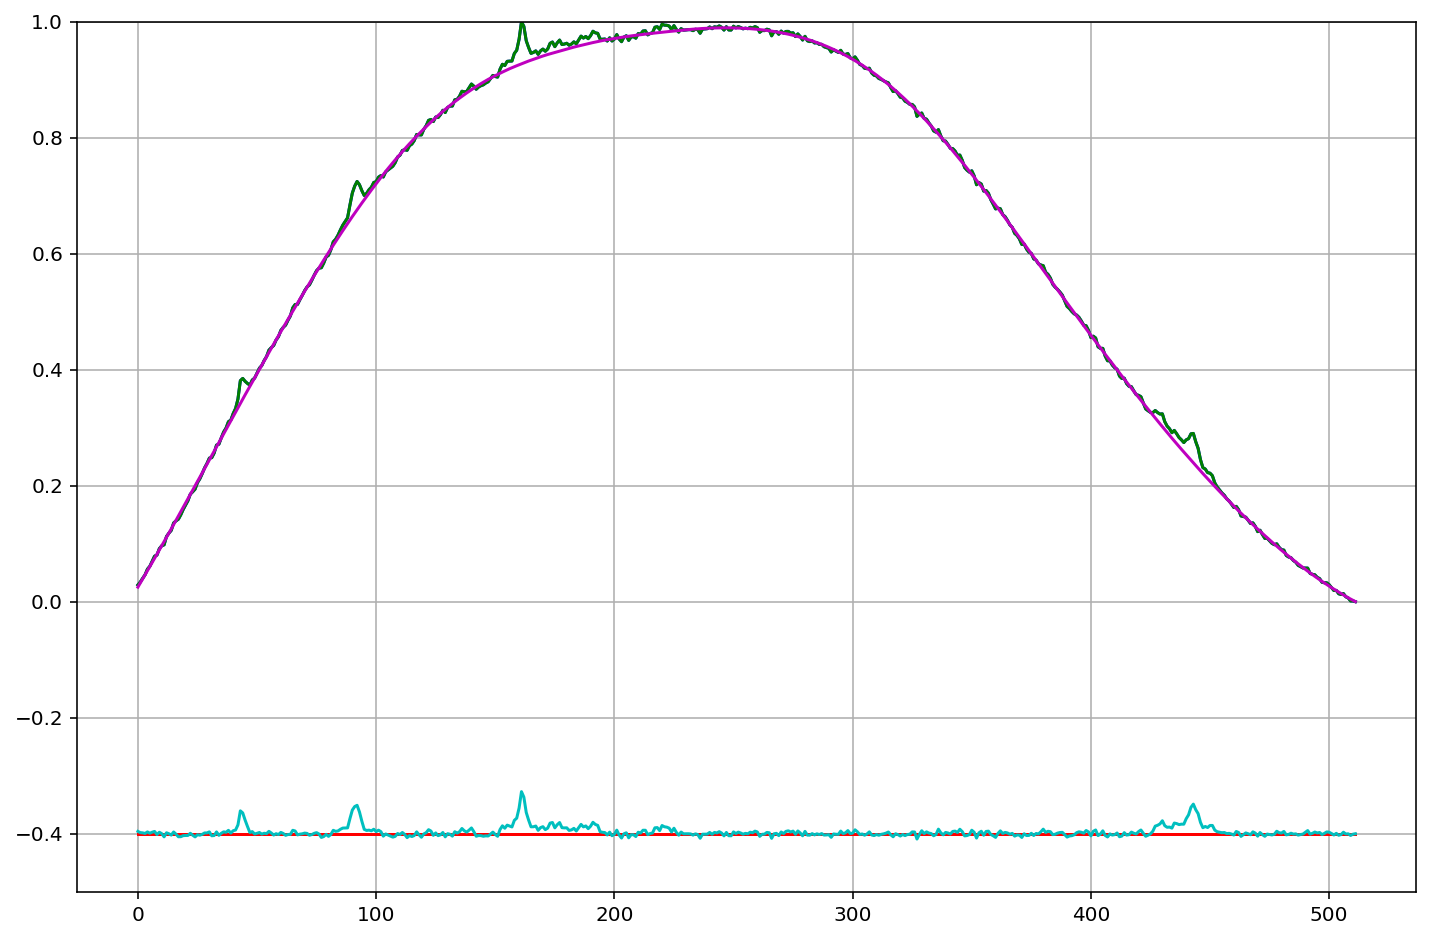

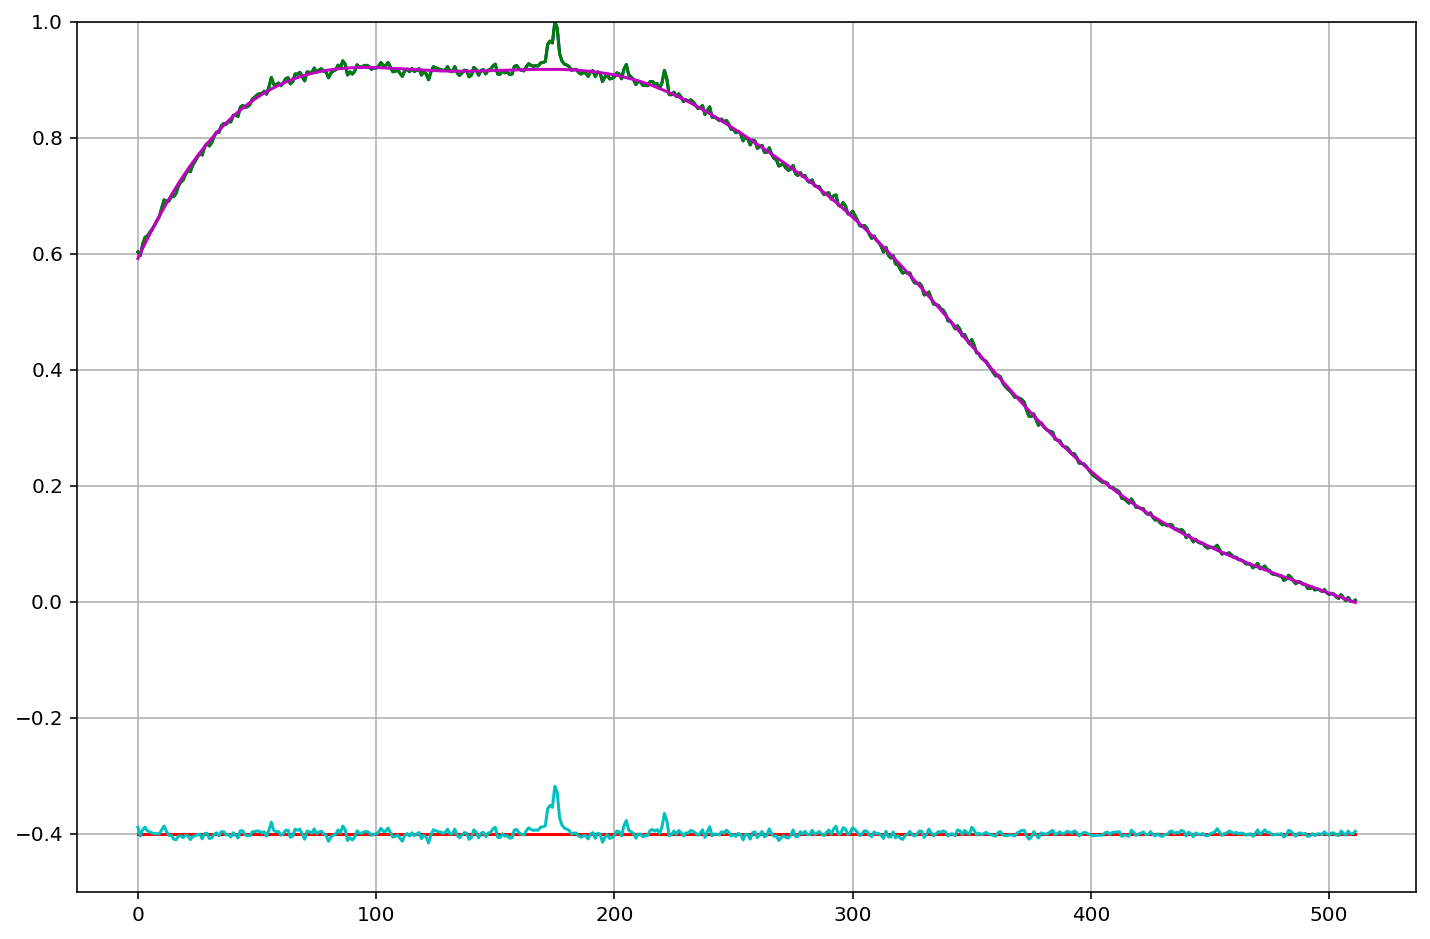

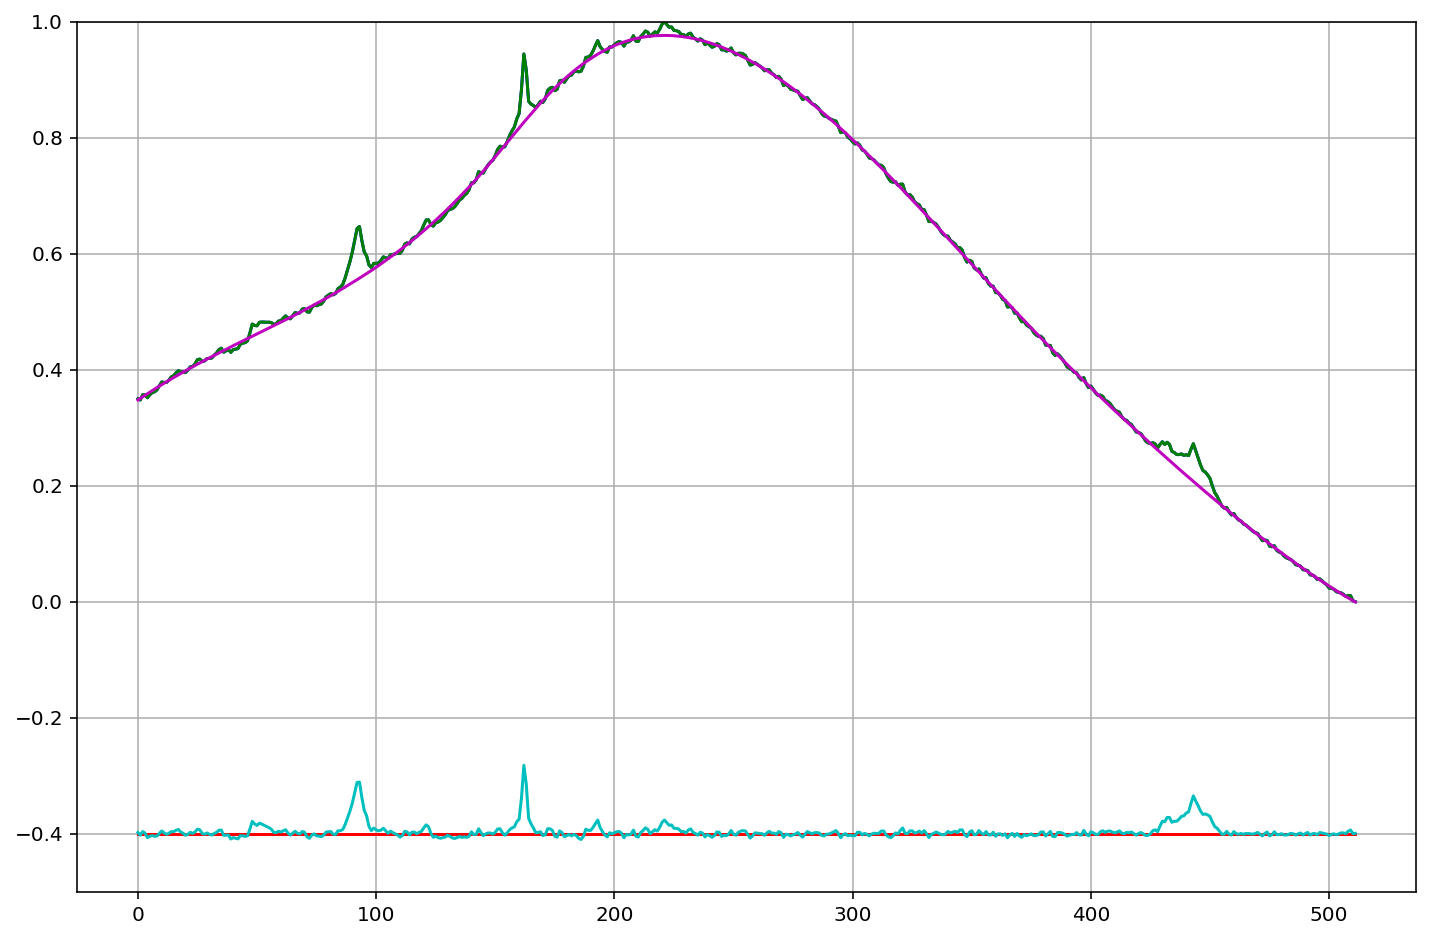

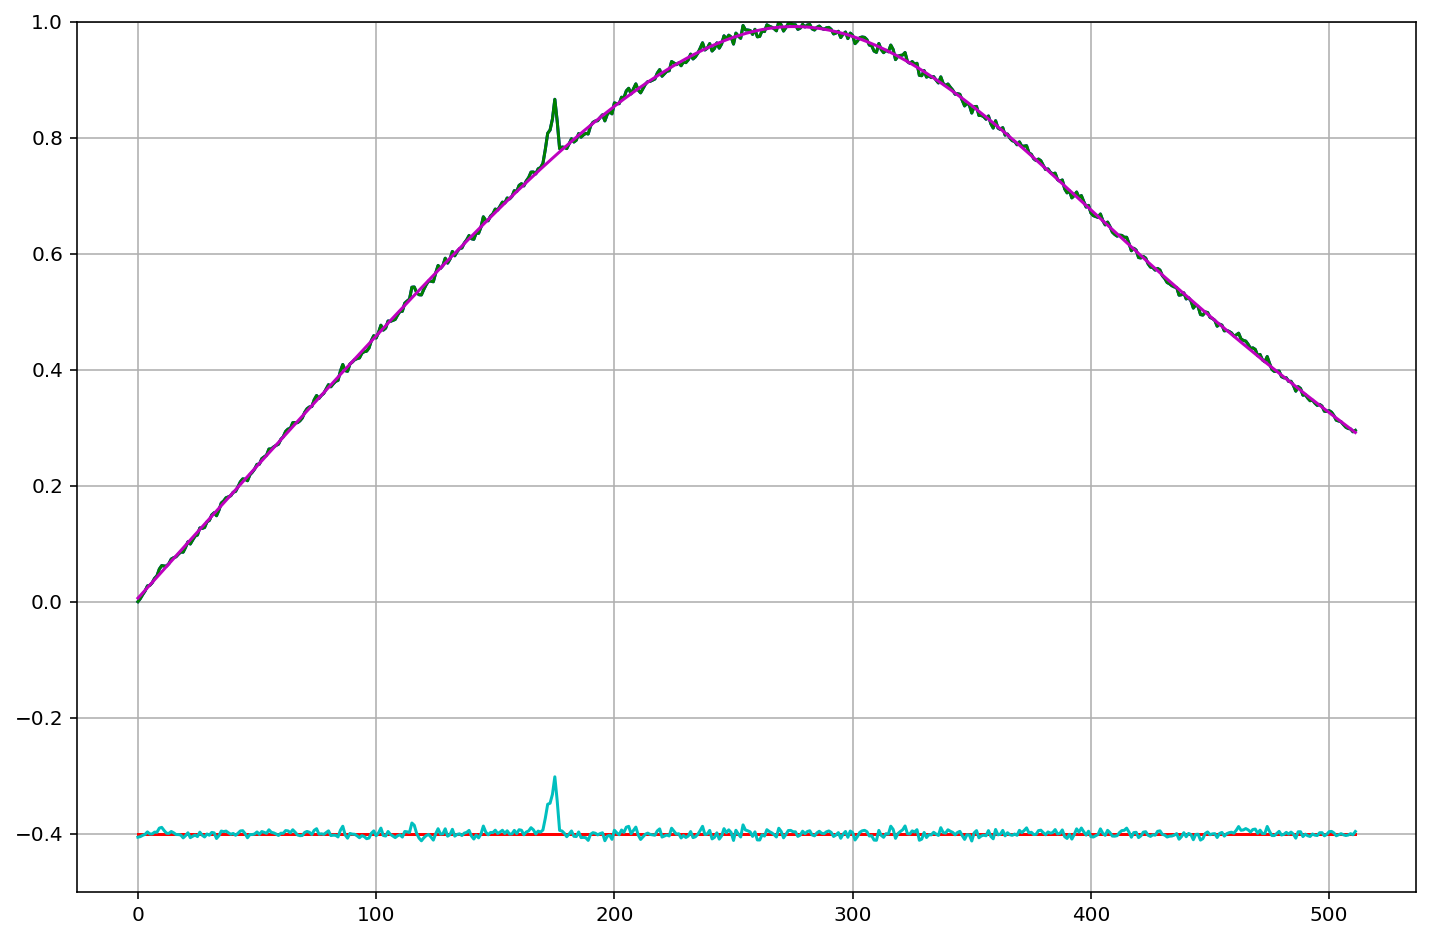

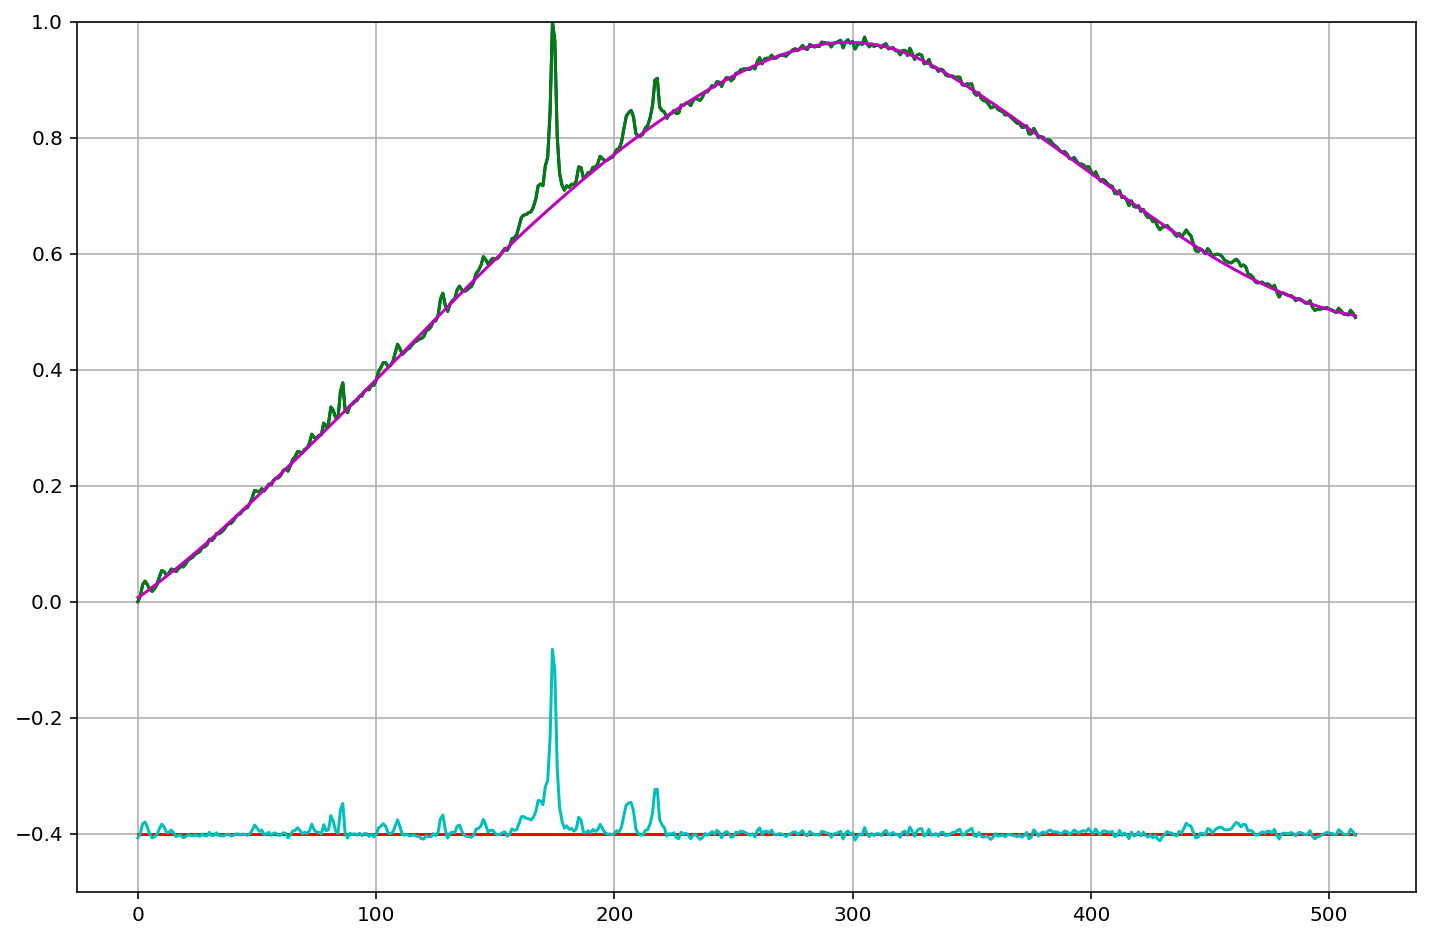

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import savgol_filter
from scipy.signal import decimate

data=np.loadtxt('ExplosiveX.txt')
(dataSize, dataLen) = data.shape
print(f'dataSize : {dataSize}, dataLen : {dataLen}')

data2 =np.empty((dataSize,dataLen//2), dtype=np.float32)
dataLen //= 2
for x,y in zip(data,data2):
#    x[0] = x[1]
#    x[:] = savgol_filter(x, window_length=13, polyorder=4)
    z = decimate(x,2,ftype='iir')  # make data length to 512
    mindata, maxdata = z.min(), z.max()
    y[:] = (z - mindata) / (maxdata - mindata)  # make data be in the range [0,1] 

saveX = np.empty_like(data2)
dataX = torch.tensor(data2, dtype=torch.float32)
#plt.plot(np.array(dataX[1]),'b')
with torch.no_grad():
    for i, (inX, savX) in enumerate(zip(dataX,saveX)):

        # dataXX[:] = torch.as_tensor(savgol_filter(x.numpy(), window_length=13, polyorder=4))  
        #dataXXX = dataXX.view(1,dataLen)
        if useGPU: inX = inX.cuda()
        
        outY = myNet(inX).cpu().numpy()
        outY = outY.reshape(dataLen)
        plt.figure(figsize=(12,8))
        plt.ylim(-0.5,1)
        plt.plot(data2[i,:],'b')
        plt.plot(inX.cpu().numpy(),'g')
        plt.plot(outY,'m')
        plt.plot(np.ones((len(outY),1))*(-0.4),'r')
        plt.plot(data2[i,:]-outY-0.4,'c')
        plt.grid(True)
        
        tempY = data2[i,:] - outY
        savX[:] = tempY - min(tempY)
        savX /= max(savX)

#np.save('ExplosiveX.npy', saveX )
